<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/Marine/Marine_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "0OAW.IL"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2010-04-01   51.50   51.50   51.50   51.50      38.32       0
2010-04-06   52.80   52.80   52.80   52.80      39.29       0
2010-04-07   52.55   52.80   52.51   52.80      39.29    6682
2010-04-08   52.80   52.80   52.80   52.80      39.29       0
2010-04-09   52.80   52.80   52.80   52.80      39.29       0
...            ...     ...     ...     ...        ...     ...
2018-12-21  189.55  192.30  188.55  191.62     184.50  456239
2018-12-24  191.62  191.62  191.62  191.62     184.50       0
2018-12-27  191.71  191.71  182.35  183.15     176.34  371751
2018-12-28  183.40  184.80  182.27  182.60     175.81  112225
2018-12-31  182.60  182.60  182.60  182.60     175.81       0

[2146 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2146.000000  2146.000000  2146.000000  2146.000000  2146.000000  2.146000e+03
mean     95.711249    96.372418    95.022610    95.753229    81.131789  2.491946e+05
std      47.337892    47.720891    46.791334    47.258962    46.515696  1.405988e+06
min       7.800000    22.300000     7.800000    22.300000    16.920000  0.000000e+00
25%      56.465000    57.002500    56.180000    56.912500    42.920000  1.718250e+03
50%      87.320000    87.940000    87.115000    87.610000    68.220000  2.506750e+04
75%     140.015000   140.997500   138.975000   139.942500   123.652500  1.560965e+05
max     204.300000   207.200000   203.800000   206.150000   196.360000  2.927177e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2010-06-16   52.00   52.00   52.00   52.00      38.87       0   16          2        167             30             0               1               0                 1      6        2    24        2             2          24   53.871901   53.371079  -55.416346   51.780514   52.474545   53.989492      53.060      53.060   54.014196   52.93375   51.582770   52.6310   52.267222   52.93375   51.900000   53.664861               56.103434                 52.93375               49.764066               57.688275                 52.93375               48.179225               59.273117                 52.93375               46.594383               60.857959                 52.93375               45.009541   52.474545   51.926520   53.561565               55.644228                52.474545               49.304861               57.229070                52.474545               47.720019               58.813912                52.474545               46.135177               60.398753   
2010-06-17   51.10   51.10   51.10   51.10      38.20       0   17          3        168             30             0               1               0                 1      6        2    24        3             0          24   52.485951   53.149797  -55.133365   51.391713   52.169090   53.552551      52.650      52.925   53.749060   52.39375   51.173087   52.1175   51.859722   52.39375   51.550000   53.505218               55.127080                 52.39375               49.660420               56.493745                 52.39375               48.293755               57.860410                 52.39375               46.927090               59.227075                 52.39375               45.560425   52.169090   51.367093   53.386446               54.902420                52.169090               49.435760               56.269085                52.169090               48.069095               57.635751                52.169090               46.702430               59.002416   
2010-06-18   51.50   51.50   51.50   51.50      38.50       0   18

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2.096000e+03  2096.000000  2096.000000  2096.000000    2096.000000   2096.000000     2096.000000     2096.000000       2096.000000  2096.000000  2096.000000  2096.000000  2096.000000   2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000  2096.000000  2096.000000  2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000   
mean     96.711760    97.382796    96.014198    96.756679    82.113898  2.540165e+05    15.630725     2.033397   189.681775      30.455153      0.033397        0.969466        0.010496          0.992366     6.741889     2.579198    27.450859     2.033397      1.961355    27.450859    96.519872    96.018412     6.221485    96.760189    96.532958    96.519187    96.533745    96.043681    94.884603    96.533746    96.757525    96.534385    96.608884    96.533746    96.720366    96.075829               99.661150                96.533746               93.406343              101.224852                96.533746               91.842641              102.788554                96.533746               90.278939              104.352255                96.533746               88.715237    96.532958    96.713031    96.145484               99.660361                96.532958               93.405554              101.224063                96.532958               91.841852              102.787765   
std      47.448036    47.830075    46.897939    47.364685    46.625086  1.422037e+06     8.702184     1.399567   104.991134       0.794908      0.179714        0.172093        0.101936          0.087057     3.441385     1.117629    14.988921     1.399567      1.404029    14.988921    47.204515    46.823925   105.957740    47.386945    47.205545    47.069149    47.235885    47.028843    46.703280    47.223851    47.372067    47.233177    47.266975    47.223851    47.347984    46.912450               48.185307                47.223851               46.314467               48.684604                47.223851               45.880276               49.195781                47.223851               45.460279               49.718472                47.223851               45.054874    47.205545    47.333849    46.962203               48.167384                47.205545               46.295782               48.666875                47.205545               45.861405               49.178245   
min       7.800000    22.300000     7.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2010-06-16  0.224936  0.160627  0.225510  0.161545   0.122325       0   16          2        167             30             0               1               0                 1      6        2    24        2             2          24  0.170328  0.165057  0.374394  0.162149  0.162910  0.171462    0.167258    0.167234  0.231766  0.166626  0.161732  0.164517  0.162168  0.166626  0.161628  0.166303                0.174617                 0.166626                0.163855                0.175212                 0.166626                0.164599                0.175802                 0.166626                0.165929                0.176401                 0.166626                0.168553  0.162910  0.161286  0.166428                0.169357                 0.162910                0.160923                0.170105                 0.162910                0.162429                0.170599                 0.162910                0.166067                0.171025                 0.162910   
2010-06-17  0.220356  0.155760  0.220918  0.156649   0.118591       0   17          3        168             30             0               1               0                 1      6        2    24        3             0          24  0.162638  0.163789  0.375092  0.160025  0.161209  0.168965    0.164969    0.166481  0.230437  0.163626  0.159497  0.161673  0.159913  0.163626  0.159708  0.165399                0.169324                 0.163626                0.163273                0.168932                 0.163626                0.165244                0.168593                 0.163626                0.167805                0.168316                 0.163626                0.171632  0.161209  0.158223  0.165439                0.165368                 0.161209                0.161660                0.165096                 0.161209                0.164401                0.164639                 0.161209                0.169253                0.164170                 0.161209   
2010-06-18  0.222392  0.157923  0.222959  0.158825   0.1

140553

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3f41q42h
  JVM stdout: /tmp/tmp3f41q42h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3f41q42h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_3hflnk
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5   0.690248                   0.5  0.498550  0.248552
1              DeepLearning_1_AutoML_20190906_003129  0.5  18.585151                   0.5  0.733550  0.538095
2  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5   0.690248                   0.5  0.498550  0.248552
3  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5  18.585151                   0.5  0.733550  0.538095
4  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5   0.690473                   0.5  0.498661  0.248663
5  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5  18.585151                   0.5  0.733550  0.538095
6  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5   0.692111                   0.5  0.499470  0.249471
7  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5  18.585151                   0.5  0.733550  0.538095
8  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5  18.585151                   0.5  0.733550  0.538095
9  DeepLearning_grid_1_AutoML_20190906_003129_mod...  0.5  15.953625                   0.5  0.679636  0.461905

variable  relative_importance  scaled_importance  percentage
0                   dayofweek             1.000000           1.000000    0.001272
1                     CDLDOJI             0.947944           0.947944    0.001206
2                     weekday             0.942285           0.942285    0.001198
3                weekday_name             0.930769           0.930769    0.001184
4              STOCHRSI_fastk             0.923740           0.923740    0.001175
...                       ...                  ...                ...         ...
1038  BBANDS_upperband_14_3_2             0.666251           0.666251    0.000847
1039       CDLKICKINGBYLENGTH             0.660777           0.660777    0.000840
1040              CDLDOJISTAR             0.659270           0.659270    0.000838
1041                      TAN             0.649565           0.649565    0.000826
1042      CDLGAPSIDESIDEWHITE             0.638587           0.638587    0.000812

[1043 rows x 4 columns]

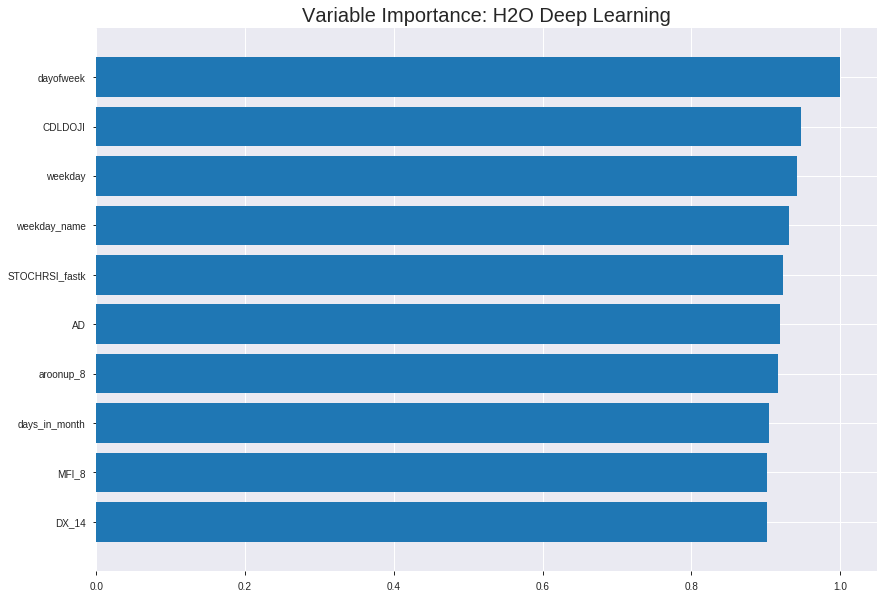

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_003129_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24538307147408372
RMSE: 0.49536155631425793
LogLoss: 0.683883521252094
Mean Per-Class Error: 0.45982356898528476
AUC: 0.5398741673536296
pr_auc: 0.601936815127802
Gini: 0.07974833470725917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5363568378022021: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    635   1        (635.0/635.0)
1      0    831   0        (0.0/831.0)
Total  0    1466  0.4332   (635.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.536357     0.723552   399
max f2                       0.536357     0.867432   399
max f0point5                 0.536357     0.620612   399
max accuracy                 0.536357     0.566849   399
max precision                0.570029     1          0
max recall                   0.536357     1          399
max specificity              0.570029     1          0
max absolute_mcc             0.54784      0.0815819  253
max min_per_class_accuracy   0.53951      0.529483   363
max mean_per_class_accuracy  0.544182     0.540176   302

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 54.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.568323           1.17609   1.17609            0.666667         0.569302  0.666667                    0.569302            0.0120337       0.0120337                  17.6093   17.6093
    2        0.0204638                   0.567206           1.17609   1.17609            0.666667         0.567591  0.666667                    0.568446            0.0120337       0.0240674                  17.6093   17.6093
    3        0.0300136                   0.566216           1.13409   1.16273            0.642857         0.566764  0.659091                    0.567911            0.0108303       0.0348977                  13.409    16.2728
    4        0.0402456                   0.565459           0.940874  1.10632            0.533333         0.565934  0.627119                    0.567408            0.00962696      0.0445247                  -5.91256  10.6325
    5        0.0504775                   0.564734           1.17609   1.12047            0.666667         0.565099  0.635135                    0.56694             0.0120337       0.0565584                  17.6093   12.0467
    6        0.100273                    0.560111           1.06332   1.09209            0.60274          0.562148  0.619048                    0.56456             0.0529483       0.109507                   6.3317    9.20864
    7        0.150068                    0.557473           1.20831   1.13065            0.684932         0.558608  0.640909                    0.562585            0.0601685       0.169675                   20.8315   13.0653
    8        0.200546                    0.555415           0.977429  1.09209            0.554054         0.556374  0.619048                    0.561022            0.0493381       0.219013                   -2.25713  9.20864
    9        0.300136                    0.549944           1.12373   1.10259            0.636986         0.552877  0.625                       0.558319            0.111913        0.330927                   12.3733   10.2587
    10       0.400409                    0.544908           0.984078  1.07291            0.557823         0.54754   0.608177                    0.55562             0.0986763       0.429603                   -1.59221  7.29094
    11       0.5                         0.539837           0.966652  1.05174            0.547945         0.542372  0.59618                     0.552981            0.0962696       0.525872                   -3.33482  5.17449
    12       1                           0.536357           0.948255  1                  0.537517         0.536511  0.566849                    0.544746            0.474128        1                          -5.17449  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24863193431004624
RMSE: 0.4986300575677786
LogLoss: 0.6904085511001878
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5363568146439248: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536357     0.698758  0
max f2                       0.536357     0.852919  0
max f0point5                 0.536357     0.591794  0
max accuracy                 0.536357     0.536993  0
max precision                0.536357     0.536993  0
max recall                   0.536357     1         0
max specificity              0.536357     0         0
max absolute_mcc             0.536357     0         0
max min_per_class_accuracy   0.536357     0         0
max mean_per_class_accuracy  0.536357     0.5       0

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 53.64 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.536357           1       1                  0.536993         0.536357  0.536993                    0.536357            1               1                          0       0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 00:54:09  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 00:54:11  5 min 54.036 sec   251 obs/sec       0.380628  1             558        0.6024           1.17276             -0.477964      0.52737         0.59182            1.2937           0.432469                         0.714202           8.34198               -1.05157         0.543826          0.575761             1.48978            0.463007
    2019-09-06 00:54:52  6 min 34.891 sec   212 obs/sec       5.6603    15            8298       0.500177         0.694458            -0.018923      0.499491        0.558314           0.823265         0.431787                         0.609481           6.38682               -0.494048        0.438855          0.380667             0.785892           0.463007
    2019-09-06 00:55:33  7 min 16.294 sec   224 obs/sec       11.7108   31            17168      0.506217         0.705768            -0.0436796     0.485804        0.544906           0.940874         0.428377                         0.613894           5.68665               -0.51576         0.567148          0.596678             1.48978            0.463007
    2019-09-06 00:56:15  7 min 57.751 sec   238 obs/sec       18.5041   49            27127      0.495362         0.683884            0.000603579    0.539874        0.601937           1.17609          0.433151                         0.49863            0.690409              -1.62702e-06     0.5               0                    1                  0.463007
    2019-09-06 00:56:56  8 min 38.374 sec   258 obs/sec       26.4734   70            38810      0.495526         0.684213            -6.01977e-05   0.52728         0.587087           0.940874         0.433151                         0.499908           0.692999              -0.00513338      0.5               0                    1                  0.463007
    2019-09-06 00:57:35  9 min 18.249 sec   272 obs/sec       34.6678   92            50823      0.494622         0.68238             0.00358358     0.530127        0.597738           1.05848          0.433151                         0.586663           5.37398               -0.384273        0.442027          0.402124             0.779535           0.463007
    2019-09-06 00:58:17  9 min 59.425 sec   286 obs/sec       43.6664   116           64015      0.495355         0.683865            0.000630142    0.560885        0.630744           1.41131          0.433151                         0.500167           0.69353               -0.00617564      0.5               0                    1                  0.463007
    2019-09-06 00:58:57  10 min 39.581 sec  305 obs/sec       54.1419   144           79372      0.495682         0.684529            -0.000688256   0.514015        0.0665862          1.014            0.425648                         0.500566           0.694349              -0.00778194      0.496289          0.00953559           0.996492           0.460621
    2019-09-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
dayofweek                1.0                    1.0                  0.0012718321269316428
CDLDOJI                  0.9479442238807678     0.9479442238807678   0.0012056259184708424
weekday                  0.9422849416732788     0.9422849416732788   0.0011984282615439853
weekday_name             0.9307687878608704     0.9307687878608704   0.001183781647146678
STOCHRSI_fastk           0.9237403869628906     0.9237403869628906   0.001174842701083672
---                      ---                    ---                  ---
BBANDS_upperband_14_3_2  0.6662507653236389     0.6662507653236389   0.0008473591279313986
CDLKICKINGBYLENGTH       0.6607772707939148     0.6607772707939148   0.0008403977617419108
CDLDOJISTAR              0.6592699289321899     0.6592699289321899   0.0008384806759359002
TAN                      0.6495652198791504     0.6495652198791504   0.0008261379151797201
CDLGAPSIDESIDEWHITE      0.6385870575904846     0.6385870575904846   0.0008121755356863255


See the whole table with table.as_data_frame()


('accuracy', 0.5380952380952381)

('F1', 0.6996904024767803)

('auc', 0.5)

('logloss', 0.6902479489319214)

('mean_per_class_error', 0.5)

('rmse', 0.49854967149779855)

('mse', 0.24855177495056283)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


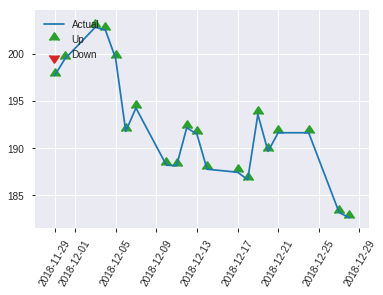


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24855177495056283
RMSE: 0.49854967149779855
LogLoss: 0.6902479489319214
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5363568146439248: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536357     0.69969   0
max f2                       0.536357     0.853474  0
max f0point5                 0.536357     0.592865  0
max accuracy                 0.536357     0.538095  0
max precision                0.536357     0.538095  0
max recall                   0.536357     1         0
max specificity              0.536357     0         0
max absolute_mcc             0.536357     0         0
max min_per_class_accuracy   0.536357     0         0
max mean_per_class_accuracy  0.536357     0.5       0

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 53.64 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.536357           1       1                  0.538095         0.536357  0.538095                    0.536357            1               1                          0       0

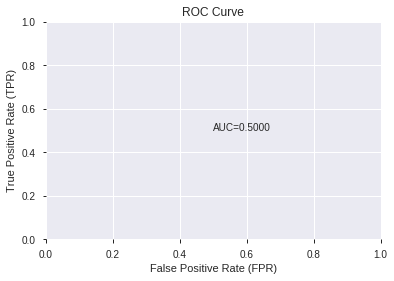

This function is available for GLM models only


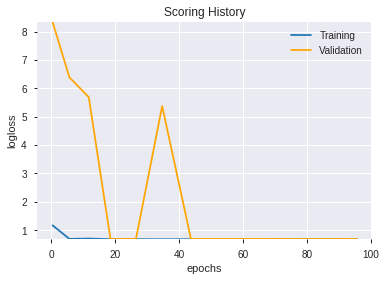

--2019-09-06 01:01:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  34.3MB/s    in 11s     

2019-09-06 01:02:06 (31.9 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_003129_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_003129_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_010220_model_6  0.526959  0.693482              0.484536  0.500166  0.250166
1  DeepLearning_grid_1_AutoML_20190906_010220_model_8  0.513137  0.691705              0.488231  0.499277  0.249277
2  DeepLearning_grid_1_AutoML_20190906_010220_model_7  0.481617  0.757462              0.494845  0.527148  0.277885
3  DeepLearning_grid_1_AutoML_20190906_010220_model_9  0.477602  0.693727              0.488961  0.500287  0.250287
4  DeepLearning_grid_1_AutoML_20190906_010220_model_2  0.477602  0.970443              0.488961  0.574739  0.330325
5               DeepLearning_1_AutoML_20190906_010220  0.475869  1.052489              0.500000  0.588848  0.346742
6  DeepLearning_grid_1_AutoML_20190906_010220_model_5  0.472676  0.697278              0.489691  0.502096  0.252100
7  DeepLearning_grid_1_AutoML_20190906_010220_model_1  0.447496  1.280099              0.500000  0.626246  0.392184
8  DeepLearning_grid_1_AutoML_20190906_010220_model_3  0.443390  0.932030              0.483806  0.569488  0.324316
9  DeepLearning_grid_1_AutoML_20190906_010220_model_4  0.425509  1.001301              0.500000  0.581984  0.338705

variable  relative_importance  scaled_importance  percentage
0              TRANGE             1.000000           1.000000    0.023309
1             CDLDOJI             0.933998           0.933998    0.021771
2           dayofweek             0.926247           0.926247    0.021590
3              ADX_24             0.916794           0.916794    0.021370
4       days_in_month             0.907399           0.907399    0.021151
5               MFI_8             0.888089           0.888089    0.020701
6        aroondown_24             0.887525           0.887525    0.020687
7          aroonup_14             0.886874           0.886874    0.020672
8             ADXR_14             0.881207           0.881207    0.020540
9                 SIN             0.879142           0.879142    0.020492
10                COS             0.878174           0.878174    0.020469
11              DX_14             0.877288           0.877288    0.020449
12             MFI_12             0.876441           0.876441    0.020429
13     STOCHRSI_fastd             0.876019           0.876019    0.020419
14            weekday             0.875324           0.875324    0.020403
15       MACDEXT_hist             0.864819           0.864819    0.020158
16       STOCHF_fastk             0.864139           0.864139    0.020142
17             MFI_20             0.863987           0.863987    0.020139
18        aroondown_8             0.863622           0.863622    0.020130
19                 AD             0.861342           0.861342    0.020077
20       weekday_name             0.858137           0.858137    0.020002
21            quarter             0.856559           0.856559    0.019966
22        STOCH_slowk             0.855961           0.855961    0.019952
23        STOCH_slowd             0.852677           0.852677    0.019875
24                OBV             0.851780           0.851780    0.019854
25       aroondown_30             0.850173           0.850173    0.019817
26       STOCHF_fastd             0.849907           0.849907    0.019811
27             MFI_14             0.849513           0.849513    0.019801
28            NATR_30             0.847800           0.847800    0.019761
29              DX_12             0.847001           0.847001    0.019743
30              month             0.846466           0.846466    0.019730
31          STDDEV_12             0.844545           0.844545    0.019686
32            WILLR_8             0.843470           0.843470    0.019661
33             TRIX_8             0.842318           0.842318    0.019634
34        AROONOSC_30             0.842223           0.842223    0.019631
35             SAREXT             0.840112           0.840112    0.019582
36  LINEARREG_ANGLE_8             0.840011           0.840011    0.019580
37     STOCHRSI_fastk             0.838366           0.838366    0.019542
38             MFI_24             0.838232           0.838232    0.019538
39             MFI_30             0.837148           0.837148    0.019513
40             ULTOSC             0.834122           0.834122    0.019443
41         AROONOSC_8             0.832682           0.832682    0.019409
42          aroonup_8             0.827675           0.827675    0.019292
43            NATR_12             0.824657           0.824657    0.019222
44          dayofyear             0.823099           0.823099    0.019186
45  MACDFIX_signal_12             0.818694           0.818694    0.019083
46               week             0.808595           0.808595    0.018848
47             CMO_20             0.806590           0.806590    0.018801
48        AROONOSC_20             0.800196           0.800196    0.018652
49           WILLR_24             0.784553           0.784553    0.018287

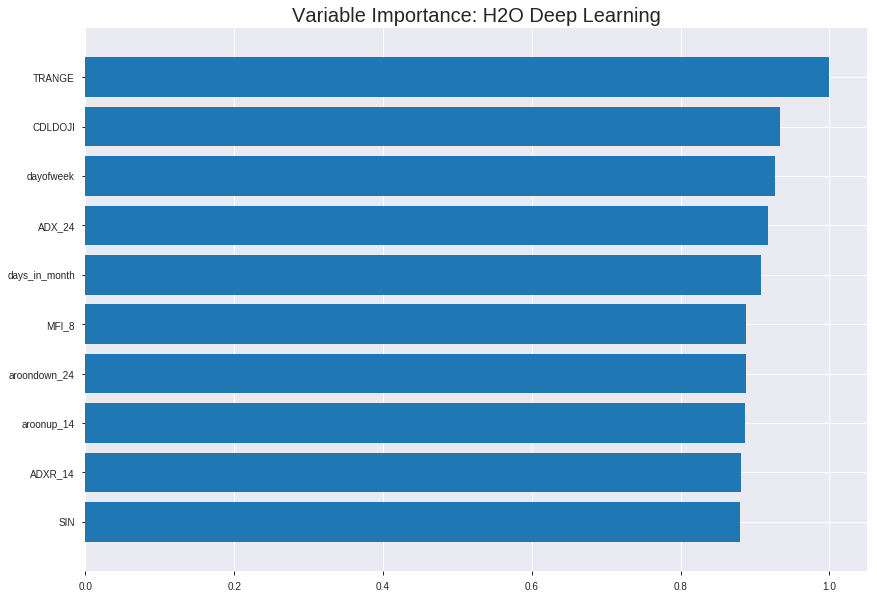

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_010220_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2356240101185391
RMSE: 0.48541117634283937
LogLoss: 0.6639589765907534
Mean Per-Class Error: 0.39423330206467877
AUC: 0.63568416763789
pr_auc: 0.6685234527647204
Gini: 0.2713683352757801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.387547870801903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   597   0.9402   (597.0/635.0)
1      10   821   0.012    (10.0/831.0)
Total  48   1418  0.4141   (607.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387548     0.730102  368
max f2                       0.328329     0.868019  390
max f0point5                 0.520695     0.660421  220
max accuracy                 0.497419     0.622783  255
max precision                0.779819     1         0
max recall                   0.30225      1         396
max specificity              0.779819     1         0
max absolute_mcc             0.520695     0.213566  220
max min_per_class_accuracy   0.531438     0.598425  201
max mean_per_class_accuracy  0.520695     0.605767  220

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.719567           1.2937    1.2937             0.733333         0.742147  0.733333                    0.742147            0.0132371       0.0132371                  29.3702   29.3702
    2        0.0204638                   0.685403           1.2937    1.2937             0.733333         0.699657  0.733333                    0.720902            0.0132371       0.0264741                  29.3702   29.3702
    3        0.0300136                   0.671848           1.2601    1.28301            0.714286         0.678221  0.727273                    0.707322            0.0120337       0.0385078                  26.01     28.3011
    4        0.0402456                   0.657672           1.41131   1.31563            0.8              0.665537  0.745763                    0.696699            0.0144404       0.0529483                  41.1312   31.563
    5        0.0504775                   0.647713           1.05848   1.26351            0.6              0.652226  0.716216                    0.687684            0.0108303       0.0637786                  5.84838   26.3505
    6        0.100273                    0.615967           1.25665   1.2601             0.712329         0.629771  0.714286                    0.658925            0.0625752       0.126354                   25.6647   26.01
    7        0.150068                    0.599356           1.32915   1.28301            0.753425         0.607088  0.727273                    0.641724            0.0661853       0.192539                   32.9146   28.3011
    8        0.200546                    0.581906           1.28735   1.2841             0.72973          0.590581  0.727891                    0.628851            0.0649819       0.257521                   28.7345   28.4102
    9        0.300136                    0.560649           1.06332   1.21084            0.60274          0.569668  0.686364                    0.609213            0.105897        0.363418                   6.3317    21.0841
    10       0.400409                    0.544238           1.09209   1.1811             0.619048         0.551781  0.669506                    0.594831            0.109507        0.472924                   9.20864   18.1102
    11       0.5                         0.532572           1.1479    1.17449            0.650685         0.538168  0.665757                    0.583545            0.11432         0.587244                   14.7899   17.4489
    12       0.600273                    0.520136           1.02008   1.1487             0.578231         0.526668  0.651136                    0.574044            0.102286        0.689531                   2.00807   14.8695
    13       0.699864                    0.4994             0.930402  1.11763            0.527397         0.509929  0.633528                    0.56492             0.0926594       0.78219                    -6.95976  11.7632
    14       0.800136                    0.476056           0.792063  1.07683            0.44898          0.488833  0.610401                    0.555385            0.0794224       0.861613                   -20.7937  7.6832
    15       0.899727                    0.443715           0.797488  1.04591            0.452055         0.461596  0.592873                    0.545003            0.0794224       0.941035                   -20.2512  4.59114
    16       1                           0.272643           0.588047  1                  0.333333         0.399422  0.566849                    0.530406            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25504753617631354
RMSE: 0.5050223125529342
LogLoss: 0.703411341322869
Mean Per-Class Error: 0.48861397479954183
AUC: 0.462348224513173
pr_auc: 0.5181223799519097
Gini: -0.07530355097365404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33684139521594114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    192  0.9897   (192.0/194.0)
1      0    225  0        (0.0/225.0)
Total  2    417  0.4582   (192.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336841     0.700935  397
max f2                       0.336841     0.854214  397
max f0point5                 0.336841     0.594295  397
max accuracy                 0.336841     0.541766  397
max precision                0.704687     1         0
max recall                   0.336841     1         397
max specificity              0.704687     1         0
max absolute_mcc             0.522363     0.107013  233
max min_per_class_accuracy   0.53334      0.453333  200
max mean_per_class_accuracy  0.597391     0.511386  43

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.685184           1.11733   1.11733            0.6              0.696107  0.6                         0.696107            0.0133333       0.0133333                  11.7333   11.7333
    2        0.0214797                   0.651181           1.39667   1.24148            0.75             0.667674  0.666667                    0.68347             0.0133333       0.0266667                  39.6667   24.1481
    3        0.0310263                   0.637994           0.465556  1.00274            0.25             0.643095  0.538462                    0.671047            0.00444444      0.0311111                  -53.4444  0.273504
    4        0.0405728                   0.630358           0.465556  0.87634            0.25             0.634563  0.470588                    0.662463            0.00444444      0.0355556                  -53.4444  -12.366
    5        0.0501193                   0.623266           0.931111  0.886772           0.5              0.627836  0.47619                     0.655867            0.00888889      0.0444444                  -6.88889  -11.3228
    6        0.100239                    0.597642           1.24148   1.06413            0.666667         0.610948  0.571429                    0.633407            0.0622222       0.106667                   24.1481   6.4127
    7        0.150358                    0.586525           0.798095  0.97545            0.428571         0.592194  0.52381                     0.61967             0.04            0.146667                   -20.1905  -2.45503
    8        0.200477                    0.576685           0.798095  0.931111           0.428571         0.582742  0.5                         0.610438            0.04            0.186667                   -20.1905  -6.88889
    9        0.300716                    0.559002           1.01979   0.96067            0.547619         0.567084  0.515873                    0.595987            0.102222        0.288889                   1.97884   -3.93298
    10       0.400955                    0.544267           0.842434  0.931111           0.452381         0.551161  0.5                         0.58478             0.0844444       0.373333                   -15.7566  -6.88889
    11       0.501193                    0.53295            0.842434  0.913376           0.452381         0.5385    0.490476                    0.575524            0.0844444       0.457778                   -15.7566  -8.66243
    12       0.599045                    0.520511           1.09008   0.94224            0.585366         0.526198  0.505976                    0.567467            0.106667        0.564444                   9.00813   -5.77601
    13       0.699284                    0.505507           1.10847   0.966068           0.595238         0.512816  0.518771                    0.559633            0.111111        0.675556                   10.8466   -3.39325
    14       0.799523                    0.485483           1.10847   0.98392            0.595238         0.497668  0.528358                    0.551864            0.111111        0.786667                   10.8466   -1.60796
    15       0.899761                    0.455826           1.06413   0.992856           0.571429         0.472325  0.533156                    0.543003            0.106667        0.893333                   6.4127    -0.714412
    16       1                           0.326613           1.06413   1                  0.571429         0.417707  0.536993                    0.5304


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:05:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:05:44  1 min 25.453 sec  869 obs/sec       1.39018   1             2038       0.563522         0.908271            -0.293349      0.549484        0.606409           1.17609          0.431105                         0.595962           1.03321               -0.4285          0.495922          0.547287             1.48978            0.463007
    2019-09-06 01:05:51  1 min 31.607 sec  1757 obs/sec      9.61119   7             14090      0.485411         0.663959            0.0403503      0.635684        0.668523           1.2937           0.414052                         0.505022           0.703411              -0.0258053       0.462348          0.518122             1.11733            0.458234
    2019-09-06 01:05:56  1 min 37.214 sec  1993 obs/sec      17.8902   13            26227      0.477309         0.647002            0.0721171      0.660993        0.70436            1.64653          0.377899                         0.51021            0.716551              -0.0469886       0.472955          0.520162             1.11733            0.458234
    2019-09-06 01:06:02  1 min 42.673 sec  2331 obs/sec      28.882    21            42341      0.476826         0.644644            0.0739955      0.695787        0.740043           1.64653          0.358799                         0.522536           0.746219              -0.0981883       0.468763          0.507475             0.372444           0.458234
    2019-09-06 01:06:07  1 min 48.027 sec  2533 obs/sec      39.8377   29            58402      0.45769          0.605461            0.146831       0.740889        0.781162           1.76414          0.339018                         0.510062           0.720149              -0.0463815       0.532818          0.532667             0.372444           0.448687
    2019-09-06 01:06:12  1 min 53.255 sec  2678 obs/sec      50.7988   37            74471      0.443788         0.576211            0.19787        0.775608        0.813197           1.76414          0.306958                         0.518575           0.747462              -0.0816006       0.53496           0.547073             0.372444           0.460621
    2019-09-06 01:06:17  1 min 58.558 sec  2778 obs/sec      61.8199   45            90628      0.429858         0.54768             0.247436       0.808324        0.83873            1.76414          0.277626                         0.521808           0.762867              -0.0951286       0.533918          0.549746             0.372444           0.463007
    2019-09-06 01:06:18  1 min 59.037 sec  2777 obs/sec      61.8199   45            90628      0.485411         0.663959            0.0403503      0.635684        0.668523           1.2937           0.414052                         0.505022           0.703411              -0.0258053       0.462348          0.518122             1.11733            0.458234

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
TRANGE             1.0                    1.0                  0.0233091048424633
CDLDOJI            0.9339984655380249     0.9339984655380249   0.02177066815592567
dayofweek          0.9262471199035645     0.9262471199035645   0.02158999122786186
ADX_24             0.9167935848236084     0.9167935848236084   0.02136963778755126
days_in_month      0.9073985815048218     0.9073985815048218   0.021150648670198374
---                ---                    ---                  ---
MACDFIX_signal_12  0.8186943531036377     0.8186943531036377   0.01908303251042536
week               0.8085950016975403     0.8085950016975403   0.018847625669659758
CMO_20             0.8065897822380066     0.8065897822380066   0.01880088579904534
AROONOSC_20        0.8001960515975952     0.8001960515975952   0.01865185366121352
WILLR_24           0.7845534682273865     0.7845534682273865   0.018287239045430354


See the whole table with table.as_data_frame()


('accuracy', 0.5571428571428572)

('F1', 0.7062499999999999)

('auc', 0.5269592190493568)

('logloss', 0.693481802439504)

('mean_per_class_error', 0.43413009761883037)

('rmse', 0.5001661758605983)

('mse', 0.250166203475015)

deeplearning prediction progress: |███████████████████████████████████████| 100%


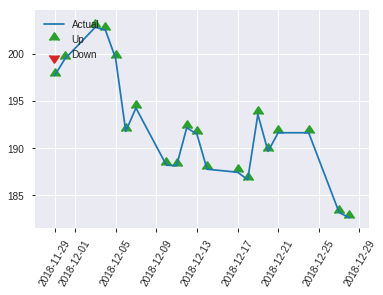


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.250166203475015
RMSE: 0.5001661758605983
LogLoss: 0.693481802439504
Mean Per-Class Error: 0.43413009761883037
AUC: 0.5269592190493568
pr_auc: 0.5548920054310199
Gini: 0.05391843809871366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3632345006872527: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    94   0.9691   (94.0/97.0)
1      0    113  0        (0.0/113.0)
Total  3    207  0.4476   (94.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363235     0.70625   206
max f2                       0.363235     0.85736   206
max f0point5                 0.363235     0.600425  206
max accuracy                 0.54383      0.557143  81
max precision                0.61766      0.647059  16
max recall                   0.363235     1         206
max specificity              0.662532     0.989691  0
max absolute_mcc             0.54383      0.134626  81
max min_per_class_accuracy   0.529624     0.536082  105
max mean_per_class_accuracy  0.54383      0.56587   81

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.654036           0.619469  0.619469           0.333333         0.658034  0.333333                    0.658034            0.00884956      0.00884956                 -38.0531  -38.0531
    2        0.0238095                   0.644419           0.929204  0.743363           0.5              0.649212  0.4                         0.654505            0.00884956      0.0176991                  -7.07965  -25.6637
    3        0.0333333                   0.6381             0.929204  0.79646            0.5              0.638297  0.428571                    0.649874            0.00884956      0.0265487                  -7.07965  -20.354
    4        0.0428571                   0.633529           1.85841   1.03245            1                0.63704   0.555556                    0.647022            0.0176991       0.0442478                  85.8407   3.24484
    5        0.052381                    0.62683            0.929204  1.01368            0.5              0.628011  0.545455                    0.643566            0.00884956      0.0530973                  -7.07965  1.36766
    6        0.1                         0.609225           1.30088   1.15044            0.7              0.618084  0.619048                    0.631431            0.0619469       0.115044                   30.0885   15.0442
    7        0.152381                    0.590625           0.84473   1.04535            0.454545         0.6006    0.5625                      0.620833            0.0442478       0.159292                   -15.527   4.5354
    8        0.2                         0.57961            0.743363  0.973451           0.4              0.584024  0.52381                     0.612069            0.0353982       0.19469                    -25.6637  -2.65487
    9        0.3                         0.560867           1.23894   1.06195            0.666667         0.570611  0.571429                    0.59825             0.123894        0.318584                   23.8938   6.19469
    10       0.4                         0.542787           1.41593   1.15044            0.761905         0.551411  0.619048                    0.58654             0.141593        0.460177                   41.5929   15.0442
    11       0.5                         0.529677           0.707965  1.06195            0.380952         0.536705  0.571429                    0.576573            0.0707965       0.530973                   -29.2035  6.19469
    12       0.6                         0.514619           0.619469  0.988201           0.333333         0.522081  0.531746                    0.567491            0.0619469       0.59292                    -38.0531  -1.17994
    13       0.7                         0.496426           1.15044   1.01138            0.619048         0.50675   0.544218                    0.558814            0.115044        0.707965                   15.0442   1.1378
    14       0.8                         0.479026           0.973451  1.00664            0.52381          0.487965  0.541667                    0.549958            0.0973451       0.80531                    -2.65487  0.663717
    15       0.9                         0.452303           0.79646   0.983284           0.428571         0.467965  0.529101                    0.540847            0.079646        0.884956                   -20.354   -1.67158
    16       1                           0.290706           1.15044   1                  0.619048         0.397812  0.538095                    0.526544     

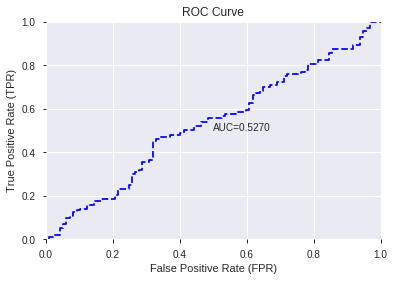

This function is available for GLM models only


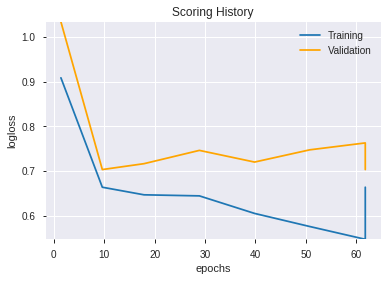

--2019-09-06 01:09:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_010220_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_010220_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLDOJI',
 'dayofweek',
 'ADX_24',
 'days_in_month',
 'MFI_8',
 'aroondown_24',
 'aroonup_14',
 'ADXR_14',
 'SIN',
 'COS',
 'DX_14',
 'MFI_12',
 'STOCHRSI_fastd',
 'weekday',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'MFI_20',
 'aroondown_8',
 'AD',
 'weekday_name',
 'quarter',
 'STOCH_slowk',
 'STOCH_slowd',
 'OBV',
 'aroondown_30',
 'STOCHF_fastd',
 'MFI_14',
 'NATR_30',
 'DX_12',
 'month',
 'STDDEV_12',
 'WILLR_8',
 'TRIX_8',
 'AROONOSC_30',
 'SAREXT',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastk',
 'MFI_24',
 'MFI_30',
 'ULTOSC',
 'AROONOSC_8',
 'aroonup_8',
 'NATR_12',
 'dayofyear',
 'MACDFIX_signal_12',
 'week',
 'CMO_20',
 'AROONOSC_20',
 'WILLR_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_010934_model_1  0.539276  0.690302                   0.5  0.498581  0.248583

variable  relative_importance  scaled_importance  percentage
0              ADX_24             0.008548           1.000000    0.051089
1             ADXR_14             0.008547           0.999914    0.051084
2             weekday             0.008233           0.963213    0.049209
3           dayofweek             0.008230           0.962826    0.049190
4      STOCHRSI_fastd             0.007499           0.877281    0.044819
5             CDLDOJI             0.006703           0.784212    0.040064
6        STOCHF_fastk             0.006278           0.734506    0.037525
7         STOCH_slowk             0.006175           0.722379    0.036905
8        STOCHF_fastd             0.006166           0.721394    0.036855
9              TRANGE             0.005861           0.685683    0.035031
10            NATR_12             0.005633           0.659059    0.033671
11              DX_14             0.005340           0.624750    0.031918
12     STOCHRSI_fastk             0.005091           0.595615    0.030429
13              DX_12             0.004746           0.555240    0.028367
14            NATR_30             0.004726           0.552892    0.028247
15        STOCH_slowd             0.004260           0.498362    0.025461
16          dayofyear             0.004109           0.480751    0.024561
17          aroonup_8             0.004082           0.477509    0.024395
18             ULTOSC             0.003787           0.443096    0.022637
19  LINEARREG_ANGLE_8             0.003705           0.433427    0.022143
20              month             0.003682           0.430749    0.022006
21               week             0.003551           0.415475    0.021226
22            quarter             0.003272           0.382787    0.019556
23            WILLR_8             0.003252           0.380504    0.019440
24             MFI_20             0.003026           0.353967    0.018084
25       weekday_name             0.002848           0.333141    0.017020
26                COS             0.002701           0.316039    0.016146
27              MFI_8             0.002627           0.307313    0.015700
28       aroondown_24             0.002456           0.287279    0.014677
29         AROONOSC_8             0.002222           0.259937    0.013280
30             MFI_30             0.002220           0.259709    0.013268
31           WILLR_24             0.002178           0.254769    0.013016
32       aroondown_30             0.002071           0.242281    0.012378
33             MFI_24             0.001963           0.229713    0.011736
34  MACDFIX_signal_12             0.001687           0.197416    0.010086
35         aroonup_14             0.001557           0.182139    0.009305
36             SAREXT             0.001459           0.170684    0.008720
37             TRIX_8             0.001216           0.142294    0.007270
38      days_in_month             0.001183           0.138378    0.007070
39                 AD             0.001071           0.125264    0.006400
40             MFI_12             0.000978           0.114379    0.005843
41             MFI_14             0.000745           0.087110    0.004450
42             CMO_20             0.000348           0.040741    0.002081
43                SIN             0.000348           0.040706    0.002080
44        AROONOSC_30             0.000245           0.028628    0.001463
45        aroondown_8             0.000215           0.025191    0.001287
46          STDDEV_12             0.000167           0.019551    0.000999
47                OBV             0.000125           0.014612    0.000746
48       MACDEXT_hist             0.000100           0.011730    0.000599
49        AROONOSC_20             0.000078           0.009162    0.000468

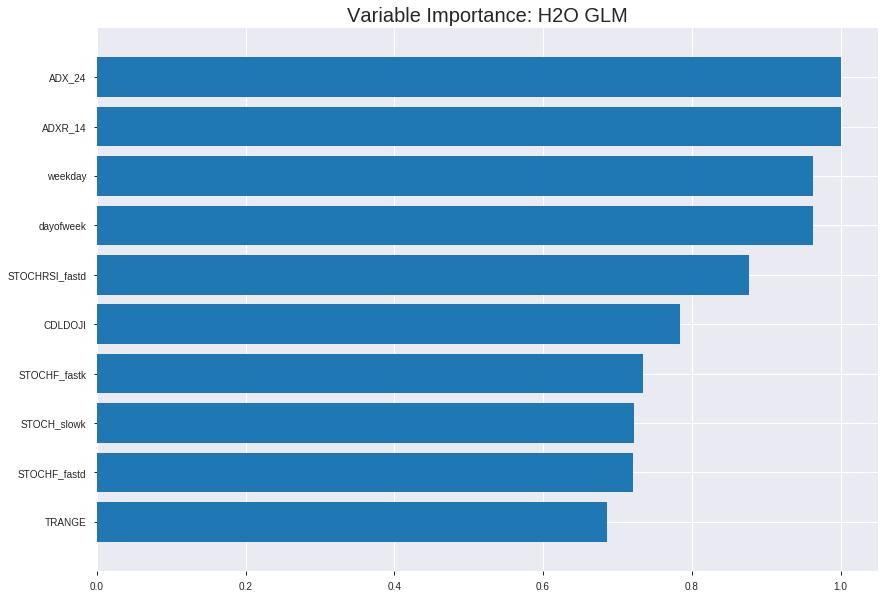

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_010934_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2437491671099111
RMSE: 0.49370959795198543
LogLoss: 0.6805547894360208
Null degrees of freedom: 1465
Residual degrees of freedom: 1415
Null deviance: 2006.0242636899413
Residual deviance: 1995.3866426264128
AIC: 2097.386642626413
AUC: 0.5821304376664108
pr_auc: 0.6295115972628639
Gini: 0.16426087533282163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5453786053946486: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      52   583   0.9181   (583.0/635.0)
1      28   803   0.0337   (28.0/831.0)
Total  80   1386  0.4168   (611.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.545379     0.724402  350
max f2                       0.493866     0.867432  399
max f0point5                 0.553271     0.636838  303
max accuracy                 0.553271     0.593452  303
max precision                0.603651     1         0
max recall                   0.493866     1         399
max specificity              0.603651     1         0
max absolute_mcc             0.553271     0.132112  303
max min_per_class_accuracy   0.566019     0.55716   205
max mean_per_class_accuracy  0.567358     0.565989  196

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.59616            1.2937    1.2937             0.733333         0.598118  0.733333                    0.598118            0.0132371       0.0132371                  29.3702    29.3702
    2        0.0204638                   0.594058           1.2937    1.2937             0.733333         0.595081  0.733333                    0.596599            0.0132371       0.0264741                  29.3702    29.3702
    3        0.0300136                   0.592029           1.38611   1.3231             0.785714         0.592878  0.75                        0.595415            0.0132371       0.0397112                  38.611     32.3105
    4        0.0402456                   0.590704           1.17609   1.28573            0.666667         0.591477  0.728814                    0.594414            0.0120337       0.0517449                  17.6093    28.5729
    5        0.0504775                   0.589841           1.17609   1.26351            0.666667         0.590306  0.716216                    0.593581            0.0120337       0.0637786                  17.6093    26.3505
    6        0.100273                    0.585239           1.06332   1.16409            0.60274          0.587309  0.659864                    0.590466            0.0529483       0.116727                   6.3317     16.4092
    7        0.150068                    0.581884           1.15998   1.16273            0.657534         0.583657  0.659091                    0.588207            0.0577617       0.174489                   15.9982    16.2728
    8        0.200546                    0.579075           1.14431   1.15809            0.648649         0.580452  0.656463                    0.586255            0.0577617       0.23225                    14.4307    15.8092
    9        0.300136                    0.574924           1.03915   1.11862            0.589041         0.577007  0.634091                    0.583186            0.10349         0.33574                    3.91507    11.8625
    10       0.400409                    0.570625           1.15209   1.12701            0.653061         0.572812  0.638842                    0.580588            0.115523        0.451264                   15.2091    12.7006
    11       0.5                         0.566261           0.978735  1.09747            0.554795         0.568573  0.622101                    0.578195            0.0974729       0.548736                   -2.1265    9.74729
    12       0.600273                    0.562785           0.984078  1.07853            0.557823         0.564477  0.611364                    0.575903            0.0986763       0.647413                   -1.59221   7.85308
    13       0.699864                    0.559076           0.990818  1.06605            0.561644         0.560853  0.604288                    0.573762            0.0986763       0.746089                   -0.918187  6.60493
    14       0.800136                    0.555026           0.972077  1.05427            0.55102          0.557122  0.597613                    0.571677            0.0974729       0.843562                   -2.79231   5.42727
    15       0.899727                    0.549374           0.869987  1.03387            0.493151         0.552333  0.58605                     0.569535            0.0866426       0.930205                   -13.0013   3.38741
    16       1                           0.493866           0.696055  1                  0.394558         0.54274   0.566849                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24970090085901855
RMSE: 0.49970081134516736
LogLoss: 0.6925759143293971
Null degrees of freedom: 418
Residual degrees of freedom: 368
Null deviance: 580.0755282349307
Residual deviance: 580.3786162080348
AIC: 682.3786162080348
AUC: 0.4948453608247423
pr_auc: 0.554261570994605
Gini: -0.010309278350515427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5394346289689413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    187  0.9639   (187.0/194.0)
1      3    222  0.0133   (3.0/225.0)
Total  10   409  0.4535   (190.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539435     0.700315  389
max f2                       0.533128     0.852919  399
max f0point5                 0.539435     0.596454  389
max accuracy                 0.539435     0.546539  389
max precision                0.594746     1         0
max recall                   0.533128     1         399
max specificity              0.594746     1         0
max absolute_mcc             0.586248     0.10361   20
max min_per_class_accuracy   0.568223     0.489691  201
max mean_per_class_accuracy  0.580926     0.526586  51

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 56.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0119332                   0.589969           1.11733   1.11733            0.6              0.591351  0.6                         0.591351            0.0133333       0.0133333                  11.7333     11.7333
    2        0.0214797                   0.588604           1.39667   1.24148            0.75             0.58932   0.666667                    0.590448            0.0133333       0.0266667                  39.6667     24.1481
    3        0.0310263                   0.587336           1.86222   1.43248            1                0.587904  0.769231                    0.589665            0.0177778       0.0444444                  86.2222     43.2479
    4        0.0405728                   0.586846           0.931111  1.31451            0.5              0.587144  0.705882                    0.589072            0.00888889      0.0533333                  -6.88889    31.451
    5        0.0501193                   0.585986           1.86222   1.41884            1                0.586558  0.761905                    0.588593            0.0177778       0.0711111                  86.2222     41.8836
    6        0.100239                    0.582508           0.97545   1.19714            0.52381          0.584271  0.642857                    0.586432            0.0488889       0.12                       -2.45503    19.7143
    7        0.150358                    0.579451           0.97545   1.12325            0.52381          0.580913  0.603175                    0.584592            0.0488889       0.168889                   -2.45503    12.3245
    8        0.200477                    0.577212           0.798095  1.04196            0.428571         0.57809   0.559524                    0.582967            0.04            0.208889                   -20.1905    4.19577
    9        0.300716                    0.574271           0.931111  1.00501            0.5              0.576035  0.539683                    0.580656            0.0933333       0.302222                   -6.88889    0.500882
    10       0.400955                    0.571206           0.886772  0.97545            0.47619          0.572854  0.52381                     0.578706            0.0888889       0.391111                   -11.3228    -2.45503
    11       0.501193                    0.568223           1.01979   0.984317           0.547619         0.569718  0.528571                    0.576908            0.102222        0.493333                   1.97884     -1.56825
    12       0.599045                    0.564323           0.999241  0.986755           0.536585         0.566401  0.52988                     0.575192            0.0977778       0.591111                   -0.0758808  -1.32448
    13       0.699284                    0.560793           0.97545   0.985135           0.52381          0.562813  0.52901                     0.573417            0.0977778       0.688889                   -2.45503    -1.48654
    14       0.799523                    0.556164           0.931111  0.978362           0.5              0.558372  0.525373                    0.571531            0.0933333       0.782222                   -6.88889    -2.16385
    15       0.899761                    0.549605           1.10847   0.992856           0.595238         0.552875  0.533156                    0.569453            0.111111        0.893333                   10.8466     -0.714412
    16       1                           0.533128           1.06413   1                  0.571429         0.543918  0.53


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:09:35  0.000 sec   2            3.7       51            1.36111           1.38515
    2019-09-06 01:09:35  0.059 sec   4            2.3       51            1.35832           1.38599
    2019-09-06 01:09:35  0.112 sec   6            1.4       51            1.35507           1.38745
    2019-09-06 01:09:35  0.166 sec   8            0.89      51            1.35161           1.38964
    2019-09-06 01:09:35  0.223 sec   10           0.56      51            1.34818           1.39251

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5523809523809524)

('F1', 0.6996904024767803)

('auc', 0.5392756135389106)

('logloss', 0.6903015398451224)

('mean_per_class_error', 0.43568105099899646)

('rmse', 0.498580730078774)

('mse', 0.2485827444058833)

glm prediction progress: |████████████████████████████████████████████████| 100%


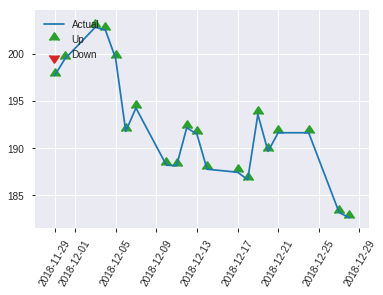


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2485827444058833
RMSE: 0.498580730078774
LogLoss: 0.6903015398451224
Null degrees of freedom: 209
Residual degrees of freedom: 159
Null deviance: 290.6054272050573
Residual deviance: 289.9266467349514
AIC: 391.9266467349514
AUC: 0.5392756135389106
pr_auc: 0.5823415312392587
Gini: 0.07855122707782125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5141211956013778: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514121     0.69969   209
max f2                       0.514121     0.853474  209
max f0point5                 0.546633     0.59887   192
max accuracy                 0.546633     0.552381  192
max precision                0.596292     1         0
max recall                   0.514121     1         209
max specificity              0.596292     1         0
max absolute_mcc             0.572382     0.141962  59
max min_per_class_accuracy   0.565674     0.522124  103
max mean_per_class_accuracy  0.572382     0.564319  59

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 56.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.595394           1.85841   1.85841            1                0.595973  1                           0.595973            0.0265487       0.0265487                  85.8407   85.8407
    2        0.0238095                   0.591532           0.929204  1.48673            0.5              0.592281  0.8                         0.594496            0.00884956      0.0353982                  -7.07965  48.6726
    3        0.0333333                   0.589336           0.929204  1.32743            0.5              0.589667  0.714286                    0.593116            0.00884956      0.0442478                  -7.07965  32.7434
    4        0.0428571                   0.586477           1.85841   1.44543            1                0.587858  0.777778                    0.591948            0.0176991       0.0619469                  85.8407   44.5428
    5        0.052381                    0.585339           0         1.18262            0                0.585724  0.636364                    0.590816            0               0.0619469                  -100      18.2623
    6        0.1                         0.579656           0.743363  0.973451           0.4              0.582624  0.52381                     0.586915            0.0353982       0.0973451                  -25.6637  -2.65487
    7        0.152381                    0.577031           1.52051   1.1615             0.818182         0.578314  0.625                       0.583959            0.079646        0.176991                   52.0515   16.1504
    8        0.2                         0.575107           1.11504   1.15044            0.6              0.576162  0.619048                    0.582102            0.0530973       0.230088                   11.5044   15.0442
    9        0.3                         0.571752           1.23894   1.17994            0.666667         0.573529  0.634921                    0.579245            0.123894        0.353982                   23.8938   17.9941
    10       0.4                         0.568412           0.884956  1.10619            0.47619          0.569888  0.595238                    0.576906            0.0884956       0.442478                   -11.5044  10.6195
    11       0.5                         0.565348           0.79646   1.04425            0.428571         0.566718  0.561905                    0.574868            0.079646        0.522124                   -20.354   4.42478
    12       0.6                         0.561699           0.884956  1.0177             0.47619          0.563718  0.547619                    0.57301             0.0884956       0.610619                   -11.5044  1.76991
    13       0.7                         0.55877            0.973451  1.01138            0.52381          0.560375  0.544218                    0.571205            0.0973451       0.707965                   -2.65487  1.1378
    14       0.8                         0.554203           0.973451  1.00664            0.52381          0.556625  0.541667                    0.569382            0.0973451       0.80531                    -2.65487  0.663717
    15       0.9                         0.547796           1.06195   1.01278            0.571429         0.55095   0.544974                    0.567334            0.106195        0.911504                   6.19469   1.27827
    16       1                           0.514121           0.884956  1                  0.47619          0.540197  0.538095                    0.564621        

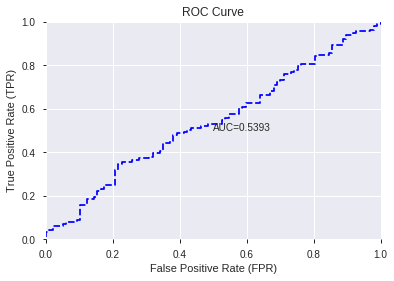

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


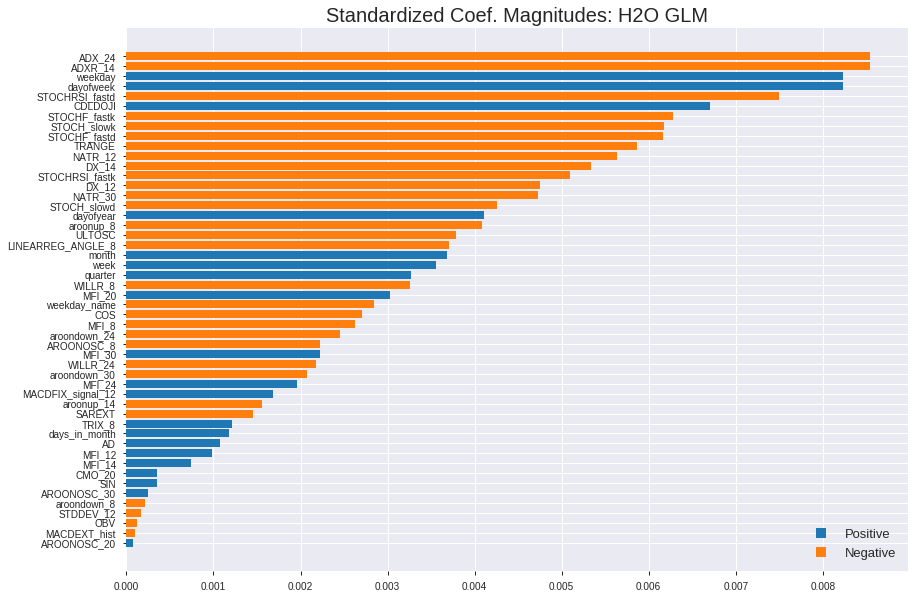

'log_likelihood'
--2019-09-06 01:09:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_010934_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_010934_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['ADX_24',
 'ADXR_14',
 'weekday',
 'dayofweek',
 'STOCHRSI_fastd',
 'CDLDOJI',
 'STOCHF_fastk',
 'STOCH_slowk',
 'STOCHF_fastd',
 'TRANGE',
 'NATR_12',
 'DX_14',
 'STOCHRSI_fastk',
 'DX_12',
 'NATR_30',
 'STOCH_slowd',
 'dayofyear',
 'aroonup_8',
 'ULTOSC',
 'LINEARREG_ANGLE_8',
 'month',
 'week',
 'quarter',
 'WILLR_8',
 'MFI_20',
 'weekday_name',
 'COS',
 'MFI_8',
 'aroondown_24',
 'AROONOSC_8',
 'MFI_30',
 'WILLR_24',
 'aroondown_30',
 'MFI_24',
 'MACDFIX_signal_12',
 'aroonup_14',
 'SAREXT',
 'TRIX_8',
 'days_in_month',
 'AD',
 'MFI_12',
 'MFI_14',
 'CMO_20',
 'SIN',
 'AROONOSC_30',
 'aroondown_8',
 'STDDEV_12',
 'OBV',
 'MACDEXT_hist',
 'AROONOSC_20']

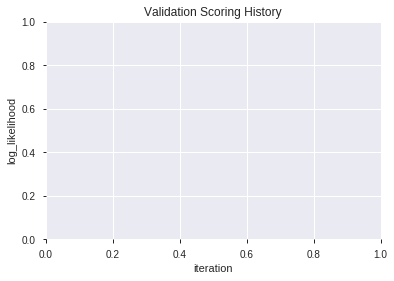

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_010951_model_7  0.530426  0.710854              0.500000  0.507487  0.257543
1  XGBoost_grid_1_AutoML_20190906_010951_model_6  0.524861  0.703183              0.494845  0.504651  0.254672
2               XGBoost_2_AutoML_20190906_010951  0.518840  0.704434              0.500000  0.505303  0.255331
3  XGBoost_grid_1_AutoML_20190906_010951_model_1  0.512271  0.719872              0.489691  0.512092  0.262238
4  XGBoost_grid_1_AutoML_20190906_010951_model_5  0.509534  0.733017              0.469072  0.516922  0.267208
5               XGBoost_1_AutoML_20190906_010951  0.508986  0.707450              0.500000  0.506787  0.256833
6  XGBoost_grid_1_AutoML_20190906_010951_model_2  0.507344  0.703366              0.500000  0.504783  0.254806
7  XGBoost_grid_1_AutoML_20190906_010951_model_4  0.498860  0.701896              0.489691  0.504094  0.254111
8               XGBoost_3_AutoML_20190906_010951  0.496123  0.711418              0.494116  0.508608  0.258682
9  XGBoost_grid_1_AutoML_20190906_010951_model_3  0.485631  0.715765              0.500000  0.510748  0.260864

variable  relative_importance  scaled_importance  percentage
0              TRANGE           331.779480           1.000000    0.046483
1           STDDEV_12           247.799500           0.746880    0.034717
2                 SIN           245.619919           0.740311    0.034412
3      STOCHRSI_fastd           233.452728           0.703638    0.032707
4                 COS           232.122086           0.699628    0.032521
5               MFI_8           223.729782           0.674333    0.031345
6        MACDEXT_hist           219.334930           0.661086    0.030729
7              MFI_12           213.081955           0.642240    0.029853
8   MACDFIX_signal_12           208.466812           0.628329    0.029206
9              TRIX_8           200.436066           0.604124    0.028081
10        STOCH_slowd           198.839127           0.599311    0.027858
11             ADX_24           197.144958           0.594205    0.027620
12  LINEARREG_ANGLE_8           194.396622           0.585921    0.027235
13            ADXR_14           187.539688           0.565254    0.026275
14                OBV           183.642822           0.553509    0.025729
15          dayofweek           183.114792           0.551917    0.025655
16          dayofyear           176.595169           0.532267    0.024741
17        STOCH_slowk           173.421188           0.522700    0.024297
18             SAREXT           172.160141           0.518899    0.024120
19             MFI_30           170.342712           0.513421    0.023865
20       aroondown_24           168.396805           0.507556    0.023593
21                 AD           167.269119           0.504158    0.023435
22              DX_14           165.836060           0.499838    0.023234
23           WILLR_24           165.640930           0.499250    0.023207
24             MFI_24           164.407501           0.495532    0.023034
25       STOCHF_fastk           155.902176           0.469897    0.021842
26             ULTOSC           142.189224           0.428565    0.019921
27            WILLR_8           136.587738           0.411682    0.019136
28            NATR_30           132.584946           0.399618    0.018575
29             CMO_20           132.484879           0.399316    0.018561
30            NATR_12           131.207169           0.395465    0.018382
31     STOCHRSI_fastk           128.427490           0.387087    0.017993
32              DX_12           123.545784           0.372373    0.017309
33             MFI_14           123.527473           0.372318    0.017306
34             MFI_20           120.336784           0.362701    0.016859
35        AROONOSC_20            98.903893           0.298101    0.013857
36       STOCHF_fastd            93.286873           0.281171    0.013070
37       aroondown_30            82.492462           0.248636    0.011557
38        AROONOSC_30            80.574402           0.242855    0.011289
39         aroonup_14            77.966362           0.234995    0.010923
40        aroondown_8            75.512238           0.227598    0.010579
41         AROONOSC_8            52.410641           0.157968    0.007343
42       weekday_name            49.501560           0.149200    0.006935
43               week            36.142391           0.108935    0.005064
44            weekday            32.607704           0.098281    0.004568
45            CDLDOJI            32.199657           0.097051    0.004511
46          aroonup_8            31.818981           0.095904    0.004458
47              month            25.867947           0.077967    0.003624
48      days_in_month            13.389488           0.040357    0.001876
49            quarter             3.649623           0.011000    0.000511

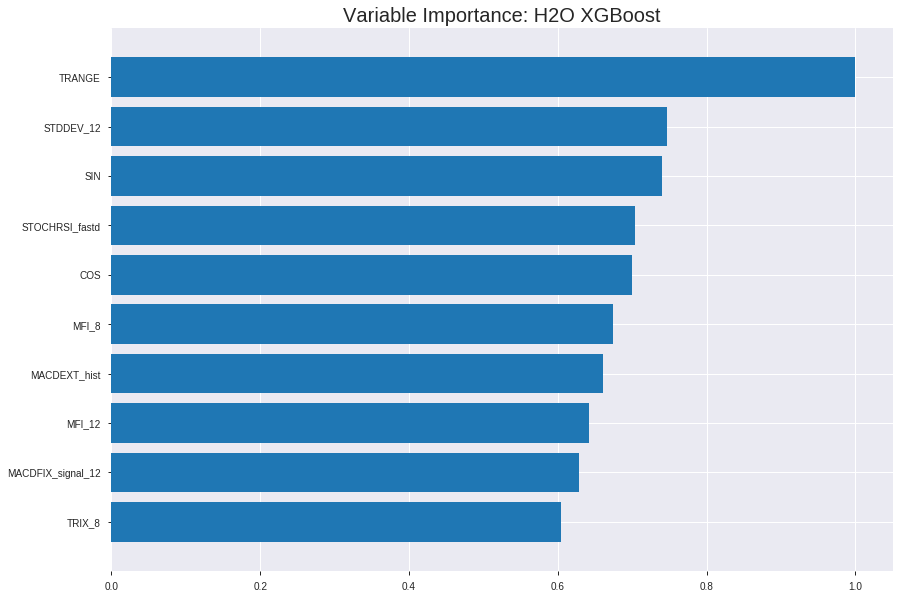

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_010951_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.144045741944487
RMSE: 0.3795335847385406
LogLoss: 0.46884351493827503
Mean Per-Class Error: 0.09519315500724868
AUC: 0.9692089030387446
pr_auc: 0.9754559926670741
Gini: 0.9384178060774893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5195895433425903: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      549  86   0.1354   (86.0/635.0)
1      54   777  0.065    (54.0/831.0)
Total  603  863  0.0955   (140.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51959      0.917355  217
max f2                       0.463734     0.947198  254
max f0point5                 0.596538     0.928144  165
max accuracy                 0.544838     0.904502  201
max precision                0.902119     1         0
max recall                   0.355578     1         326
max specificity              0.902119     1         0
max absolute_mcc             0.544838     0.806693  201
max min_per_class_accuracy   0.544838     0.902527  201
max mean_per_class_accuracy  0.544838     0.904807  201

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 55.90 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.842975           1.76414    1.76414            1                0.869972  1                           0.869972            0.0180505       0.0180505                  76.414    76.414
    2        0.0204638                   0.823325           1.76414    1.76414            1                0.829876  1                           0.849924            0.0180505       0.0361011                  76.414    76.414
    3        0.0300136                   0.806161           1.76414    1.76414            1                0.813216  1                           0.838244            0.0168472       0.0529483                  76.414    76.414
    4        0.0402456                   0.796445           1.76414    1.76414            1                0.801071  1                           0.828793            0.0180505       0.0709988                  76.414    76.414
    5        0.0504775                   0.78926            1.76414    1.76414            1                0.793452  1                           0.82163             0.0180505       0.0890493                  76.414    76.414
    6        0.100273                    0.754806           1.76414    1.76414            1                0.769911  1                           0.795946            0.087846        0.176895                   76.414    76.414
    7        0.150068                    0.732888           1.76414    1.76414            1                0.743923  1                           0.778684            0.087846        0.264741                   76.414    76.414
    8        0.200546                    0.713594           1.76414    1.76414            1                0.721678  1                           0.764335            0.0890493       0.353791                   76.414    76.414
    9        0.300136                    0.67205            1.73997    1.75612            0.986301         0.69171   0.995455                    0.740237            0.173285        0.527076                   73.9973   75.6121
    10       0.400409                    0.627516           1.70413    1.7431             0.965986         0.652939  0.988075                    0.718375            0.170878        0.697954                   70.4135   74.3102
    11       0.5                         0.576145           1.37748    1.67028            0.780822         0.601058  0.946794                    0.695008            0.137184        0.835138                   37.7479   67.0277
    12       0.600273                    0.510792           1.04408    1.56567            0.591837         0.544667  0.8875                      0.669894            0.104693        0.939832                   4.40826   56.5674
    13       0.699864                    0.451364           0.519575   1.41681            0.294521         0.483143  0.803119                    0.643319            0.0517449       0.991576                   -48.0425  41.6814
    14       0.800136                    0.404495           0.0600047  1.24678            0.0340136        0.426425  0.706735                    0.616138            0.00601685      0.997593                   -93.9995  24.6779
    15       0.899727                    0.340886           0.0241663  1.11145            0.0136986        0.371201  0.630023                    0.589026            0.00240674      1                          -97.5834  11.1448
    16       1                           0.201616           0          1                  0                0.290069  0.566849                    0.55904



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25696351744200485
RMSE: 0.5069156906646359
LogLoss: 0.7084278049820708
Mean Per-Class Error: 0.467434135166094
AUC: 0.5123596792668957
pr_auc: 0.5347569408375623
Gini: 0.02471935853379148
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28617435693740845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.286174     0.698758   399
max f2                       0.286174     0.852919   399
max f0point5                 0.369723     0.59294    377
max accuracy                 0.459107     0.541766   289
max precision                0.809279     1          0
max recall                   0.286174     1          399
max specificity              0.809279     1          0
max absolute_mcc             0.711191     0.0822878  12
max min_per_class_accuracy   0.51952      0.502222   195
max mean_per_class_accuracy  0.545383     0.532566   159

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0119332                   0.753563           0.744889  0.744889           0.4              0.774436  0.4                         0.774436            0.00888889      0.00888889                 -25.5111    -25.5111
    2        0.0214797                   0.730321           0.931111  0.827654           0.5              0.739695  0.444444                    0.758995            0.00888889      0.0177778                  -6.88889    -17.2346
    3        0.0310263                   0.70976            0         0.572991           0                0.722009  0.307692                    0.747615            0               0.0177778                  -100        -42.7009
    4        0.0405728                   0.692723           0.931111  0.657255           0.5              0.701931  0.352941                    0.736866            0.00888889      0.0266667                  -6.88889    -34.2745
    5        0.0501193                   0.679485           1.39667   0.798095           0.75             0.686529  0.428571                    0.727278            0.0133333       0.04                       39.6667     -20.1905
    6        0.100239                    0.650207           1.06413   0.931111           0.571429         0.662483  0.5                         0.69488             0.0533333       0.0933333                  6.4127      -6.88889
    7        0.150358                    0.622366           1.06413   0.97545            0.571429         0.636173  0.52381                     0.675311            0.0533333       0.146667                   6.4127      -2.45503
    8        0.200477                    0.610042           1.06413   0.997619           0.571429         0.615984  0.535714                    0.660479            0.0533333       0.2                        6.4127      -0.238095
    9        0.300716                    0.576618           1.19714   1.06413            0.642857         0.589846  0.571429                    0.636935            0.12            0.32                       19.7143     6.4127
    10       0.400955                    0.545228           1.10847   1.07521            0.595238         0.562993  0.577381                    0.618449            0.111111        0.431111                   10.8466     7.52116
    11       0.501193                    0.517162           0.709418  1.00205            0.380952         0.532625  0.538095                    0.601284            0.0711111       0.502222                   -29.0582    0.205291
    12       0.599045                    0.492651           0.999241  1.00159            0.536585         0.503534  0.537849                    0.585317            0.0977778       0.6                        -0.0758808  0.159363
    13       0.699284                    0.469749           1.1528    1.02327            0.619048         0.480712  0.549488                    0.570323            0.115556        0.715556                   15.2804     2.32689
    14       0.799523                    0.436454           0.842434  1.0006             0.452381         0.454061  0.537313                    0.555747            0.0844444       0.8                        -15.7566    0.0597015
    15       0.899761                    0.402956           0.931111  0.992856           0.5              0.420483  0.533156                    0.540677            0.0933333       0.893333                   -6.88889    -0.714412
    16       1                           0.286174           1.06413   1                  0.571429         0.35796


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:10:08  5.884 sec   0                  0.5              0.693147            0.5             0                  1                0.433151                         0.5                0.693147              0.5               0                    1                  0.463007
    2019-09-06 01:10:08  5.962 sec   5                  0.482101         0.657865            0.808102        0.837479           1.76414          0.268076                         0.500076           0.693306              0.512291          0.537444             0.744889           0.460621
    2019-09-06 01:10:08  6.026 sec   10                 0.465762         0.626404            0.870072        0.889513           1.76414          0.204638                         0.50161            0.696395              0.499782          0.540002             1.11733            0.460621
    2019-09-06 01:10:08  6.111 sec   15                 0.451406         0.599173            0.898196        0.918125           1.76414          0.183492                         0.501955           0.697102              0.501008          0.540025             0.744889           0.455847
    2019-09-06 01:10:08  6.186 sec   20                 0.437471         0.573089            0.922409        0.936025           1.76414          0.149386                         0.503725           0.700744              0.491569          0.531968             1.11733            0.460621
    2019-09-06 01:10:08  6.252 sec   25                 0.425239         0.550517            0.935029        0.946553           1.76414          0.146658                         0.503922           0.701259              0.496094          0.53235              1.11733            0.460621
    2019-09-06 01:10:08  6.321 sec   30                 0.415481         0.532647            0.94056         0.952438           1.76414          0.132333                         0.503291           0.700196              0.514742          0.538151             0.744889           0.458234
    2019-09-06 01:10:08  6.393 sec   35                 0.406041         0.515334            0.94511         0.957124           1.76414          0.139836                         0.503772           0.701323              0.517835          0.539919             1.11733            0.463007
    2019-09-06 01:10:08  6.471 sec   40                 0.397695         0.500487            0.953858        0.963499           1.76414          0.117326                         0.504093           0.702012              0.518018          0.54409              1.11733            0.463007
    2019-09-06 01:10:08  6.540 sec   45                 0.388544         0.484435            0.96145         0.969516           1.76414          0.109141                         0.506274           0.706858              0.510733          0.537521             1.11733            0.460621
    2019-09-06 01:10:08  6.620 sec   50                 0.379534         0.468844            0.969209        0.975456           1.76414          0.095498                         0.506916           0.708428              0.51236           0.534757             0.744889           0.463007

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
TRANGE          331.77947998046875     1.0                   0.046482760785391895
STDDEV_12       247.79949951171875     0.7468801250948559    0.034717050190147765
SIN             245.6199188232422      0.7403107595373329    0.034411687942425634
STOCHRSI_fastd  233.45272827148438     0.7036382367144204    0.03270704783665136
COS             232.12208557128906     0.6996276128498172    0.03252062296695282
---             ---                    ---                   ---
CDLDOJI         32.19965744018555      0.09705138317198243   0.004511216227874668
aroonup_8       31.818981170654297     0.09590400579483524   0.004457882959722164
month           25.86794662475586      0.07796728907489595   0.003624134847153887
days_in_month   13.389488220214844     0.04035658932554557   0.0018758856877336345
quarter         3.649622917175293      0.011000146595534298  0.0005113171828044638


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5571428571428572)

('F1', 0.6996904024767803)

('auc', 0.5304260560167868)

('logloss', 0.7108536288527836)

('mean_per_class_error', 0.4453060852112034)

('rmse', 0.5074872735120983)

('mse', 0.25754333277674335)

xgboost prediction progress: |████████████████████████████████████████████| 100%


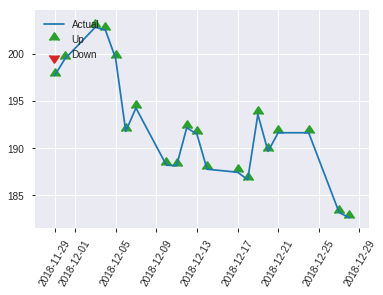


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25754333277674335
RMSE: 0.5074872735120983
LogLoss: 0.7108536288527836
Mean Per-Class Error: 0.4453060852112034
AUC: 0.5304260560167868
pr_auc: 0.5569029669787015
Gini: 0.06085211203357366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23912900686264038: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239129     0.69969   209
max f2                       0.239129     0.853474  209
max f0point5                 0.436188     0.597898  161
max accuracy                 0.436188     0.557143  161
max precision                0.621688     0.659574  46
max recall                   0.239129     1         209
max specificity              0.797835     0.989691  0
max absolute_mcc             0.348449     0.162321  199
max min_per_class_accuracy   0.516162     0.522124  102
max mean_per_class_accuracy  0.621688     0.554694  46

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.768359           0.619469  0.619469           0.333333         0.780585  0.333333                    0.780585            0.00884956      0.00884956                 -38.0531  -38.0531
    2        0.0238095                   0.758924           0.929204  0.743363           0.5              0.761342  0.4                         0.772888            0.00884956      0.0176991                  -7.07965  -25.6637
    3        0.0333333                   0.752763           0.929204  0.79646            0.5              0.755113  0.428571                    0.767809            0.00884956      0.0265487                  -7.07965  -20.354
    4        0.0428571                   0.742621           0.929204  0.825959           0.5              0.746742  0.444444                    0.763128            0.00884956      0.0353982                  -7.07965  -17.4041
    5        0.052381                    0.734149           0.929204  0.84473            0.5              0.737111  0.454545                    0.758397            0.00884956      0.0442478                  -7.07965  -15.527
    6        0.1                         0.682514           1.11504   0.973451           0.6              0.703894  0.52381                     0.732443            0.0530973       0.0973451                  11.5044   -2.65487
    7        0.152381                    0.658612           1.35157   1.10343            0.727273         0.671526  0.59375                     0.711503            0.0707965       0.168142                   35.1569   10.3429
    8        0.2                         0.635614           1.48673   1.19469            0.8              0.645533  0.642857                    0.695796            0.0707965       0.238938                   48.6726   19.469
    9        0.3                         0.590644           0.884956  1.09145            0.47619          0.611886  0.587302                    0.667826            0.0884956       0.327434                   -11.5044  9.14454
    10       0.4                         0.557596           1.15044   1.10619            0.619048         0.570932  0.595238                    0.643602            0.115044        0.442478                   15.0442   10.6195
    11       0.5                         0.510721           0.79646   1.04425            0.428571         0.533971  0.561905                    0.621676            0.079646        0.522124                   -20.354   4.42478
    12       0.6                         0.485435           0.707965  0.988201           0.380952         0.496485  0.531746                    0.600811            0.0707965       0.59292                    -29.2035  -1.17994
    13       0.7                         0.45815            1.06195   0.998736           0.571429         0.472983  0.537415                    0.58255             0.106195        0.699115                   6.19469   -0.126422
    14       0.8                         0.423929           1.15044   1.0177             0.619048         0.440784  0.547619                    0.564829            0.115044        0.814159                   15.0442   1.76991
    15       0.9                         0.388476           0.79646   0.993117           0.428571         0.407288  0.534392                    0.547324            0.079646        0.893805                   -20.354   -0.688299
    16       1                           0.239129           1.06195   1                  0.571429         0.338771  0.538095                    0.526469 

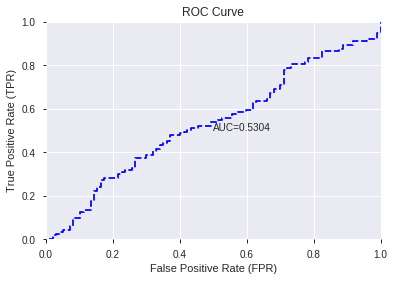

This function is available for GLM models only


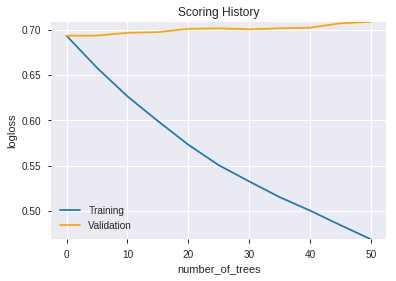

--2019-09-06 01:10:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_010951_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_010951_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['TRANGE',
 'STDDEV_12',
 'SIN',
 'STOCHRSI_fastd',
 'COS',
 'MFI_8',
 'MACDEXT_hist',
 'MFI_12',
 'MACDFIX_signal_12',
 'TRIX_8',
 'STOCH_slowd',
 'ADX_24',
 'LINEARREG_ANGLE_8',
 'ADXR_14',
 'OBV',
 'dayofweek',
 'dayofyear',
 'STOCH_slowk',
 'SAREXT',
 'MFI_30',
 'aroondown_24',
 'AD',
 'DX_14',
 'WILLR_24',
 'MFI_24',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_8',
 'NATR_30',
 'CMO_20',
 'NATR_12',
 'STOCHRSI_fastk',
 'DX_12',
 'MFI_14',
 'MFI_20',
 'AROONOSC_20',
 'STOCHF_fastd',
 'aroondown_30',
 'AROONOSC_30',
 'aroonup_14',
 'aroondown_8',
 'AROONOSC_8',
 'weekday_name',
 'week',
 'weekday',
 'CDLDOJI',
 'aroonup_8',
 'month',
 'days_in_month',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_011026_model_1  0.5  18.585151                   0.5  0.73355  0.538095

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             0.007575           1.000000    0.010520
1                      weekday             0.007288           0.962227    0.010123
2                    dayofweek             0.007285           0.961730    0.010118
3                       ADX_24             0.006818           0.900147    0.009470
4                      ADXR_14             0.006357           0.839284    0.008829
...                        ...                  ...                ...         ...
1038  BBANDS_middleband_24_0_5             0.000000           0.000000    0.000000
1039                    WMA_30             0.000000           0.000000    0.000000
1040  BBANDS_middleband_30_0_3             0.000000           0.000000    0.000000
1041  BBANDS_middleband_30_0_4             0.000000           0.000000    0.000000
1042  BBANDS_middleband_30_0_5             0.000000           0.000000    0.000000

[1043 rows x 4 columns]

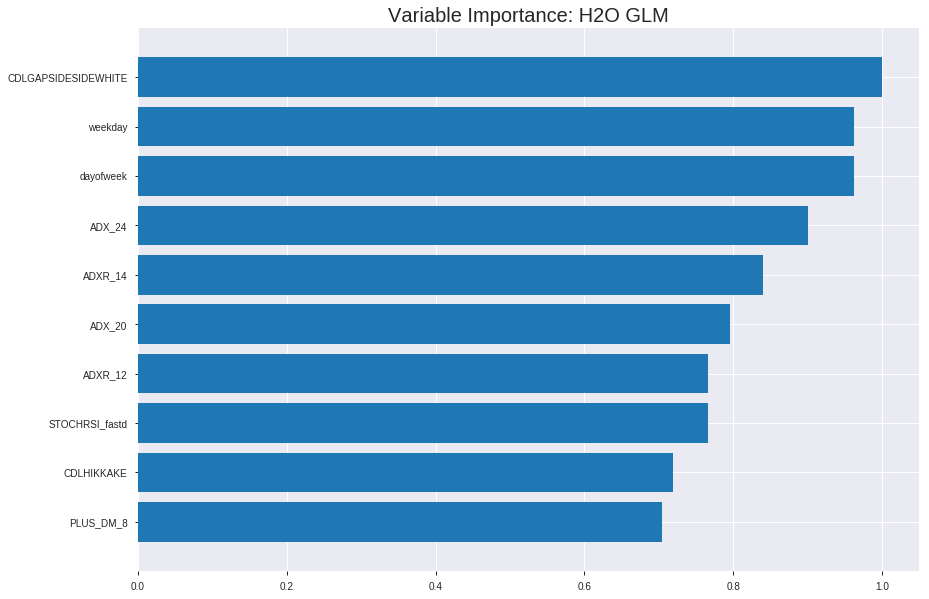

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_011026_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24068392184046514
RMSE: 0.49059547678353616
LogLoss: 0.6742913730914234
Null degrees of freedom: 1465
Residual degrees of freedom: 437
Null deviance: 2006.0242636899413
Residual deviance: 1977.0223059040534
AIC: 4035.0223059040536
AUC: 0.6039019490794697
pr_auc: 0.6591409344487275
Gini: 0.2078038981589394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48528813789835545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   623   0.9811   (623.0/635.0)
1      2    829   0.0024   (2.0/831.0)
Total  14   1452  0.4263   (625.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485288     0.726237  387
max f2                       0.422504     0.867976  396
max f0point5                 0.548072     0.639727  261
max accuracy                 0.548072     0.595498  261
max precision                0.641863     1         0
max recall                   0.422504     1         396
max specificity              0.641863     1         0
max absolute_mcc             0.586949     0.164515  117
max min_per_class_accuracy   0.568737     0.562205  188
max mean_per_class_accuracy  0.586113     0.576747  120

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.626471           1.64653   1.64653            0.933333         0.634157  0.933333                    0.634157            0.0168472       0.0168472                  64.653     64.653
    2        0.0204638                   0.622103           1.17609   1.41131            0.666667         0.623775  0.8                         0.628966            0.0120337       0.0288809                  17.6093    41.1312
    3        0.0300136                   0.618345           1.2601    1.3632             0.714286         0.619799  0.772727                    0.626049            0.0120337       0.0409146                  26.01      36.3199
    4        0.0402456                   0.615895           1.41131   1.37543            0.8              0.617355  0.779661                    0.623839            0.0144404       0.055355                   41.1312    37.5431
    5        0.0504775                   0.613553           1.17609   1.33502            0.666667         0.614537  0.756757                    0.621953            0.0120337       0.0673887                  17.6093    33.5025
    6        0.100273                    0.606059           1.23248   1.2841             0.69863          0.609603  0.727891                    0.61582             0.0613718       0.128761                   23.2481    28.4102
    7        0.150068                    0.599336           1.11165   1.22688            0.630137         0.602724  0.695455                    0.611475            0.055355        0.184116                   11.165     22.6879
    8        0.200546                    0.595509           1.14431   1.2061             0.648649         0.597573  0.683673                    0.607976            0.0577617       0.241877                   14.4307    20.6095
    9        0.300136                    0.587298           1.24456   1.21886            0.705479         0.591493  0.690909                    0.602506            0.123947        0.365824                   24.4564    21.886
    10       0.400409                    0.57713            0.996079  1.16307            0.564626         0.58247   0.659284                    0.597489            0.0998797       0.465704                   -0.392118  16.307
    11       0.5                         0.569217           0.869987  1.10469            0.493151         0.573193  0.626194                    0.59265             0.0866426       0.552347                   -13.0013   10.4693
    12       0.600273                    0.560523           1.09209   1.10259            0.619048         0.564876  0.625                       0.58801             0.109507        0.661853                   9.20864    10.2587
    13       0.699864                    0.551764           0.918319  1.07637            0.520548         0.556081  0.610136                    0.583467            0.0914561       0.753309                   -8.16808   7.63659
    14       0.800136                    0.540931           0.876069  1.05126            0.496599         0.546457  0.595908                    0.578829            0.087846        0.841155                   -12.3931   5.12648
    15       0.899727                    0.525933           0.84582   1.02852            0.479452         0.533848  0.583017                    0.57385             0.0842359       0.925391                   -15.418    2.85241
    16       1                           0.405254           0.744059  1                  0.421769         0.504028  0.566849                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.374579158355589
RMSE: 0.6120287234726725
LogLoss: 7.305051362471108
Null degrees of freedom: 418
Residual degrees of freedom: -610
Null deviance: 580.0755282349307
Residual deviance: 70114.40889507499
AIC: 72172.40889507499
AUC: 0.5547193585337915
pr_auc: 0.5676896716356725
Gini: 0.10943871706758301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.9882660449208993e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.98827e-50  0.698758  289
max f2                       3.98827e-50  0.852919  289
max f0point5                 5.03163e-43  0.608255  288
max accuracy                 5.03163e-43  0.575179  288
max precision                0.584138     1         0
max recall                   3.98827e-50  1         289
max specificity              0.584138     1         0
max absolute_mcc             5.03163e-43  0.132531  288
max min_per_class_accuracy   0.156253     0.541237  210
max mean_per_class_accuracy  5.03163e-43  0.561478  288

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 24.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.552982           1.11733   1.11733            0.6              0.567306     0.6                         0.567306            0.0133333       0.0133333                  11.7333   11.7333
    2        0.0214797                   0.549983           0.931111  1.03457            0.5              0.551313     0.555556                    0.560198            0.00888889      0.0222222                  -6.88889  3.45679
    3        0.0310263                   0.544863           1.39667   1.14598            0.75             0.546832     0.615385                    0.556085            0.0133333       0.0355556                  39.6667   14.5983
    4        0.0405728                   0.540477           1.86222   1.31451            1                0.542971     0.705882                    0.553               0.0177778       0.0533333                  86.2222   31.451
    5        0.0501193                   0.539484           0.931111  1.24148            0.5              0.539958     0.666667                    0.550516            0.00888889      0.0622222                  -6.88889  24.1481
    6        0.100239                    0.530956           0.886772  1.06413            0.47619          0.535696     0.571429                    0.543106            0.0444444       0.106667                   -11.3228  6.4127
    7        0.150358                    0.524243           0.798095  0.97545            0.428571         0.527099     0.52381                     0.53777             0.04            0.146667                   -20.1905  -2.45503
    8        0.200477                    0.510642           1.33016   1.06413            0.714286         0.517534     0.571429                    0.532711            0.0666667       0.213333                   33.0159   6.4127
    9        0.300716                    0.487752           1.06413   1.06413            0.571429         0.500151     0.571429                    0.521858            0.106667        0.32                       6.4127    6.4127
    10       0.400955                    0.455207           1.1528    1.0863             0.619048         0.473478     0.583333                    0.509763            0.115556        0.435556                   15.2804   8.62963
    11       0.501193                    0.181039           1.01979   1.07299            0.547619         0.344742     0.57619                     0.476759            0.102222        0.537778                   1.97884   7.29947
    12       0.599045                    2.06128e-09        1.04466   1.06837            0.560976         0.0228018    0.573705                    0.402606            0.102222        0.64                       4.46612   6.83665
    13       0.699284                    1.65506e-55        1.10847   1.07411            0.595238         7.69461e-11  0.576792                    0.344895            0.111111        0.751111                   10.8466   7.41145
    14       1                           0                  0.827654  1                  0.444444         1.06046e-65  0.536993                    0.241179            0.248889        1                          -17.2346  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:10:30  0.000 sec   2            4.3       1029          1.34858           167.337
    2019-09-06 01:10:31  1.749 sec   4            3.1       1036          1.34432           173.944
    2019-09-06 01:10:33  3.481 sec   6            2.3       1039          1.33931           181.278
    2019-09-06 01:10:35  5.191 sec   8            1.6       1041          1.33348           189.257
    2019-09-06 01:10:37  6.895 sec   10           1.2       1044          1.32681           197.046

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5380952380952381)

('F1', 0.6996904024767803)

('auc', 0.5)

('logloss', 18.58515110773764)

('mean_per_class_error', 0.5)

('rmse', 0.733549751615552)

('mse', 0.5380952380952381)

glm prediction progress: |████████████████████████████████████████████████| 100%


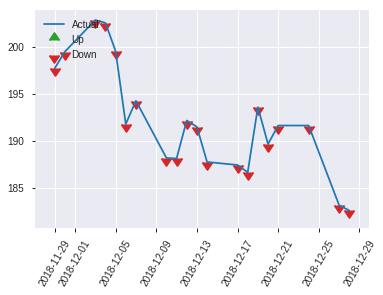


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5380952380952381
RMSE: 0.733549751615552
LogLoss: 18.58515110773764
Null degrees of freedom: 209
Residual degrees of freedom: -819
Null deviance: 290.6054272050573
Residual deviance: 156793.3205765168
AIC: 158851.3205765168
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1291000370691055e-51: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.1291e-51   0.69969   0
max f2                       1.1291e-51   0.853474  0
max f0point5                 1.1291e-51   0.592865  0
max accuracy                 1.1291e-51   0.538095  0
max precision                1.1291e-51   0.538095  0
max recall                   1.1291e-51   1         0
max specificity              1.1291e-51   0         0
max absolute_mcc             1.1291e-51   0         0
max min_per_class_accuracy   1.1291e-51   0         0
max mean_per_class_accuracy  1.1291e-51   0.5       0

Gains/Lift Table: Avg response rate: 53.81 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   5.41038e-81        1.23894   1.23894            0.666667         7.9037e-50    0.666667                    7.9037e-50          0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   5.29782e-219       1.85841   1.48673            1                5.79274e-171  0.8                         4.74222e-50         0.0176991       0.0353982                  85.8407   48.6726
    3        1                           0                  0.988129  1                  0.531707         6.75233e-228  0.538095                    1.1291e-51          0.964602        1                          -1.18714  0

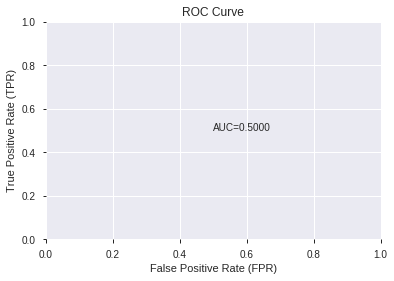

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


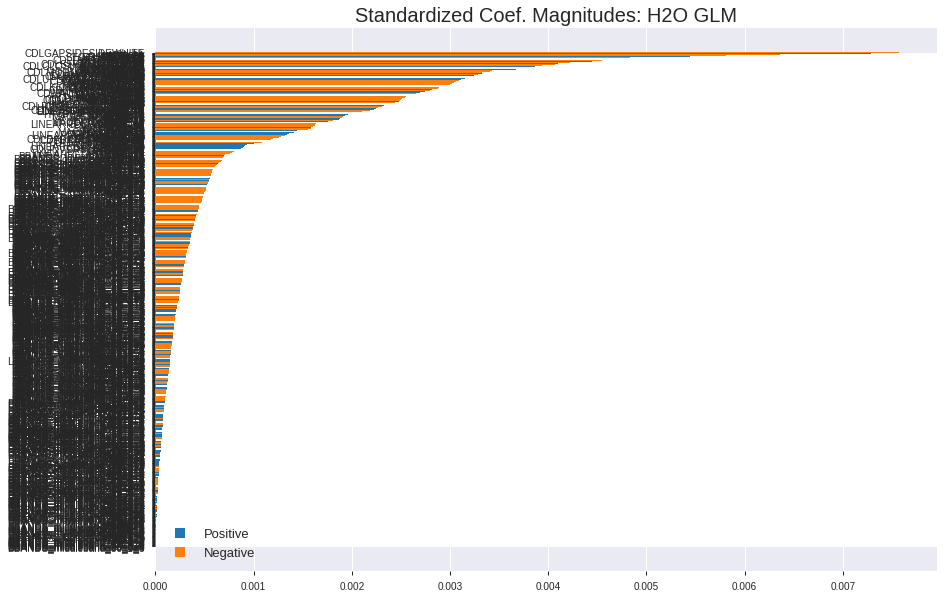

'log_likelihood'
--2019-09-06 01:10:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_011026_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_011026_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

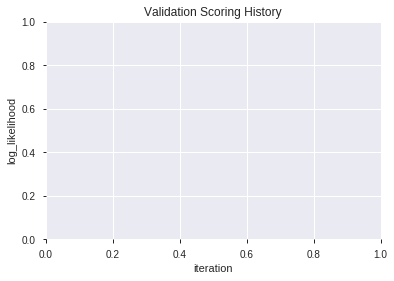

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_011116_model_7  0.523401  0.705374              0.489691  0.505669  0.255702
1  XGBoost_grid_1_AutoML_20190906_011116_model_4  0.518292  0.700495              0.494845  0.503385  0.253396
2               XGBoost_2_AutoML_20190906_011116  0.517653  0.706909              0.489691  0.505963  0.255999
3  XGBoost_grid_1_AutoML_20190906_011116_model_2  0.505884  0.698905              0.494845  0.502646  0.252653
4               XGBoost_1_AutoML_20190906_011116  0.505611  0.715964              0.477922  0.510422  0.260531
5  XGBoost_grid_1_AutoML_20190906_011116_model_1  0.504607  0.708269              0.489691  0.506916  0.256963
6  XGBoost_grid_1_AutoML_20190906_011116_model_6  0.504060  0.719880              0.500000  0.512459  0.262614
7  XGBoost_grid_1_AutoML_20190906_011116_model_3  0.491470  0.715779              0.494116  0.510354  0.260462
8  XGBoost_grid_1_AutoML_20190906_011116_model_5  0.479062  0.742741              0.500000  0.522281  0.272778
9               XGBoost_3_AutoML_20190906_011116  0.463096  0.717091              0.494845  0.511364  0.261494

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           171.634308           1.000000    0.020512
1                     BETA_8           134.027695           0.780891    0.016017
2                     TRANGE           131.405472           0.765613    0.015704
3                        DIV           122.453812           0.713458    0.014634
4       HT_PHASOR_quadrature           119.011971           0.693404    0.014223
..                       ...                  ...                ...         ...
273              MIDPOINT_24             3.943606           0.022977    0.000471
274  BBANDS_lowerband_30_5_3             3.942096           0.022968    0.000471
275  BBANDS_lowerband_12_4_2             3.623851           0.021114    0.000433
276  BBANDS_upperband_30_1_5             3.253995           0.018959    0.000389
277                  SAR_0.2             1.477132           0.008606    0.000177

[278 rows x 4 columns]

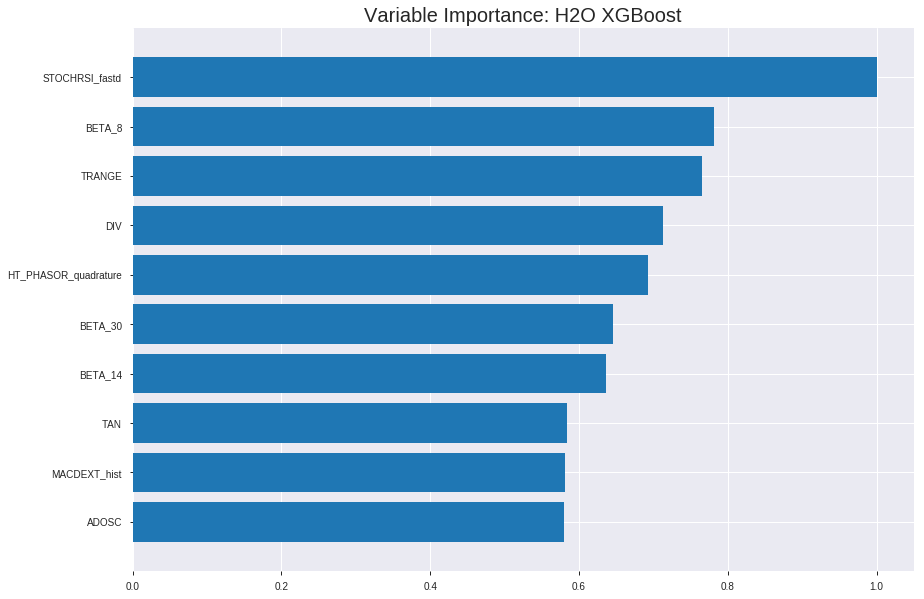

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_011116_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1275878153594942
RMSE: 0.3571943663602412
LogLoss: 0.4317009872989064
Mean Per-Class Error: 0.06611141116385721
AUC: 0.9817495286013437
pr_auc: 0.9850515457697316
Gini: 0.9634990572026874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5534726977348328: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      600  35   0.0551   (35.0/635.0)
1      65   766  0.0782   (65.0/831.0)
Total  665  801  0.0682   (100.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.553473     0.938725  206
max f2                       0.477598     0.957472  247
max f0point5                 0.585823     0.953818  188
max accuracy                 0.556274     0.931787  204
max precision                0.918158     1         0
max recall                   0.360272     1         315
max specificity              0.918158     1         0
max absolute_mcc             0.556274     0.863079  204
max min_per_class_accuracy   0.545381     0.925984  211
max mean_per_class_accuracy  0.556274     0.933889  204

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.868848           1.76414    1.76414            1                0.890183  1                           0.890183            0.0180505       0.0180505                  76.414     76.414
    2        0.0204638                   0.846267           1.76414    1.76414            1                0.855755  1                           0.872969            0.0180505       0.0361011                  76.414     76.414
    3        0.0300136                   0.83425            1.76414    1.76414            1                0.838216  1                           0.861911            0.0168472       0.0529483                  76.414     76.414
    4        0.0402456                   0.820474           1.76414    1.76414            1                0.828405  1                           0.853393            0.0180505       0.0709988                  76.414     76.414
    5        0.0504775                   0.81286            1.76414    1.76414            1                0.815988  1                           0.845811            0.0180505       0.0890493                  76.414     76.414
    6        0.100273                    0.777145           1.76414    1.76414            1                0.794483  1                           0.820321            0.087846        0.176895                   76.414     76.414
    7        0.150068                    0.755731           1.76414    1.76414            1                0.765359  1                           0.802084            0.087846        0.264741                   76.414     76.414
    8        0.200546                    0.736912           1.76414    1.76414            1                0.746104  1                           0.787994            0.0890493       0.353791                   76.414     76.414
    9        0.300136                    0.696024           1.73997    1.75612            0.986301         0.717579  0.995455                    0.764629            0.173285        0.527076                   73.9973    75.6121
    10       0.400409                    0.650366           1.74014    1.75212            0.986395         0.67225   0.993186                    0.741495            0.174489        0.701564                   74.0138    75.2118
    11       0.5                         0.590428           1.63122    1.72804            0.924658         0.621781  0.979536                    0.71765             0.162455        0.864019                   63.1225    72.8039
    12       0.600273                    0.512521           0.996079   1.60577            0.564626         0.550807  0.910227                    0.68978             0.0998797       0.963899                   -0.392118  60.5768
    13       0.699864                    0.429994           0.265829   1.41509            0.150685         0.466649  0.802144                    0.658028            0.0264741       0.990373                   -73.4171   41.5094
    14       0.800136                    0.36641            0.0840066  1.24828            0.047619         0.3986    0.707587                    0.625517            0.00842359      0.998797                   -91.5993   24.8283
    15       0.899727                    0.312178           0.0120831  1.11145            0.00684932       0.339792  0.630023                    0.59389             0.00120337      1                          -98.7917   11.1448
    16       1                           0.161967           0          1                  0                0.267374  0.566849          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2562515586856451
RMSE: 0.506212957840517
LogLoss: 0.7070690297187331
Mean Per-Class Error: 0.46054982817869417
AUC: 0.5234822451317297
pr_auc: 0.5432633969792926
Gini: 0.04696449026345939
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.356406033039093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   178  0.9175   (178.0/194.0)
1      6    219  0.0267   (6.0/225.0)
Total  22   397  0.4391   (184.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356406     0.70418   378
max f2                       0.265457     0.854863  397
max f0point5                 0.373978     0.607609  365
max accuracy                 0.378015     0.568019  363
max precision                0.824122     1         0
max recall                   0.265457     1         397
max specificity              0.824122     1         0
max absolute_mcc             0.373978     0.134842  365
max min_per_class_accuracy   0.531694     0.515464  199
max mean_per_class_accuracy  0.412084     0.53945   342

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 53.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.786415           0.744889  0.744889           0.4              0.805426  0.4                         0.805426            0.00888889      0.00888889                 -25.5111  -25.5111
    2        0.0214797                   0.74416            0.931111  0.827654           0.5              0.753408  0.444444                    0.782307            0.00888889      0.0177778                  -6.88889  -17.2346
    3        0.0310263                   0.727864           1.39667   1.00274            0.75             0.735259  0.538462                    0.767831            0.0133333       0.0311111                  39.6667   0.273504
    4        0.0405728                   0.724227           0.931111  0.985882           0.5              0.726059  0.529412                    0.758002            0.00888889      0.04                       -6.88889  -1.41176
    5        0.0501193                   0.718585           0.465556  0.886772           0.25             0.72281   0.47619                     0.751299            0.00444444      0.0444444                  -53.4444  -11.3228
    6        0.100239                    0.689824           1.24148   1.06413            0.666667         0.704971  0.571429                    0.728135            0.0622222       0.106667                   24.1481   6.4127
    7        0.150358                    0.662552           0.886772  1.00501            0.47619          0.678048  0.539683                    0.711439            0.0444444       0.151111                   -11.3228  0.500882
    8        0.200477                    0.64028            0.97545   0.997619           0.52381          0.648428  0.535714                    0.695687            0.0488889       0.2                        -2.45503  -0.238095
    9        0.300716                    0.601973           1.06413   1.01979            0.571429         0.620403  0.547619                    0.670592            0.106667        0.306667                   6.4127    1.97884
    10       0.400955                    0.565734           1.01979   1.01979            0.547619         0.583119  0.547619                    0.648724            0.102222        0.408889                   1.97884   1.97884
    11       0.501193                    0.531694           1.06413   1.02866            0.571429         0.544642  0.552381                    0.627907            0.106667        0.515556                   6.4127    2.86561
    12       0.599045                    0.497511           0.908401  1.00901            0.487805         0.515392  0.541833                    0.609528            0.0888889       0.604444                   -9.15989  0.901284
    13       0.699284                    0.462874           1.10847   1.02327            0.595238         0.480418  0.549488                    0.591021            0.111111        0.715556                   10.8466   2.32689
    14       0.799523                    0.432301           1.10847   1.03395            0.595238         0.446685  0.555224                    0.572925            0.111111        0.826667                   10.8466   3.39502
    15       0.899761                    0.383615           1.06413   1.03731            0.571429         0.412393  0.557029                    0.555041            0.106667        0.933333                   6.4127    3.73121
    16       1                           0.180356           0.665079  1                  0.357143         0.340098  0.536993                    0.533495 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:11:50  20.828 sec  0                  0.5              0.693147            0.5             0                  1                0.433151                         0.5                0.693147              0.5               0                    1                  0.463007
    2019-09-06 01:11:50  21.404 sec  5                  0.478375         0.650634            0.839516        0.875496           1.76414          0.265348                         0.499757           0.69266               0.509668          0.544715             1.11733            0.458234
    2019-09-06 01:11:50  21.594 sec  10                 0.460488         0.61638             0.889125        0.912417           1.76414          0.186221                         0.501485           0.696149              0.497308          0.544921             0.744889           0.463007
    2019-09-06 01:11:51  21.791 sec  15                 0.44247          0.5826              0.919008        0.935672           1.76414          0.146658                         0.503322           0.69998               0.499702          0.537725             0.744889           0.455847
    2019-09-06 01:11:51  21.988 sec  20                 0.426618         0.553479            0.940571        0.953344           1.76414          0.126876                         0.502545           0.698582              0.51583           0.539192             0.372444           0.458234
    2019-09-06 01:11:51  22.187 sec  25                 0.413566         0.529689            0.94892         0.959443           1.76414          0.114598                         0.504441           0.702696              0.514433          0.539343             0.744889           0.458234
    2019-09-06 01:11:51  22.383 sec  30                 0.400279         0.506028            0.960923        0.969451           1.76414          0.10573                          0.504046           0.701875              0.517663          0.543434             1.11733            0.453461
    2019-09-06 01:11:51  22.580 sec  35                 0.387386         0.483549            0.971052        0.977357           1.76414          0.0914052                        0.504124           0.702144              0.516564          0.543944             0.744889           0.434368
    2019-09-06 01:11:52  22.765 sec  40                 0.376673         0.464979            0.974185        0.979341           1.76414          0.0825375                        0.503705           0.701285              0.524479          0.545344             1.11733            0.424821
    2019-09-06 01:11:52  22.955 sec  45                 0.366891         0.448116            0.978001        0.982334           1.76414          0.0777626                        0.50583            0.706134              0.520767          0.542407             0.744889           0.436754
    2019-09-06 01:11:52  23.154 sec  50                 0.357194         0.431701            0.98175         0.985052           1.76414          0.0682128                        0.506213           0.707069              0.523482          0.543263             0.744889           0.439141

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           171.63430786132812     1.0                   0.02051151198085661
BETA_8                   134.02769470214844     0.7808910489529638    0.0160172561063424
TRANGE                   131.4054718017578      0.7656130842321269    0.01570388194992785
DIV                      122.45381164550781     0.7134576599012147    0.014634095338897684
HT_PHASOR_quadrature     119.01197052001953     0.693404319934539     0.014222771015915027
---                      ---                    ---                   ---
MIDPOINT_24              3.943606376647949      0.022976795407560268  0.0004712888142838636
BBANDS_lowerband_30_5_3  3.9420957565307617     0.02296799401967919   0.0004711082845108927
BBANDS_lowerband_12_4_2  3.6238512992858887     0.021113793299494515  0.0004330758242239118
BBANDS_upperband_30_1_5  3.253994941711426      0.018958884049804833  0.0003888753773312431
SAR_0.2                  1.477131724357605      0.008606273085862606  0.00017652767351119462


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5571428571428572)

('F1', 0.7040498442367601)

('auc', 0.5234011495301524)

('logloss', 0.7053738233588325)

('mean_per_class_error', 0.4567557704588997)

('rmse', 0.5056693598647716)

('mse', 0.2557015015060478)

xgboost prediction progress: |████████████████████████████████████████████| 100%


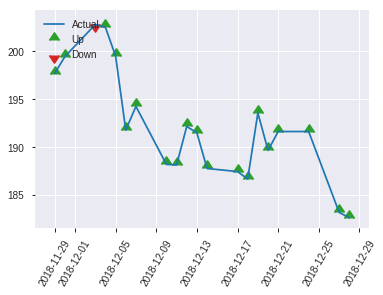


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2557015015060478
RMSE: 0.5056693598647716
LogLoss: 0.7053738233588325
Mean Per-Class Error: 0.4567557704588997
AUC: 0.5234011495301524
pr_auc: 0.5625105309639225
Gini: 0.04680229906030475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31561195850372314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    95   0.9794   (95.0/97.0)
1      0    113  0        (0.0/113.0)
Total  2    208  0.4524   (95.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.315612     0.70405   207
max f2                       0.315612     0.856061  207
max f0point5                 0.315612     0.597884  207
max accuracy                 0.472839     0.557143  143
max precision                0.746854     1         0
max recall                   0.315612     1         207
max specificity              0.746854     1         0
max absolute_mcc             0.315612     0.105837  207
max min_per_class_accuracy   0.530296     0.484536  104
max mean_per_class_accuracy  0.472839     0.543244  143

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 52.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.737078           1.23894   1.23894            0.666667         0.742052  0.666667                    0.742052            0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   0.710866           0.929204  1.11504            0.5              0.718017  0.6                         0.732438            0.00884956      0.0265487                  -7.07965  11.5044
    3        0.0333333                   0.694042           0         0.79646            0                0.698886  0.428571                    0.722852            0               0.0265487                  -100      -20.354
    4        0.0428571                   0.685031           1.85841   1.03245            1                0.689054  0.555556                    0.715341            0.0176991       0.0442478                  85.8407   3.24484
    5        0.052381                    0.670337           0.929204  1.01368            0.5              0.675501  0.545455                    0.708097            0.00884956      0.0530973                  -7.07965  1.36766
    6        0.1                         0.65062            1.30088   1.15044            0.7              0.659159  0.619048                    0.684793            0.0619469       0.115044                   30.0885   15.0442
    7        0.152381                    0.634466           1.35157   1.21958            0.727273         0.641215  0.65625                     0.669813            0.0707965       0.185841                   35.1569   21.958
    8        0.2                         0.619015           0.743363  1.10619            0.4              0.626669  0.595238                    0.659541            0.0353982       0.221239                   -25.6637  10.6195
    9        0.3                         0.586646           1.06195   1.09145            0.571429         0.600786  0.587302                    0.639956            0.106195        0.327434                   6.19469   9.14454
    10       0.4                         0.563205           0.884956  1.03982            0.47619          0.575585  0.559524                    0.623863            0.0884956       0.415929                   -11.5044  3.9823
    11       0.5                         0.530108           0.707965  0.973451           0.380952         0.547676  0.52381                     0.608626            0.0707965       0.486726                   -29.2035  -2.65487
    12       0.6                         0.510312           1.32743   1.03245            0.714286         0.520182  0.555556                    0.593885            0.132743        0.619469                   32.7434   3.24484
    13       0.7                         0.468955           1.15044   1.0493             0.619048         0.48738   0.564626                    0.57867             0.115044        0.734513                   15.0442   4.93047
    14       0.8                         0.427692           0.79646   1.0177             0.428571         0.450253  0.547619                    0.562618            0.079646        0.814159                   -20.354   1.76991
    15       0.9                         0.3722             0.79646   0.993117           0.428571         0.40479   0.534392                    0.545082            0.079646        0.893805                   -20.354   -0.688299
    16       1                           0.287234           1.06195   1                  0.571429         0.330929  0.538095                    0.523666        

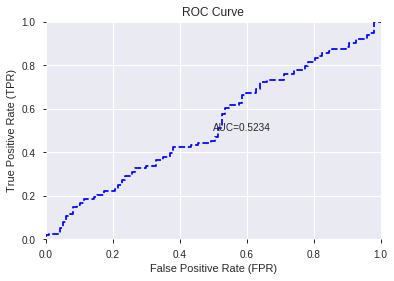

This function is available for GLM models only


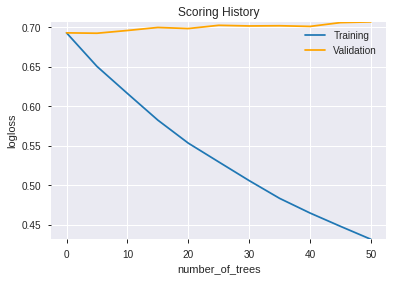

--2019-09-06 01:11:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_011116_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_011116_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_011214_model_9  0.502965  0.692198              0.494116  0.499534  0.249534
1  DeepLearning_grid_1_AutoML_20190906_011214_model_7  0.501505  0.754052              0.500000  0.523590  0.274147
2  DeepLearning_grid_1_AutoML_20190906_011214_model_8  0.493203  0.697399              0.500000  0.502251  0.252256
3               DeepLearning_1_AutoML_20190906_011214  0.470942  0.882238              0.500000  0.562065  0.315917
4  DeepLearning_grid_1_AutoML_20190906_011214_model_6  0.467384  0.702211              0.500000  0.504305  0.254324
5  DeepLearning_grid_1_AutoML_20190906_011214_model_5  0.460998  0.709295              0.500000  0.507927  0.257990
6  DeepLearning_grid_1_AutoML_20190906_011214_model_2  0.453882  1.132297              0.500000  0.599274  0.359130
7  DeepLearning_grid_1_AutoML_20190906_011214_model_1  0.444029  1.381000              0.500000  0.634184  0.402189
8  DeepLearning_grid_1_AutoML_20190906_011214_model_3  0.426512  0.930835              0.494845  0.575112  0.330754
9  DeepLearning_grid_1_AutoML_20190906_011214_model_4  0.406897  1.034767              0.494845  0.604804  0.365788

variable  relative_importance  scaled_importance  percentage
0              TRANGE             1.000000           1.000000    0.028725
1             CDLDOJI             0.902020           0.902020    0.025911
2           dayofweek             0.777397           0.777397    0.022331
3             weekday             0.774091           0.774091    0.022236
4             ADXR_14             0.751099           0.751099    0.021576
5           dayofyear             0.742270           0.742270    0.021322
6      STOCHRSI_fastk             0.740597           0.740597    0.021274
7             quarter             0.729795           0.729795    0.020964
8               month             0.727098           0.727098    0.020886
9      STOCHRSI_fastd             0.719915           0.719915    0.020680
10             ADX_24             0.718509           0.718509    0.020639
11                OBV             0.712592           0.712592    0.020469
12        STOCH_slowk             0.709567           0.709567    0.020383
13       aroondown_30             0.706436           0.706436    0.020293
14             MFI_20             0.699901           0.699901    0.020105
15             MFI_12             0.699638           0.699638    0.020097
16          STDDEV_12             0.699129           0.699129    0.020083
17       STOCHF_fastk             0.696249           0.696249    0.020000
18               week             0.695312           0.695312    0.019973
19      days_in_month             0.692526           0.692526    0.019893
20        STOCH_slowd             0.689726           0.689726    0.019813
21        aroondown_8             0.689339           0.689339    0.019802
22             SAREXT             0.688818           0.688818    0.019787
23             ULTOSC             0.684156           0.684156    0.019653
24       aroondown_24             0.681679           0.681679    0.019581
25          aroonup_8             0.681445           0.681445    0.019575
26                COS             0.678332           0.678332    0.019485
27              MFI_8             0.675222           0.675222    0.019396
28         AROONOSC_8             0.674553           0.674553    0.019377
29                SIN             0.674436           0.674436    0.019373
30         aroonup_14             0.671213           0.671213    0.019281
31       MACDEXT_hist             0.670765           0.670765    0.019268
32       STOCHF_fastd             0.669728           0.669728    0.019238
33             MFI_14             0.669305           0.669305    0.019226
34             MFI_30             0.667589           0.667589    0.019177
35       weekday_name             0.665219           0.665219    0.019109
36            WILLR_8             0.664441           0.664441    0.019086
37  MACDFIX_signal_12             0.663910           0.663910    0.019071
38  LINEARREG_ANGLE_8             0.660089           0.660089    0.018961
39              DX_14             0.659588           0.659588    0.018947
40        AROONOSC_20             0.655333           0.655333    0.018825
41            NATR_12             0.651975           0.651975    0.018728
42            NATR_30             0.648054           0.648054    0.018616
43           WILLR_24             0.647120           0.647120    0.018589
44             TRIX_8             0.647079           0.647079    0.018588
45              DX_12             0.645817           0.645817    0.018551
46        AROONOSC_30             0.642594           0.642594    0.018459
47             MFI_24             0.641178           0.641178    0.018418
48                 AD             0.640638           0.640638    0.018403
49             CMO_20             0.618939           0.618939    0.017779

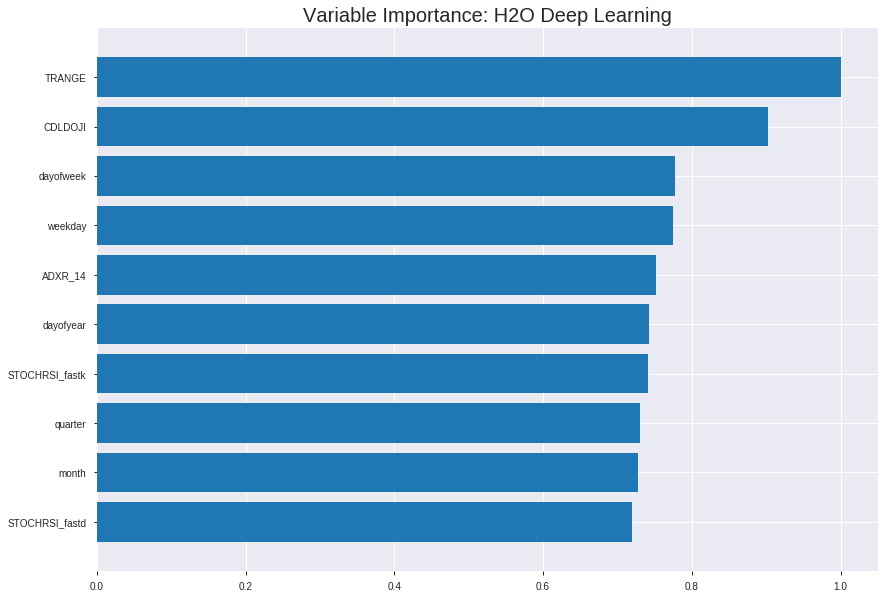

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_011214_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2440698711937178
RMSE: 0.4940342813952467
LogLoss: 0.6811767927639866
Mean Per-Class Error: 0.42885623051631183
AUC: 0.5960279333314382
pr_auc: 0.6502403607846078
Gini: 0.19205586666287644
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4842138816835428: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      69   566   0.8913   (566.0/635.0)
1      35   796   0.0421   (35.0/831.0)
Total  104  1362  0.41     (601.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484214     0.725946  373
max f2                       0.477732     0.867656  394
max f0point5                 0.4889       0.636718  345
max accuracy                 0.484819     0.592769  370
max precision                0.662059     1         0
max recall                   0.439706     1         399
max specificity              0.662059     1         0
max absolute_mcc             0.522912     0.150252  206
max min_per_class_accuracy   0.497818     0.559567  295
max mean_per_class_accuracy  0.495356     0.571144  308

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.627347           1.41131   1.41131            0.8              0.63824   0.8                         0.63824             0.0144404       0.0144404                  41.1312   41.1312
    2        0.0204638                   0.615502           1.41131   1.41131            0.8              0.620677  0.8                         0.629458            0.0144404       0.0288809                  41.1312   41.1312
    3        0.0300136                   0.608839           1.2601    1.3632             0.714286         0.611813  0.772727                    0.623844            0.0120337       0.0409146                  26.01     36.3199
    4        0.0402456                   0.602435           1.41131   1.37543            0.8              0.605883  0.779661                    0.619278            0.0144404       0.055355                   41.1312   37.5431
    5        0.0504775                   0.595024           1.2937    1.35886            0.733333         0.599024  0.77027                     0.615172            0.0132371       0.0685921                  29.3702   35.8864
    6        0.100273                    0.571533           1.18415   1.2721             0.671233         0.580548  0.721088                    0.597978            0.0589651       0.127557                   18.4148   27.2101
    7        0.150068                    0.554745           1.20831   1.25094            0.684932         0.562443  0.709091                    0.586187            0.0601685       0.187726                   20.8315   25.0935
    8        0.200546                    0.541042           1.07279   1.2061             0.608108         0.548144  0.683673                    0.576611            0.0541516       0.241877                   7.27876   20.6095
    9        0.300136                    0.518733           1.17207   1.1948             0.664384         0.52876   0.677273                    0.560733            0.116727        0.358604                   17.2065   19.4804
    10       0.400409                    0.504801           0.972077  1.13903            0.55102          0.511702  0.645656                    0.548455            0.0974729       0.456077                   -2.79231  13.9027
    11       0.5                         0.497871           1.0029    1.11191            0.568493         0.50096   0.630286                    0.538995            0.0998797       0.555957                   0.290127  11.1913
    12       0.600273                    0.493795           0.984078  1.09056            0.557823         0.495803  0.618182                    0.53178             0.0986763       0.654633                   -1.59221  9.0559
    13       0.699864                    0.490682           0.857903  1.05745            0.486301         0.492275  0.599415                    0.526158            0.0854392       0.740072                   -14.2097  5.74521
    14       0.800136                    0.488369           1.03208   1.05427            0.585034         0.489542  0.597613                    0.521569            0.10349         0.843562                   3.20817   5.42727
    15       0.899727                    0.485329           0.869987  1.03387            0.493151         0.486873  0.58605                     0.517729            0.0866426       0.930205                   -13.0013  3.38741
    16       1                           0.439706           0.696055  1                  0.394558         0.482237  0.566849                    0.51417           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.249935311290195
RMSE: 0.4999353071050243
LogLoss: 0.692992945348562
Mean Per-Class Error: 0.4720847651775486
AUC: 0.4788316151202749
pr_auc: 0.5442102696905146
Gini: -0.04233676975945022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4764015591181496: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    193  0.9948   (193.0/194.0)
1      0    225  0        (0.0/225.0)
Total  1    418  0.4606   (193.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476402     0.699844  398
max f2                       0.476402     0.853566  398
max f0point5                 0.476402     0.593042  398
max accuracy                 0.479319     0.539379  394
max precision                0.586343     0.818182  10
max recall                   0.476402     1         398
max specificity              0.62336      0.994845  0
max absolute_mcc             0.567378     0.104817  31
max min_per_class_accuracy   0.49867      0.493333  202
max mean_per_class_accuracy  0.567378     0.527915  31

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 50.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0119332                   0.604404           1.11733   1.11733            0.6              0.61329   0.6                         0.61329             0.0133333       0.0133333                  11.7333     11.7333
    2        0.0214797                   0.592155           1.86222   1.4484             1                0.598026  0.777778                    0.606506            0.0177778       0.0311111                  86.2222     44.8395
    3        0.0310263                   0.583352           0.931111  1.28923            0.5              0.586616  0.692308                    0.600386            0.00888889      0.04                       -6.88889    28.9231
    4        0.0405728                   0.580639           1.39667   1.31451            0.75             0.582105  0.705882                    0.596084            0.0133333       0.0533333                  39.6667     31.451
    5        0.0501193                   0.575959           1.39667   1.33016            0.75             0.577761  0.714286                    0.592594            0.0133333       0.0666667                  39.6667     33.0159
    6        0.100239                    0.556021           1.06413   1.19714            0.571429         0.566719  0.642857                    0.579657            0.0533333       0.12                       6.4127      19.7143
    7        0.150358                    0.540158           0.709418  1.03457            0.380952         0.547282  0.555556                    0.568865            0.0355556       0.155556                   -29.0582    3.45679
    8        0.200477                    0.53053            0.798095  0.97545            0.428571         0.535409  0.52381                     0.560501            0.04            0.195556                   -20.1905    -2.45503
    9        0.300716                    0.514656           0.97545   0.97545            0.52381          0.521912  0.52381                     0.547638            0.0977778       0.293333                   -2.45503    -2.45503
    10       0.400955                    0.50323            0.886772  0.95328            0.47619          0.507987  0.511905                    0.537725            0.0888889       0.382222                   -11.3228    -4.67196
    11       0.501193                    0.498357           1.10847   0.984317           0.595238         0.500916  0.528571                    0.530364            0.111111        0.493333                   10.8466     -1.56825
    12       0.599045                    0.494168           0.999241  0.986755           0.536585         0.496361  0.52988                     0.524809            0.0977778       0.591111                   -0.0758808  -1.32448
    13       0.699284                    0.491203           0.886772  0.972423           0.47619          0.492843  0.522184                    0.520227            0.0888889       0.68                       -11.3228    -2.75768
    14       0.799523                    0.487375           0.886772  0.961685           0.47619          0.488923  0.516418                    0.516302            0.0888889       0.768889                   -11.3228    -3.83151
    15       0.899761                    0.48399            1.1528    0.982977           0.619048         0.485848  0.527851                    0.51291             0.115556        0.884444                   15.2804     -1.70233
    16       1                           0.461864           1.1528    1                  0.619048         0.48075   0.53


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:18:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:18:49  2 min 13.118 sec  461 obs/sec       0.803547  1             1178       0.642619         1.68372             -0.681899      0.568704        0.629706           1.17609          0.425648                         0.664999           1.83506               -0.778632        0.476667          0.530166             1.48978            0.463007
    2019-09-06 01:18:59  2 min 23.064 sec  709 obs/sec       5.61255   7             8228       0.494482         0.682036            0.00414956     0.5863          0.644737           1.52892          0.418827                         0.502935           0.699275              -0.0173424       0.498202          0.558395             1.11733            0.463007
    2019-09-06 01:19:09  2 min 32.474 sec  817 obs/sec       11.2251   14            16456      0.494034         0.681177            0.00595198     0.596028        0.65024            1.41131          0.409959                         0.499935           0.692993              -0.00524383      0.478832          0.54421              1.11733            0.460621
    2019-09-06 01:19:19  2 min 42.462 sec  884 obs/sec       17.6276   22            25842      0.489585         0.671995            0.0237762      0.600076        0.661263           1.2937           0.42633                          0.507169           0.707798              -0.0345439       0.470584          0.536964             1.48978            0.460621
    2019-09-06 01:19:28  2 min 51.917 sec  934 obs/sec       24.06     30            35272      0.499924         0.693018            -0.0178912     0.612197        0.673702           1.64653          0.430423                         0.504037           0.701296              -0.0218048       0.463127          0.544544             1.11733            0.460621
    2019-09-06 01:19:38  3 min  1.813 sec  982 obs/sec       31.3302   39            45930      0.487702         0.66843             0.0312718      0.62896         0.6883             1.64653          0.412688                         0.503047           0.699342              -0.0177963       0.465979          0.525145             0.744889           0.460621
    2019-09-06 01:19:47  3 min 10.936 sec  1027 obs/sec      38.5375   48            56496      0.484367         0.661699            0.0444747      0.645877        0.701222           1.52892          0.431787                         0.503892           0.701355              -0.0212188       0.481512          0.518148             0.372444           0.460621
    2019-09-06 01:19:48  3 min 11.857 sec  1026 obs/sec      38.5375   48            56496      0.494034         0.681177            0.00595198     0.596028        0.65024            1.41131          0.409959                         0.499935           0.692993              -0.00524383      0.478832          0.54421              1.11733            0.460621

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  --------------------
TRANGE       1.0                    1.0                  0.028725381907442334
CDLDOJI      0.902019739151001      0.902019739151001    0.025910861495164018
dayofweek    0.7773969173431396     0.7773969173431396   0.022331023344350068
weekday      0.7740914821624756     0.7740914821624756   0.022236073456415196
ADXR_14      0.7510989308357239     0.7510989308357239   0.021575603638527785
---          ---                    ---                  ---
DX_12        0.6458167433738708     0.6458167433738708   0.018551332595635118
AROONOSC_30  0.6425935626029968     0.6425935626029968   0.018458745497035037
MFI_24       0.6411777138710022     0.6411777138710022   0.018418074701485324
AD           0.6406380534172058     0.6406380534172058   0.01840257274884968
CMO_20       0.6189389824867249     0.6189389824867249   0.017779258649334932


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5523809523809524)

('F1', 0.7)

('auc', 0.5029650579326704)

('logloss', 0.6921982444635053)

('mean_per_class_error', 0.47244776936410915)

('rmse', 0.49953403599545293)

('mse', 0.24953425311790645)

deeplearning prediction progress: |███████████████████████████████████████| 100%


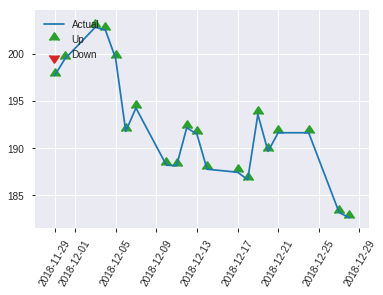


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24953425311790645
RMSE: 0.49953403599545293
LogLoss: 0.6921982444635053
Mean Per-Class Error: 0.47244776936410915
AUC: 0.5029650579326704
pr_auc: 0.5534632638245786
Gini: 0.005930115865340868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.477880983334532: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    95   0.9794   (95.0/97.0)
1      1    112  0.0088   (1.0/113.0)
Total  3    207  0.4571   (96.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477881     0.7       206
max f2                       0.435559     0.853474  209
max f0point5                 0.485924     0.596556  174
max accuracy                 0.485924     0.552381  174
max precision                0.593875     1         0
max recall                   0.435559     1         209
max specificity              0.593875     1         0
max absolute_mcc             0.59085      0.111538  2
max min_per_class_accuracy   0.495679     0.513274  103
max mean_per_class_accuracy  0.501271     0.527552  81

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.589633           1.85841   1.85841            1                0.59245   1                           0.59245             0.0265487       0.0265487                  85.8407   85.8407
    2        0.0238095                   0.560097           0.929204  1.48673            0.5              0.56876   0.8                         0.582974            0.00884956      0.0353982                  -7.07965  48.6726
    3        0.0333333                   0.557831           0         1.06195            0                0.55876   0.571429                    0.576056            0               0.0353982                  -100      6.19469
    4        0.0428571                   0.554645           1.85841   1.23894            1                0.556447  0.666667                    0.571698            0.0176991       0.0530973                  85.8407   23.8938
    5        0.052381                    0.551576           0         1.01368            0                0.55263   0.545455                    0.568231            0               0.0530973                  -100      1.36766
    6        0.1                         0.529074           1.30088   1.15044            0.7              0.538525  0.619048                    0.554085            0.0619469       0.115044                   30.0885   15.0442
    7        0.152381                    0.520416           0.675784  0.987279           0.363636         0.52354   0.53125                     0.543586            0.0353982       0.150442                   -32.4216  -1.27212
    8        0.2                         0.515041           1.48673   1.10619            0.8              0.517704  0.595238                    0.537423            0.0707965       0.221239                   48.6726   10.6195
    9        0.3                         0.506865           0.884956  1.03245            0.47619          0.510114  0.555556                    0.52832             0.0884956       0.309735                   -11.5044  3.24484
    10       0.4                         0.501045           1.15044   1.06195            0.619048         0.503772  0.571429                    0.522183            0.115044        0.424779                   15.0442   6.19469
    11       0.5                         0.4955             0.884956  1.02655            0.47619          0.497692  0.552381                    0.517285            0.0884956       0.513274                   -11.5044  2.65487
    12       0.6                         0.492433           0.619469  0.958702           0.333333         0.494082  0.515873                    0.513418            0.0619469       0.575221                   -38.0531  -4.12979
    13       0.7                         0.488551           1.06195   0.973451           0.571429         0.489775  0.52381                     0.51004             0.106195        0.681416                   6.19469   -2.65487
    14       0.8                         0.486676           1.23894   1.00664            0.666667         0.487864  0.541667                    0.507268            0.123894        0.80531                    23.8938   0.663717
    15       0.9                         0.483631           0.973451  1.00295            0.52381          0.485293  0.539683                    0.504827            0.0973451       0.902655                   -2.65487  0.294985
    16       1                           0.435559           0.973451  1                  0.52381          0.478395  0.538095                    0.502184    

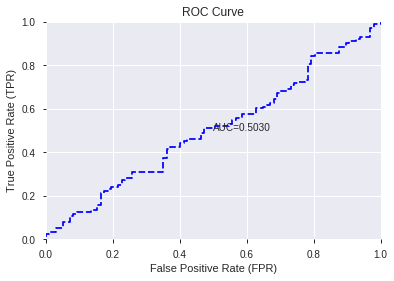

This function is available for GLM models only


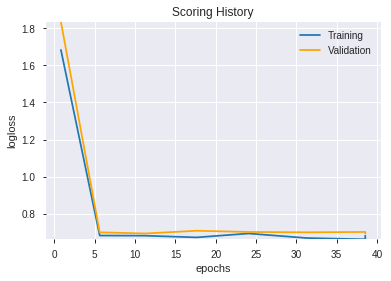

--2019-09-06 01:19:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_011214_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_011214_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLDOJI',
 'dayofweek',
 'weekday',
 'ADXR_14',
 'dayofyear',
 'STOCHRSI_fastk',
 'quarter',
 'month',
 'STOCHRSI_fastd',
 'ADX_24',
 'OBV',
 'STOCH_slowk',
 'aroondown_30',
 'MFI_20',
 'MFI_12',
 'STDDEV_12',
 'STOCHF_fastk',
 'week',
 'days_in_month',
 'STOCH_slowd',
 'aroondown_8',
 'SAREXT',
 'ULTOSC',
 'aroondown_24',
 'aroonup_8',
 'COS',
 'MFI_8',
 'AROONOSC_8',
 'SIN',
 'aroonup_14',
 'MACDEXT_hist',
 'STOCHF_fastd',
 'MFI_14',
 'MFI_30',
 'weekday_name',
 'WILLR_8',
 'MACDFIX_signal_12',
 'LINEARREG_ANGLE_8',
 'DX_14',
 'AROONOSC_20',
 'NATR_12',
 'NATR_30',
 'WILLR_24',
 'TRIX_8',
 'DX_12',
 'AROONOSC_30',
 'MFI_24',
 'AD',
 'CMO_20']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_012005_model_1  0.539276  0.690302                   0.5  0.498581  0.248583

variable  relative_importance  scaled_importance  percentage
0              ADX_24             0.008548           1.000000    0.051089
1             ADXR_14             0.008547           0.999914    0.051084
2             weekday             0.008233           0.963213    0.049209
3           dayofweek             0.008230           0.962826    0.049190
4      STOCHRSI_fastd             0.007499           0.877281    0.044819
5             CDLDOJI             0.006703           0.784212    0.040064
6        STOCHF_fastk             0.006278           0.734506    0.037525
7         STOCH_slowk             0.006175           0.722379    0.036905
8        STOCHF_fastd             0.006166           0.721394    0.036855
9              TRANGE             0.005861           0.685683    0.035031
10            NATR_12             0.005633           0.659059    0.033671
11              DX_14             0.005340           0.624750    0.031918
12     STOCHRSI_fastk             0.005091           0.595615    0.030429
13              DX_12             0.004746           0.555240    0.028367
14            NATR_30             0.004726           0.552892    0.028247
15        STOCH_slowd             0.004260           0.498362    0.025461
16          dayofyear             0.004109           0.480751    0.024561
17          aroonup_8             0.004082           0.477509    0.024395
18             ULTOSC             0.003787           0.443096    0.022637
19  LINEARREG_ANGLE_8             0.003705           0.433427    0.022143
20              month             0.003682           0.430749    0.022006
21               week             0.003551           0.415475    0.021226
22            quarter             0.003272           0.382787    0.019556
23            WILLR_8             0.003252           0.380504    0.019440
24             MFI_20             0.003026           0.353967    0.018084
25       weekday_name             0.002848           0.333141    0.017020
26                COS             0.002701           0.316039    0.016146
27              MFI_8             0.002627           0.307313    0.015700
28       aroondown_24             0.002456           0.287279    0.014677
29         AROONOSC_8             0.002222           0.259937    0.013280
30             MFI_30             0.002220           0.259709    0.013268
31           WILLR_24             0.002178           0.254769    0.013016
32       aroondown_30             0.002071           0.242281    0.012378
33             MFI_24             0.001963           0.229713    0.011736
34  MACDFIX_signal_12             0.001687           0.197416    0.010086
35         aroonup_14             0.001557           0.182139    0.009305
36             SAREXT             0.001459           0.170684    0.008720
37             TRIX_8             0.001216           0.142294    0.007270
38      days_in_month             0.001183           0.138378    0.007070
39                 AD             0.001071           0.125264    0.006400
40             MFI_12             0.000978           0.114379    0.005843
41             MFI_14             0.000745           0.087110    0.004450
42             CMO_20             0.000348           0.040741    0.002081
43                SIN             0.000348           0.040706    0.002080
44        AROONOSC_30             0.000245           0.028628    0.001463
45        aroondown_8             0.000215           0.025191    0.001287
46          STDDEV_12             0.000167           0.019551    0.000999
47                OBV             0.000125           0.014612    0.000746
48       MACDEXT_hist             0.000100           0.011730    0.000599
49        AROONOSC_20             0.000078           0.009162    0.000468

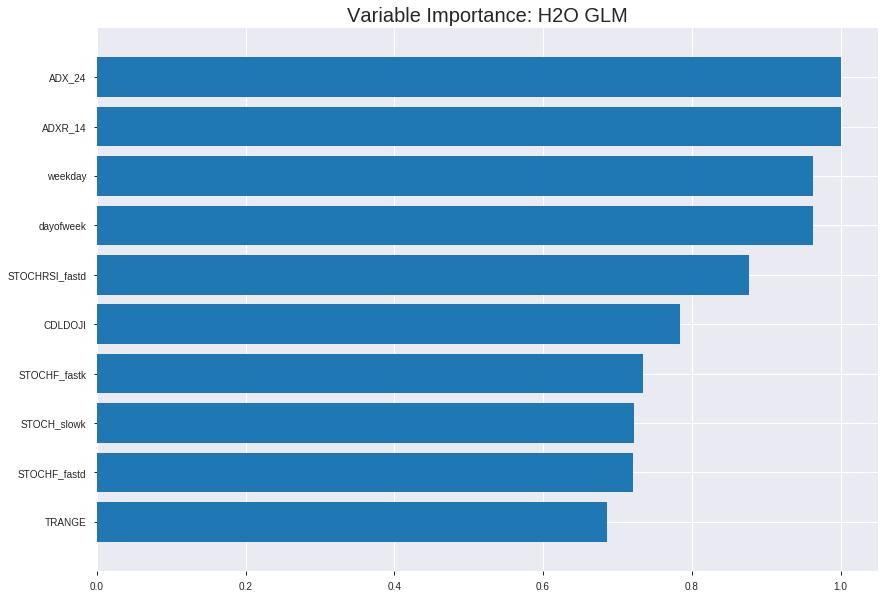

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_012005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2437491671099111
RMSE: 0.49370959795198543
LogLoss: 0.6805547894360208
Null degrees of freedom: 1465
Residual degrees of freedom: 1415
Null deviance: 2006.0242636899413
Residual deviance: 1995.3866426264128
AIC: 2097.386642626413
AUC: 0.5821304376664108
pr_auc: 0.6295115972628639
Gini: 0.16426087533282163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5453786053946486: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      52   583   0.9181   (583.0/635.0)
1      28   803   0.0337   (28.0/831.0)
Total  80   1386  0.4168   (611.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.545379     0.724402  350
max f2                       0.493866     0.867432  399
max f0point5                 0.553271     0.636838  303
max accuracy                 0.553271     0.593452  303
max precision                0.603651     1         0
max recall                   0.493866     1         399
max specificity              0.603651     1         0
max absolute_mcc             0.553271     0.132112  303
max min_per_class_accuracy   0.566019     0.55716   205
max mean_per_class_accuracy  0.567358     0.565989  196

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.59616            1.2937    1.2937             0.733333         0.598118  0.733333                    0.598118            0.0132371       0.0132371                  29.3702    29.3702
    2        0.0204638                   0.594058           1.2937    1.2937             0.733333         0.595081  0.733333                    0.596599            0.0132371       0.0264741                  29.3702    29.3702
    3        0.0300136                   0.592029           1.38611   1.3231             0.785714         0.592878  0.75                        0.595415            0.0132371       0.0397112                  38.611     32.3105
    4        0.0402456                   0.590704           1.17609   1.28573            0.666667         0.591477  0.728814                    0.594414            0.0120337       0.0517449                  17.6093    28.5729
    5        0.0504775                   0.589841           1.17609   1.26351            0.666667         0.590306  0.716216                    0.593581            0.0120337       0.0637786                  17.6093    26.3505
    6        0.100273                    0.585239           1.06332   1.16409            0.60274          0.587309  0.659864                    0.590466            0.0529483       0.116727                   6.3317     16.4092
    7        0.150068                    0.581884           1.15998   1.16273            0.657534         0.583657  0.659091                    0.588207            0.0577617       0.174489                   15.9982    16.2728
    8        0.200546                    0.579075           1.14431   1.15809            0.648649         0.580452  0.656463                    0.586255            0.0577617       0.23225                    14.4307    15.8092
    9        0.300136                    0.574924           1.03915   1.11862            0.589041         0.577007  0.634091                    0.583186            0.10349         0.33574                    3.91507    11.8625
    10       0.400409                    0.570625           1.15209   1.12701            0.653061         0.572812  0.638842                    0.580588            0.115523        0.451264                   15.2091    12.7006
    11       0.5                         0.566261           0.978735  1.09747            0.554795         0.568573  0.622101                    0.578195            0.0974729       0.548736                   -2.1265    9.74729
    12       0.600273                    0.562785           0.984078  1.07853            0.557823         0.564477  0.611364                    0.575903            0.0986763       0.647413                   -1.59221   7.85308
    13       0.699864                    0.559076           0.990818  1.06605            0.561644         0.560853  0.604288                    0.573762            0.0986763       0.746089                   -0.918187  6.60493
    14       0.800136                    0.555026           0.972077  1.05427            0.55102          0.557122  0.597613                    0.571677            0.0974729       0.843562                   -2.79231   5.42727
    15       0.899727                    0.549374           0.869987  1.03387            0.493151         0.552333  0.58605                     0.569535            0.0866426       0.930205                   -13.0013   3.38741
    16       1                           0.493866           0.696055  1                  0.394558         0.54274   0.566849                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24970090085901855
RMSE: 0.49970081134516736
LogLoss: 0.6925759143293971
Null degrees of freedom: 418
Residual degrees of freedom: 368
Null deviance: 580.0755282349307
Residual deviance: 580.3786162080348
AIC: 682.3786162080348
AUC: 0.4948453608247423
pr_auc: 0.554261570994605
Gini: -0.010309278350515427
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5394346289689413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    187  0.9639   (187.0/194.0)
1      3    222  0.0133   (3.0/225.0)
Total  10   409  0.4535   (190.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539435     0.700315  389
max f2                       0.533128     0.852919  399
max f0point5                 0.539435     0.596454  389
max accuracy                 0.539435     0.546539  389
max precision                0.594746     1         0
max recall                   0.533128     1         399
max specificity              0.594746     1         0
max absolute_mcc             0.586248     0.10361   20
max min_per_class_accuracy   0.568223     0.489691  201
max mean_per_class_accuracy  0.580926     0.526586  51

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 56.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0119332                   0.589969           1.11733   1.11733            0.6              0.591351  0.6                         0.591351            0.0133333       0.0133333                  11.7333     11.7333
    2        0.0214797                   0.588604           1.39667   1.24148            0.75             0.58932   0.666667                    0.590448            0.0133333       0.0266667                  39.6667     24.1481
    3        0.0310263                   0.587336           1.86222   1.43248            1                0.587904  0.769231                    0.589665            0.0177778       0.0444444                  86.2222     43.2479
    4        0.0405728                   0.586846           0.931111  1.31451            0.5              0.587144  0.705882                    0.589072            0.00888889      0.0533333                  -6.88889    31.451
    5        0.0501193                   0.585986           1.86222   1.41884            1                0.586558  0.761905                    0.588593            0.0177778       0.0711111                  86.2222     41.8836
    6        0.100239                    0.582508           0.97545   1.19714            0.52381          0.584271  0.642857                    0.586432            0.0488889       0.12                       -2.45503    19.7143
    7        0.150358                    0.579451           0.97545   1.12325            0.52381          0.580913  0.603175                    0.584592            0.0488889       0.168889                   -2.45503    12.3245
    8        0.200477                    0.577212           0.798095  1.04196            0.428571         0.57809   0.559524                    0.582967            0.04            0.208889                   -20.1905    4.19577
    9        0.300716                    0.574271           0.931111  1.00501            0.5              0.576035  0.539683                    0.580656            0.0933333       0.302222                   -6.88889    0.500882
    10       0.400955                    0.571206           0.886772  0.97545            0.47619          0.572854  0.52381                     0.578706            0.0888889       0.391111                   -11.3228    -2.45503
    11       0.501193                    0.568223           1.01979   0.984317           0.547619         0.569718  0.528571                    0.576908            0.102222        0.493333                   1.97884     -1.56825
    12       0.599045                    0.564323           0.999241  0.986755           0.536585         0.566401  0.52988                     0.575192            0.0977778       0.591111                   -0.0758808  -1.32448
    13       0.699284                    0.560793           0.97545   0.985135           0.52381          0.562813  0.52901                     0.573417            0.0977778       0.688889                   -2.45503    -1.48654
    14       0.799523                    0.556164           0.931111  0.978362           0.5              0.558372  0.525373                    0.571531            0.0933333       0.782222                   -6.88889    -2.16385
    15       0.899761                    0.549605           1.10847   0.992856           0.595238         0.552875  0.533156                    0.569453            0.111111        0.893333                   10.8466     -0.714412
    16       1                           0.533128           1.06413   1                  0.571429         0.543918  0.53


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:20:05  0.000 sec   2            3.7       51            1.36111           1.38515
    2019-09-06 01:20:05  0.012 sec   4            2.3       51            1.35832           1.38599
    2019-09-06 01:20:05  0.023 sec   6            1.4       51            1.35507           1.38745
    2019-09-06 01:20:05  0.036 sec   8            0.89      51            1.35161           1.38964
    2019-09-06 01:20:05  0.046 sec   10           0.56      51            1.34818           1.39251

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5523809523809524)

('F1', 0.6996904024767803)

('auc', 0.5392756135389106)

('logloss', 0.6903015398451224)

('mean_per_class_error', 0.43568105099899646)

('rmse', 0.498580730078774)

('mse', 0.2485827444058833)

glm prediction progress: |████████████████████████████████████████████████| 100%


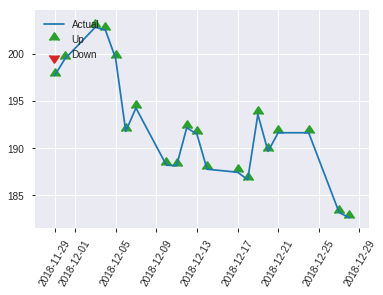


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2485827444058833
RMSE: 0.498580730078774
LogLoss: 0.6903015398451224
Null degrees of freedom: 209
Residual degrees of freedom: 159
Null deviance: 290.6054272050573
Residual deviance: 289.9266467349514
AIC: 391.9266467349514
AUC: 0.5392756135389106
pr_auc: 0.5823415312392587
Gini: 0.07855122707782125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5141211956013778: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514121     0.69969   209
max f2                       0.514121     0.853474  209
max f0point5                 0.546633     0.59887   192
max accuracy                 0.546633     0.552381  192
max precision                0.596292     1         0
max recall                   0.514121     1         209
max specificity              0.596292     1         0
max absolute_mcc             0.572382     0.141962  59
max min_per_class_accuracy   0.565674     0.522124  103
max mean_per_class_accuracy  0.572382     0.564319  59

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 56.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.595394           1.85841   1.85841            1                0.595973  1                           0.595973            0.0265487       0.0265487                  85.8407   85.8407
    2        0.0238095                   0.591532           0.929204  1.48673            0.5              0.592281  0.8                         0.594496            0.00884956      0.0353982                  -7.07965  48.6726
    3        0.0333333                   0.589336           0.929204  1.32743            0.5              0.589667  0.714286                    0.593116            0.00884956      0.0442478                  -7.07965  32.7434
    4        0.0428571                   0.586477           1.85841   1.44543            1                0.587858  0.777778                    0.591948            0.0176991       0.0619469                  85.8407   44.5428
    5        0.052381                    0.585339           0         1.18262            0                0.585724  0.636364                    0.590816            0               0.0619469                  -100      18.2623
    6        0.1                         0.579656           0.743363  0.973451           0.4              0.582624  0.52381                     0.586915            0.0353982       0.0973451                  -25.6637  -2.65487
    7        0.152381                    0.577031           1.52051   1.1615             0.818182         0.578314  0.625                       0.583959            0.079646        0.176991                   52.0515   16.1504
    8        0.2                         0.575107           1.11504   1.15044            0.6              0.576162  0.619048                    0.582102            0.0530973       0.230088                   11.5044   15.0442
    9        0.3                         0.571752           1.23894   1.17994            0.666667         0.573529  0.634921                    0.579245            0.123894        0.353982                   23.8938   17.9941
    10       0.4                         0.568412           0.884956  1.10619            0.47619          0.569888  0.595238                    0.576906            0.0884956       0.442478                   -11.5044  10.6195
    11       0.5                         0.565348           0.79646   1.04425            0.428571         0.566718  0.561905                    0.574868            0.079646        0.522124                   -20.354   4.42478
    12       0.6                         0.561699           0.884956  1.0177             0.47619          0.563718  0.547619                    0.57301             0.0884956       0.610619                   -11.5044  1.76991
    13       0.7                         0.55877            0.973451  1.01138            0.52381          0.560375  0.544218                    0.571205            0.0973451       0.707965                   -2.65487  1.1378
    14       0.8                         0.554203           0.973451  1.00664            0.52381          0.556625  0.541667                    0.569382            0.0973451       0.80531                    -2.65487  0.663717
    15       0.9                         0.547796           1.06195   1.01278            0.571429         0.55095   0.544974                    0.567334            0.106195        0.911504                   6.19469   1.27827
    16       1                           0.514121           0.884956  1                  0.47619          0.540197  0.538095                    0.564621        

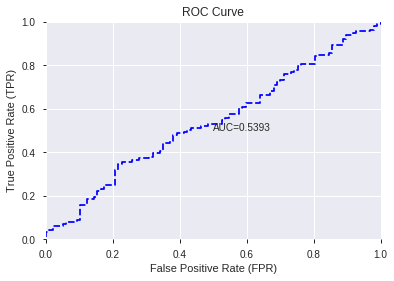

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


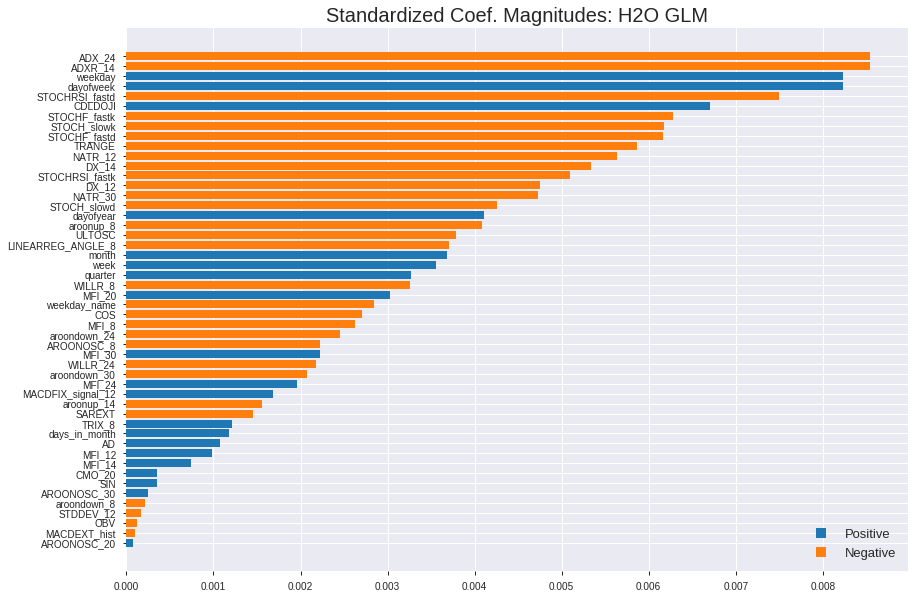

'log_likelihood'
--2019-09-06 01:20:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_012005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_012005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['ADX_24',
 'ADXR_14',
 'weekday',
 'dayofweek',
 'STOCHRSI_fastd',
 'CDLDOJI',
 'STOCHF_fastk',
 'STOCH_slowk',
 'STOCHF_fastd',
 'TRANGE',
 'NATR_12',
 'DX_14',
 'STOCHRSI_fastk',
 'DX_12',
 'NATR_30',
 'STOCH_slowd',
 'dayofyear',
 'aroonup_8',
 'ULTOSC',
 'LINEARREG_ANGLE_8',
 'month',
 'week',
 'quarter',
 'WILLR_8',
 'MFI_20',
 'weekday_name',
 'COS',
 'MFI_8',
 'aroondown_24',
 'AROONOSC_8',
 'MFI_30',
 'WILLR_24',
 'aroondown_30',
 'MFI_24',
 'MACDFIX_signal_12',
 'aroonup_14',
 'SAREXT',
 'TRIX_8',
 'days_in_month',
 'AD',
 'MFI_12',
 'MFI_14',
 'CMO_20',
 'SIN',
 'AROONOSC_30',
 'aroondown_8',
 'STDDEV_12',
 'OBV',
 'MACDEXT_hist',
 'AROONOSC_20']

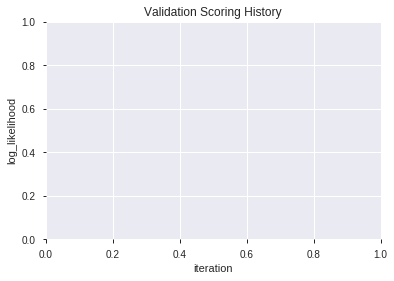

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_012027_model_7  0.530426  0.710854              0.500000  0.507487  0.257543
1  XGBoost_grid_1_AutoML_20190906_012027_model_6  0.524861  0.703183              0.494845  0.504651  0.254672
2               XGBoost_2_AutoML_20190906_012027  0.518840  0.704434              0.500000  0.505303  0.255331
3  XGBoost_grid_1_AutoML_20190906_012027_model_1  0.512271  0.719872              0.489691  0.512092  0.262238
4  XGBoost_grid_1_AutoML_20190906_012027_model_5  0.509534  0.733017              0.469072  0.516922  0.267208
5               XGBoost_1_AutoML_20190906_012027  0.508986  0.707450              0.500000  0.506787  0.256833
6  XGBoost_grid_1_AutoML_20190906_012027_model_2  0.507344  0.703366              0.500000  0.504783  0.254806
7  XGBoost_grid_1_AutoML_20190906_012027_model_4  0.498860  0.701896              0.489691  0.504094  0.254111
8               XGBoost_3_AutoML_20190906_012027  0.496123  0.711418              0.494116  0.508608  0.258682
9  XGBoost_grid_1_AutoML_20190906_012027_model_3  0.485631  0.715765              0.500000  0.510748  0.260864

variable  relative_importance  scaled_importance  percentage
0              TRANGE           331.779480           1.000000    0.046483
1           STDDEV_12           247.799500           0.746880    0.034717
2                 SIN           245.619919           0.740311    0.034412
3      STOCHRSI_fastd           233.452728           0.703638    0.032707
4                 COS           232.122086           0.699628    0.032521
5               MFI_8           223.729782           0.674333    0.031345
6        MACDEXT_hist           219.334930           0.661086    0.030729
7              MFI_12           213.081955           0.642240    0.029853
8   MACDFIX_signal_12           208.466812           0.628329    0.029206
9              TRIX_8           200.436066           0.604124    0.028081
10        STOCH_slowd           198.839127           0.599311    0.027858
11             ADX_24           197.144958           0.594205    0.027620
12  LINEARREG_ANGLE_8           194.396622           0.585921    0.027235
13            ADXR_14           187.539688           0.565254    0.026275
14                OBV           183.642822           0.553509    0.025729
15          dayofweek           183.114792           0.551917    0.025655
16          dayofyear           176.595169           0.532267    0.024741
17        STOCH_slowk           173.421188           0.522700    0.024297
18             SAREXT           172.160141           0.518899    0.024120
19             MFI_30           170.342712           0.513421    0.023865
20       aroondown_24           168.396805           0.507556    0.023593
21                 AD           167.269119           0.504158    0.023435
22              DX_14           165.836060           0.499838    0.023234
23           WILLR_24           165.640930           0.499250    0.023207
24             MFI_24           164.407501           0.495532    0.023034
25       STOCHF_fastk           155.902176           0.469897    0.021842
26             ULTOSC           142.189224           0.428565    0.019921
27            WILLR_8           136.587738           0.411682    0.019136
28            NATR_30           132.584946           0.399618    0.018575
29             CMO_20           132.484879           0.399316    0.018561
30            NATR_12           131.207169           0.395465    0.018382
31     STOCHRSI_fastk           128.427490           0.387087    0.017993
32              DX_12           123.545784           0.372373    0.017309
33             MFI_14           123.527473           0.372318    0.017306
34             MFI_20           120.336784           0.362701    0.016859
35        AROONOSC_20            98.903893           0.298101    0.013857
36       STOCHF_fastd            93.286873           0.281171    0.013070
37       aroondown_30            82.492462           0.248636    0.011557
38        AROONOSC_30            80.574402           0.242855    0.011289
39         aroonup_14            77.966362           0.234995    0.010923
40        aroondown_8            75.512238           0.227598    0.010579
41         AROONOSC_8            52.410641           0.157968    0.007343
42       weekday_name            49.501560           0.149200    0.006935
43               week            36.142391           0.108935    0.005064
44            weekday            32.607704           0.098281    0.004568
45            CDLDOJI            32.199657           0.097051    0.004511
46          aroonup_8            31.818981           0.095904    0.004458
47              month            25.867947           0.077967    0.003624
48      days_in_month            13.389488           0.040357    0.001876
49            quarter             3.649623           0.011000    0.000511

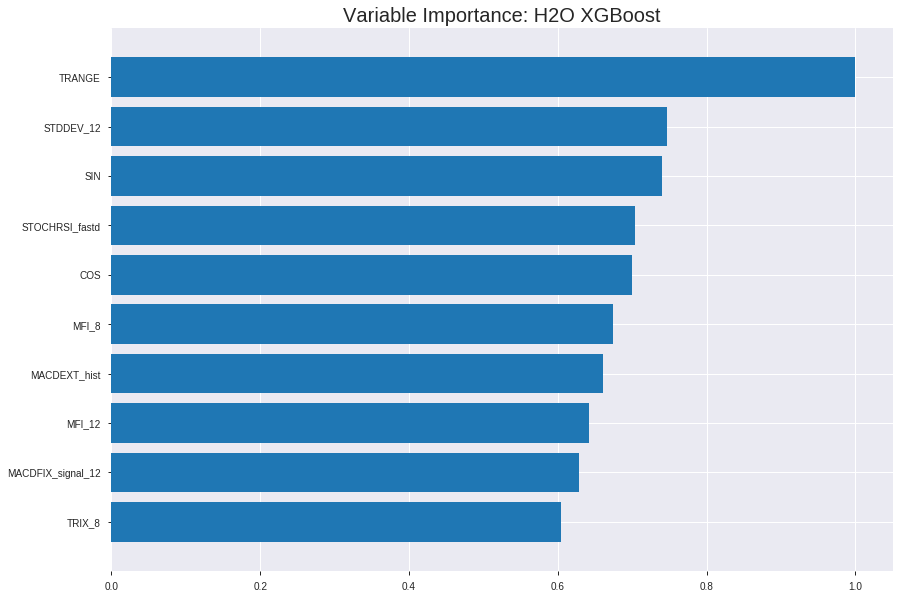

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_012027_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.144045741944487
RMSE: 0.3795335847385406
LogLoss: 0.46884351493827503
Mean Per-Class Error: 0.09519315500724868
AUC: 0.9692089030387446
pr_auc: 0.9754559926670741
Gini: 0.9384178060774893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5195895433425903: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      549  86   0.1354   (86.0/635.0)
1      54   777  0.065    (54.0/831.0)
Total  603  863  0.0955   (140.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51959      0.917355  217
max f2                       0.463734     0.947198  254
max f0point5                 0.596538     0.928144  165
max accuracy                 0.544838     0.904502  201
max precision                0.902119     1         0
max recall                   0.355578     1         326
max specificity              0.902119     1         0
max absolute_mcc             0.544838     0.806693  201
max min_per_class_accuracy   0.544838     0.902527  201
max mean_per_class_accuracy  0.544838     0.904807  201

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 55.90 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.842975           1.76414    1.76414            1                0.869972  1                           0.869972            0.0180505       0.0180505                  76.414    76.414
    2        0.0204638                   0.823325           1.76414    1.76414            1                0.829876  1                           0.849924            0.0180505       0.0361011                  76.414    76.414
    3        0.0300136                   0.806161           1.76414    1.76414            1                0.813216  1                           0.838244            0.0168472       0.0529483                  76.414    76.414
    4        0.0402456                   0.796445           1.76414    1.76414            1                0.801071  1                           0.828793            0.0180505       0.0709988                  76.414    76.414
    5        0.0504775                   0.78926            1.76414    1.76414            1                0.793452  1                           0.82163             0.0180505       0.0890493                  76.414    76.414
    6        0.100273                    0.754806           1.76414    1.76414            1                0.769911  1                           0.795946            0.087846        0.176895                   76.414    76.414
    7        0.150068                    0.732888           1.76414    1.76414            1                0.743923  1                           0.778684            0.087846        0.264741                   76.414    76.414
    8        0.200546                    0.713594           1.76414    1.76414            1                0.721678  1                           0.764335            0.0890493       0.353791                   76.414    76.414
    9        0.300136                    0.67205            1.73997    1.75612            0.986301         0.69171   0.995455                    0.740237            0.173285        0.527076                   73.9973   75.6121
    10       0.400409                    0.627516           1.70413    1.7431             0.965986         0.652939  0.988075                    0.718375            0.170878        0.697954                   70.4135   74.3102
    11       0.5                         0.576145           1.37748    1.67028            0.780822         0.601058  0.946794                    0.695008            0.137184        0.835138                   37.7479   67.0277
    12       0.600273                    0.510792           1.04408    1.56567            0.591837         0.544667  0.8875                      0.669894            0.104693        0.939832                   4.40826   56.5674
    13       0.699864                    0.451364           0.519575   1.41681            0.294521         0.483143  0.803119                    0.643319            0.0517449       0.991576                   -48.0425  41.6814
    14       0.800136                    0.404495           0.0600047  1.24678            0.0340136        0.426425  0.706735                    0.616138            0.00601685      0.997593                   -93.9995  24.6779
    15       0.899727                    0.340886           0.0241663  1.11145            0.0136986        0.371201  0.630023                    0.589026            0.00240674      1                          -97.5834  11.1448
    16       1                           0.201616           0          1                  0                0.290069  0.566849                    0.55904



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25696351744200485
RMSE: 0.5069156906646359
LogLoss: 0.7084278049820708
Mean Per-Class Error: 0.467434135166094
AUC: 0.5123596792668957
pr_auc: 0.5347569408375623
Gini: 0.02471935853379148
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28617435693740845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.286174     0.698758   399
max f2                       0.286174     0.852919   399
max f0point5                 0.369723     0.59294    377
max accuracy                 0.459107     0.541766   289
max precision                0.809279     1          0
max recall                   0.286174     1          399
max specificity              0.809279     1          0
max absolute_mcc             0.711191     0.0822878  12
max min_per_class_accuracy   0.51952      0.502222   195
max mean_per_class_accuracy  0.545383     0.532566   159

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0119332                   0.753563           0.744889  0.744889           0.4              0.774436  0.4                         0.774436            0.00888889      0.00888889                 -25.5111    -25.5111
    2        0.0214797                   0.730321           0.931111  0.827654           0.5              0.739695  0.444444                    0.758995            0.00888889      0.0177778                  -6.88889    -17.2346
    3        0.0310263                   0.70976            0         0.572991           0                0.722009  0.307692                    0.747615            0               0.0177778                  -100        -42.7009
    4        0.0405728                   0.692723           0.931111  0.657255           0.5              0.701931  0.352941                    0.736866            0.00888889      0.0266667                  -6.88889    -34.2745
    5        0.0501193                   0.679485           1.39667   0.798095           0.75             0.686529  0.428571                    0.727278            0.0133333       0.04                       39.6667     -20.1905
    6        0.100239                    0.650207           1.06413   0.931111           0.571429         0.662483  0.5                         0.69488             0.0533333       0.0933333                  6.4127      -6.88889
    7        0.150358                    0.622366           1.06413   0.97545            0.571429         0.636173  0.52381                     0.675311            0.0533333       0.146667                   6.4127      -2.45503
    8        0.200477                    0.610042           1.06413   0.997619           0.571429         0.615984  0.535714                    0.660479            0.0533333       0.2                        6.4127      -0.238095
    9        0.300716                    0.576618           1.19714   1.06413            0.642857         0.589846  0.571429                    0.636935            0.12            0.32                       19.7143     6.4127
    10       0.400955                    0.545228           1.10847   1.07521            0.595238         0.562993  0.577381                    0.618449            0.111111        0.431111                   10.8466     7.52116
    11       0.501193                    0.517162           0.709418  1.00205            0.380952         0.532625  0.538095                    0.601284            0.0711111       0.502222                   -29.0582    0.205291
    12       0.599045                    0.492651           0.999241  1.00159            0.536585         0.503534  0.537849                    0.585317            0.0977778       0.6                        -0.0758808  0.159363
    13       0.699284                    0.469749           1.1528    1.02327            0.619048         0.480712  0.549488                    0.570323            0.115556        0.715556                   15.2804     2.32689
    14       0.799523                    0.436454           0.842434  1.0006             0.452381         0.454061  0.537313                    0.555747            0.0844444       0.8                        -15.7566    0.0597015
    15       0.899761                    0.402956           0.931111  0.992856           0.5              0.420483  0.533156                    0.540677            0.0933333       0.893333                   -6.88889    -0.714412
    16       1                           0.286174           1.06413   1                  0.571429         0.35796


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:20:35  5.100 sec   0                  0.5              0.693147            0.5             0                  1                0.433151                         0.5                0.693147              0.5               0                    1                  0.463007
    2019-09-06 01:20:35  5.159 sec   5                  0.482101         0.657865            0.808102        0.837479           1.76414          0.268076                         0.500076           0.693306              0.512291          0.537444             0.744889           0.460621
    2019-09-06 01:20:35  5.214 sec   10                 0.465762         0.626404            0.870072        0.889513           1.76414          0.204638                         0.50161            0.696395              0.499782          0.540002             1.11733            0.460621
    2019-09-06 01:20:35  5.279 sec   15                 0.451406         0.599173            0.898196        0.918125           1.76414          0.183492                         0.501955           0.697102              0.501008          0.540025             0.744889           0.455847
    2019-09-06 01:20:35  5.352 sec   20                 0.437471         0.573089            0.922409        0.936025           1.76414          0.149386                         0.503725           0.700744              0.491569          0.531968             1.11733            0.460621
    2019-09-06 01:20:36  5.415 sec   25                 0.425239         0.550517            0.935029        0.946553           1.76414          0.146658                         0.503922           0.701259              0.496094          0.53235              1.11733            0.460621
    2019-09-06 01:20:36  5.466 sec   30                 0.415481         0.532647            0.94056         0.952438           1.76414          0.132333                         0.503291           0.700196              0.514742          0.538151             0.744889           0.458234
    2019-09-06 01:20:36  5.521 sec   35                 0.406041         0.515334            0.94511         0.957124           1.76414          0.139836                         0.503772           0.701323              0.517835          0.539919             1.11733            0.463007
    2019-09-06 01:20:36  5.576 sec   40                 0.397695         0.500487            0.953858        0.963499           1.76414          0.117326                         0.504093           0.702012              0.518018          0.54409              1.11733            0.463007
    2019-09-06 01:20:36  5.634 sec   45                 0.388544         0.484435            0.96145         0.969516           1.76414          0.109141                         0.506274           0.706858              0.510733          0.537521             1.11733            0.460621
    2019-09-06 01:20:36  5.695 sec   50                 0.379534         0.468844            0.969209        0.975456           1.76414          0.095498                         0.506916           0.708428              0.51236           0.534757             0.744889           0.463007

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
TRANGE          331.77947998046875     1.0                   0.046482760785391895
STDDEV_12       247.79949951171875     0.7468801250948559    0.034717050190147765
SIN             245.6199188232422      0.7403107595373329    0.034411687942425634
STOCHRSI_fastd  233.45272827148438     0.7036382367144204    0.03270704783665136
COS             232.12208557128906     0.6996276128498172    0.03252062296695282
---             ---                    ---                   ---
CDLDOJI         32.19965744018555      0.09705138317198243   0.004511216227874668
aroonup_8       31.818981170654297     0.09590400579483524   0.004457882959722164
month           25.86794662475586      0.07796728907489595   0.003624134847153887
days_in_month   13.389488220214844     0.04035658932554557   0.0018758856877336345
quarter         3.649622917175293      0.011000146595534298  0.0005113171828044638


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5571428571428572)

('F1', 0.6996904024767803)

('auc', 0.5304260560167868)

('logloss', 0.7108536288527836)

('mean_per_class_error', 0.4453060852112034)

('rmse', 0.5074872735120983)

('mse', 0.25754333277674335)

xgboost prediction progress: |████████████████████████████████████████████| 100%


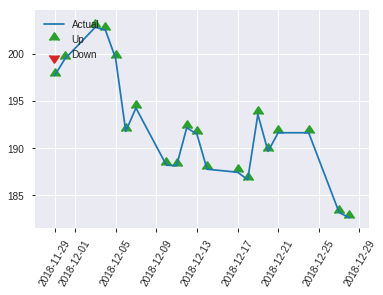


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25754333277674335
RMSE: 0.5074872735120983
LogLoss: 0.7108536288527836
Mean Per-Class Error: 0.4453060852112034
AUC: 0.5304260560167868
pr_auc: 0.5569029669787015
Gini: 0.06085211203357366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23912900686264038: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239129     0.69969   209
max f2                       0.239129     0.853474  209
max f0point5                 0.436188     0.597898  161
max accuracy                 0.436188     0.557143  161
max precision                0.621688     0.659574  46
max recall                   0.239129     1         209
max specificity              0.797835     0.989691  0
max absolute_mcc             0.348449     0.162321  199
max min_per_class_accuracy   0.516162     0.522124  102
max mean_per_class_accuracy  0.621688     0.554694  46

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.768359           0.619469  0.619469           0.333333         0.780585  0.333333                    0.780585            0.00884956      0.00884956                 -38.0531  -38.0531
    2        0.0238095                   0.758924           0.929204  0.743363           0.5              0.761342  0.4                         0.772888            0.00884956      0.0176991                  -7.07965  -25.6637
    3        0.0333333                   0.752763           0.929204  0.79646            0.5              0.755113  0.428571                    0.767809            0.00884956      0.0265487                  -7.07965  -20.354
    4        0.0428571                   0.742621           0.929204  0.825959           0.5              0.746742  0.444444                    0.763128            0.00884956      0.0353982                  -7.07965  -17.4041
    5        0.052381                    0.734149           0.929204  0.84473            0.5              0.737111  0.454545                    0.758397            0.00884956      0.0442478                  -7.07965  -15.527
    6        0.1                         0.682514           1.11504   0.973451           0.6              0.703894  0.52381                     0.732443            0.0530973       0.0973451                  11.5044   -2.65487
    7        0.152381                    0.658612           1.35157   1.10343            0.727273         0.671526  0.59375                     0.711503            0.0707965       0.168142                   35.1569   10.3429
    8        0.2                         0.635614           1.48673   1.19469            0.8              0.645533  0.642857                    0.695796            0.0707965       0.238938                   48.6726   19.469
    9        0.3                         0.590644           0.884956  1.09145            0.47619          0.611886  0.587302                    0.667826            0.0884956       0.327434                   -11.5044  9.14454
    10       0.4                         0.557596           1.15044   1.10619            0.619048         0.570932  0.595238                    0.643602            0.115044        0.442478                   15.0442   10.6195
    11       0.5                         0.510721           0.79646   1.04425            0.428571         0.533971  0.561905                    0.621676            0.079646        0.522124                   -20.354   4.42478
    12       0.6                         0.485435           0.707965  0.988201           0.380952         0.496485  0.531746                    0.600811            0.0707965       0.59292                    -29.2035  -1.17994
    13       0.7                         0.45815            1.06195   0.998736           0.571429         0.472983  0.537415                    0.58255             0.106195        0.699115                   6.19469   -0.126422
    14       0.8                         0.423929           1.15044   1.0177             0.619048         0.440784  0.547619                    0.564829            0.115044        0.814159                   15.0442   1.76991
    15       0.9                         0.388476           0.79646   0.993117           0.428571         0.407288  0.534392                    0.547324            0.079646        0.893805                   -20.354   -0.688299
    16       1                           0.239129           1.06195   1                  0.571429         0.338771  0.538095                    0.526469 

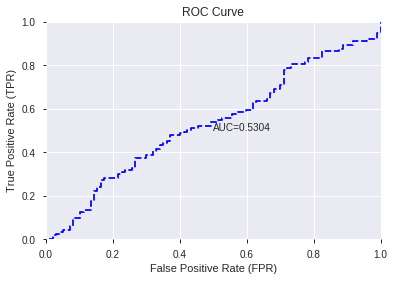

This function is available for GLM models only


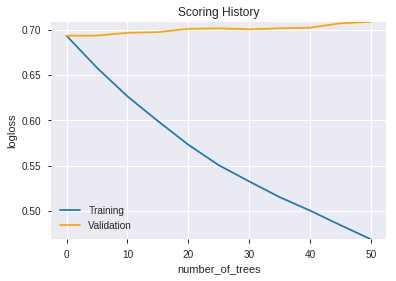

--2019-09-06 01:20:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_012027_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_012027_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['TRANGE',
 'STDDEV_12',
 'SIN',
 'STOCHRSI_fastd',
 'COS',
 'MFI_8',
 'MACDEXT_hist',
 'MFI_12',
 'MACDFIX_signal_12',
 'TRIX_8',
 'STOCH_slowd',
 'ADX_24',
 'LINEARREG_ANGLE_8',
 'ADXR_14',
 'OBV',
 'dayofweek',
 'dayofyear',
 'STOCH_slowk',
 'SAREXT',
 'MFI_30',
 'aroondown_24',
 'AD',
 'DX_14',
 'WILLR_24',
 'MFI_24',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_8',
 'NATR_30',
 'CMO_20',
 'NATR_12',
 'STOCHRSI_fastk',
 'DX_12',
 'MFI_14',
 'MFI_20',
 'AROONOSC_20',
 'STOCHF_fastd',
 'aroondown_30',
 'AROONOSC_30',
 'aroonup_14',
 'aroondown_8',
 'AROONOSC_8',
 'weekday_name',
 'week',
 'weekday',
 'CDLDOJI',
 'aroonup_8',
 'month',
 'days_in_month',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [931 944] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_012100_model_2  0.504425  18.585151                   0.5  0.733550  0.538095
1  DeepLearning_grid_1_AutoML_20190906_012100_model_7  0.500000  15.953625                   0.5  0.679636  0.461905
2  DeepLearning_grid_1_AutoML_20190906_012100_model_8  0.500000   0.690258                   0.5  0.498555  0.248557
3  DeepLearning_grid_1_AutoML_20190906_012100_model_5  0.500000   0.690876                   0.5  0.498861  0.248862
4  DeepLearning_grid_1_AutoML_20190906_012100_model_6  0.500000   0.690633                   0.5  0.498741  0.248742
5               DeepLearning_1_AutoML_20190906_012100  0.500000  15.953625                   0.5  0.679636  0.461905
6  DeepLearning_grid_1_AutoML_20190906_012100_model_4  0.500000  15.953625                   0.5  0.679636  0.461905
7  DeepLearning_grid_1_AutoML_20190906_012100_model_1  0.500000  15.953625                   0.5  0.679636  0.461905
8  DeepLearning_grid_1_AutoML_20190906_012100_model_9  0.500000   0.690790                   0.5  0.498819  0.248820
9  DeepLearning_grid_1_AutoML_20190906_012100_model_3  0.500000  18.585151                   0.5  0.733550  0.538095

variable  relative_importance  scaled_importance  percentage
0                    dayofweek             1.000000           1.000000    0.002294
1                      weekday             0.971972           0.971972    0.002230
2                          OBV             0.881681           0.881681    0.002023
3                          day             0.871698           0.871698    0.002000
4                      CDLDOJI             0.810718           0.810718    0.001860
...                        ...                  ...                ...         ...
1038  BBANDS_middleband_30_0_3             0.343664           0.343664    0.000788
1039                    SUM_14             0.343563           0.343563    0.000788
1040   BBANDS_middleband_8_7_4             0.343194           0.343194    0.000787
1041                    TSF_30             0.341949           0.341949    0.000784
1042   BBANDS_lowerband_12_1_4             0.336540           0.336540    0.000772

[1043 rows x 4 columns]

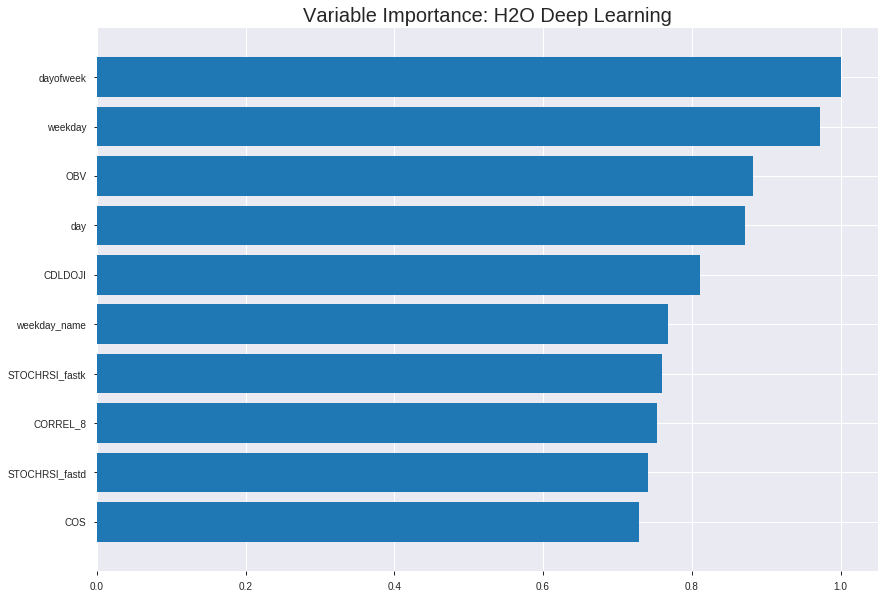

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_012100_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2642322822565822
RMSE: 0.5140352928122565
LogLoss: 0.7303935182694409
Mean Per-Class Error: 0.4503974909273525
AUC: 0.5513374456351801
pr_auc: 0.6192667987599695
Gini: 0.10267489127036011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08663988081179738: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    634   0.9984   (634.0/635.0)
1      0    831   0        (0.0/831.0)
Total  1    1465  0.4325   (634.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0866399    0.723868  398
max f2                       0.0866399    0.867613  398
max f0point5                 0.292136     0.624269  329
max accuracy                 0.292136     0.57367   329
max precision                0.960314     1         0
max recall                   0.0866399    1         398
max specificity              0.960314     1         0
max absolute_mcc             0.796096     0.105044  47
max min_per_class_accuracy   0.536636     0.543307  193
max mean_per_class_accuracy  0.553809     0.549603  182

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 53.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.879595           1.41131   1.41131            0.8              0.917351  0.8                         0.917351            0.0144404       0.0144404                  41.1312   41.1312
    2        0.0204638                   0.85645            1.05848   1.2349             0.6              0.866702  0.7                         0.892026            0.0108303       0.0252708                  5.84838   23.4898
    3        0.0300136                   0.844353           1.2601    1.24292            0.714286         0.849391  0.704545                    0.878461            0.0120337       0.0373045                  26.01     24.2917
    4        0.0402456                   0.831335           1.52892   1.31563            0.866667         0.8389    0.745763                    0.868403            0.0156438       0.0529483                  52.8921   31.563
    5        0.0504775                   0.82055            1.17609   1.28735            0.666667         0.825106  0.72973                     0.859626            0.0120337       0.0649819                  17.6093   28.7345
    6        0.100273                    0.773276           1.18415   1.2361             0.671233         0.798221  0.70068                     0.829133            0.0589651       0.123947                   18.4148   23.6098
    7        0.150068                    0.736556           0.942486  1.13867            0.534247         0.755776  0.645455                    0.804791            0.0469314       0.170878                   -5.75145  13.8672
    8        0.200546                    0.701005           0.90591   1.08009            0.513514         0.718282  0.612245                    0.783017            0.045728        0.216606                   -9.40905  8.00855
    9        0.300136                    0.629654           1.08748   1.08254            0.616438         0.661682  0.613636                    0.742756            0.108303        0.32491                    8.74833   8.25402
    10       0.400409                    0.589044           1.02008   1.0669             0.578231         0.608292  0.60477                     0.709083            0.102286        0.427196                   2.00807   6.68987
    11       0.5                         0.537765           1.11165   1.07581            0.630137         0.562362  0.609823                    0.679859            0.11071         0.537906                   11.165    7.58123
    12       0.600273                    0.49598            0.948075  1.05447            0.537415         0.516525  0.597727                    0.652574            0.0950662       0.632972                   -5.1925   5.44743
    13       0.699864                    0.440201           0.809571  1.01962            0.458904         0.468294  0.577973                    0.626351            0.0806258       0.713598                   -19.0429  1.96245
    14       0.800136                    0.360416           1.10409   1.03021            0.62585          0.403236  0.583973                    0.598391            0.11071         0.824308                   10.4087   3.02094
    15       0.899727                    0.264618           0.894153  1.01515            0.506849         0.31669   0.575436                    0.567209            0.0890493       0.913357                   -10.5847  1.51493
    16       1                           0.0812055          0.864068  1                  0.489796         0.198292  0.566849                    0.530217          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3956167090116473
RMSE: 0.6289806904918841
LogLoss: 7.062833061166849
Mean Per-Class Error: 0.4385223367697595
AUC: 0.5548682703321879
pr_auc: 0.5678985385389816
Gini: 0.10973654066437577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.96166054995822e-56: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       7.96166e-56  0.698758  293
max f2                       7.96166e-56  0.852919  293
max f0point5                 6.47212e-36  0.608255  288
max accuracy                 6.47212e-36  0.575179  288
max precision                0.989024     0.666667  2
max recall                   7.96166e-56  1         293
max specificity              0.991983     0.994845  0
max absolute_mcc             6.47212e-36  0.132531  288
max min_per_class_accuracy   0.623566     0.546667  208
max mean_per_class_accuracy  6.47212e-36  0.561478  288

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 44.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.986988           1.11733   1.11733            0.6              0.989672     0.6                         0.989672            0.0133333       0.0133333                  11.7333   11.7333
    2        0.0214797                   0.97909            0.931111  1.03457            0.5              0.981514     0.555556                    0.986046            0.00888889      0.0222222                  -6.88889  3.45679
    3        0.0310263                   0.976091           0.931111  1.00274            0.5              0.977716     0.538462                    0.983483            0.00888889      0.0311111                  -6.88889  0.273504
    4        0.0405728                   0.973707           1.39667   1.09542            0.75             0.974741     0.588235                    0.981426            0.0133333       0.0444444                  39.6667   9.54248
    5        0.0501193                   0.971572           0         0.886772           0                0.972854     0.47619                     0.979793            0               0.0444444                  -100      -11.3228
    6        0.100239                    0.944279           1.1528    1.01979            0.619048         0.960205     0.547619                    0.969999            0.0577778       0.102222                   15.2804   1.97884
    7        0.150358                    0.909464           1.41884   1.1528             0.761905         0.927148     0.619048                    0.955715            0.0711111       0.173333                   41.8836   15.2804
    8        0.200477                    0.879168           0.620741  1.01979            0.333333         0.896379     0.547619                    0.940881            0.0311111       0.204444                   -37.9259  1.97884
    9        0.300716                    0.821623           1.33016   1.12325            0.714286         0.847236     0.603175                    0.909666            0.133333        0.337778                   33.0159   12.3245
    10       0.400955                    0.730672           0.842434  1.05304            0.452381         0.779698     0.565476                    0.877174            0.0844444       0.422222                   -15.7566  5.30423
    11       0.501193                    0.620045           1.24148   1.09073            0.666667         0.689162     0.585714                    0.839572            0.124444        0.546667                   24.1481   9.07302
    12       0.599045                    9.01616e-07        0.953821  1.06837            0.512195         0.264806     0.573705                    0.745686            0.0933333       0.64                       -4.61789  6.83665
    13       0.699284                    6.5334e-46         1.10847   1.07411            0.595238         6.01245e-08  0.576792                    0.638796            0.111111        0.751111                   10.8466   7.41145
    14       1                           0                  0.827654  1                  0.444444         7.96166e-56  0.536993                    0.4467              0.248889        1                          -17.2346  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:22:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:22:32  1 min 28.802 sec  340 obs/sec       0.526603  1             772        0.682045         9.55591             -0.894606      0.528931        0.372384           1.05128          0.433151                         0.735153           16.3172               -1.1737          0.449095          0.276825             0.922071           0.463007
    2019-09-06 01:22:43  1 min 39.901 sec  371 obs/sec       3.15553   6             4626       0.520546         0.830926            -0.103599      0.620826        0.651544           1.2937           0.392906                         0.66432            9.30608               -0.775003        0.447835          0.288621             0.926132           0.460621
    2019-09-06 01:22:54  1 min 50.692 sec  380 obs/sec       5.78718   11            8484       0.488021         0.671558            0.0300021      0.619865        0.662866           1.52892          0.408595                         0.619315           7.11029               -0.542648        0.559633          0.576584             1.11733            0.463007
    2019-09-06 01:23:04  2 min  1.146 sec  385 obs/sec       8.35471   16            12248      0.552908         0.905696            -0.245084      0.560762        0.629222           1.2937           0.429741                         0.729061           9.88477               -1.13782         0.560607          0.605842             1.48978            0.463007
    2019-09-06 01:23:15  2 min 11.374 sec  392 obs/sec       10.9911   21            16113      0.516063         0.736336            -0.0846714     0.53437         0.595342           1.2937           0.431787                         0.660845           7.99943               -0.756477        0.434261          0.324559             0.881452           0.463007
    2019-09-06 01:23:25  2 min 21.608 sec  397 obs/sec       13.616    26            19961      0.514035         0.730394            -0.0761655     0.551337        0.619267           1.41131          0.432469                         0.628981           7.06283               -0.591177        0.554868          0.567899             1.11733            0.463007
    2019-09-06 01:23:35  2 min 31.923 sec  400 obs/sec       16.2667   31            23847      0.520117         0.755311            -0.10178       0.551118        0.592674           1.05848          0.433151                         0.632383           7.79561               -0.608436        0.544376          0.57005              0.744889           0.463007
    2019-09-06 01:23:47  2 min 43.373 sec  406 obs/sec       19.4325   37            28488      0.485437         0.664441            0.0402497      0.633076        0.682784           1.52892          0.421555                         0.643323           7.61795               -0.664571        0.541375          0.553837             1.11733            0.463007
    2019-09-06 01:23:56

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
dayofweek                 1.0                    1.0                  0.00229410906177734
weekday                   0.9719715118408203     0.9719715118408203   0.002229808653103447
OBV                       0.8816806077957153     0.8816806077957153   0.0020226714719375036
day                       0.8716976642608643     0.8716976642608643   0.00199976951071099
CDLDOJI                   0.8107176423072815     0.8107176423072815   0.001859874689759895
---                       ---                    ---                  ---
BBANDS_middleband_30_0_3  0.34366387128829956    0.34366387128829956  0.0007884024013279695
SUM_14                    0.34356334805488586    0.34356334805488586  0.000788171790067276
BBANDS_middleband_8_7_4   0.3431936502456665     0.3431936502456665   0.0007873236629730266
TSF_30                    0.3419489860534668     0.3419489860534668   0.0007844682675708315
BBANDS_lowerband_12_1_4   0.3365404009819031     0.3365404009819031   0.0007720603835467636


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5380952380952381)

('F1', 0.6996904024767803)

('auc', 0.504424778761062)

('logloss', 18.58515110773764)

('mean_per_class_error', 0.49557522123893805)

('rmse', 0.733549751615552)

('mse', 0.5380952380952381)

deeplearning prediction progress: |███████████████████████████████████████| 100%


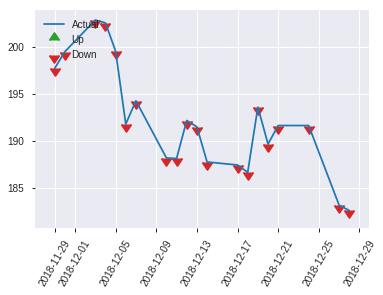


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5380952380952381
RMSE: 0.733549751615552
LogLoss: 18.58515110773764
Mean Per-Class Error: 0.49557522123893805
AUC: 0.504424778761062
pr_auc: 0.7622418879056047
Gini: 0.008849557522123908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.884424863816473e-67: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value       idx
---------------------------  -----------  ----------  -----
max f1                       5.88442e-67  0.69969     1
max f2                       5.88442e-67  0.853474    1
max f0point5                 5.88442e-67  0.592865    1
max accuracy                 5.88442e-67  0.538095    1
max precision                3.25404e-41  1           0
max recall                   5.88442e-67  1           1
max specificity              3.25404e-41  1           0
max absolute_mcc             3.25404e-41  0.0640875   0
max min_per_class_accuracy   3.25404e-41  0.00884956  0
max mean_per_class_accuracy  3.25404e-41  0.504425    0

Gains/Lift Table: Avg response rate: 53.81 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   1.0147e-68         1.23894   1.23894            0.666667         1.08468e-41   0.666667                    1.08468e-41         0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   3.03377e-188       1.85841   1.48673            1                1.2975e-146   0.8                         6.50807e-42         0.0176991       0.0353982                  85.8407   48.6726
    3        1                           0                  0.988129  1                  0.531707         6.63914e-196  0.538095                    1.54954e-43         0.964602        1                          -1.18714  0

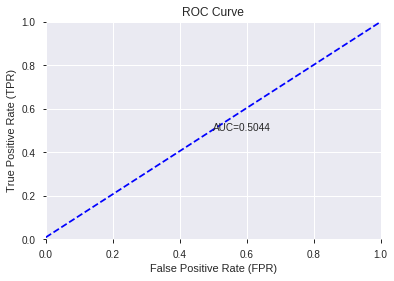

This function is available for GLM models only


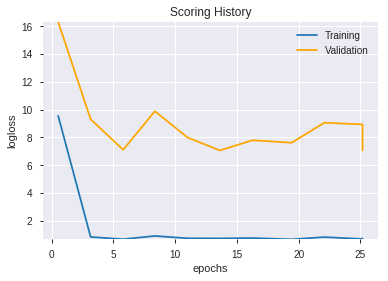

--2019-09-06 01:48:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_012100_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_012100_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['dayofweek',
 'weekday',
 'OBV',
 'day',
 'CDLDOJI',
 'weekday_name',
 'STOCHRSI_fastk',
 'CORREL_8',
 'STOCHRSI_fastd',
 'COS',
 'MFI_30',
 'MFI_20',
 'SIN',
 'PLUS_DM_8',
 'MFI_8',
 'days_in_month',
 'MFI_12',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'TRANGE',
 'aroonup_30',
 'MFI_24',
 'CDLINNECK',
 'ADXR_14',
 'aroondown_24',
 'HT_PHASOR_quadrature',
 'aroondown_14',
 'aroondown_8',
 'aroonup_20',
 'ADXR_12',
 'CDL2CROWS',
 'CDLBREAKAWAY',
 'quarter',
 'aroondown_12',
 'CDLUNIQUE3RIVER',
 'CDLHIKKAKEMOD',
 'dayofyear',
 'ADX_24',
 'HT_DCPERIOD',
 'weekofyear',
 'CDLMATCHINGLOW',
 'aroondown_20',
 'CDLUPSIDEGAP2CROWS',
 'month',
 'MFI_14',
 'week',
 'ADX_20',
 'HT_TRENDMODE',
 'CDLONNECK',
 'COSH',
 'SAREXT',
 'aroondown_30',
 'SINH',
 'is_quarter_end',
 'STOCHF_fastd',
 'CDL3BLACKCROWS',
 'STOCH_slowd',
 'aroonup_8',
 'ROCR_8',
 'PLUS_DI_8',
 'AD',
 'PLUS_DI_30',
 'STOCH_slowk',
 'PLUS_DI_12',
 'ROCR100_8',
 'DX_8',
 'NATR_12',
 'STDDEV_20',
 'CDLHOMINGPIGEON',
 'EXP',
 'NATR_8',
 'AROO

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190906_014824_model_1  0.5  18.585151                   0.5  0.73355  0.538095

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             0.007575           1.000000    0.010520
1                      weekday             0.007288           0.962227    0.010123
2                    dayofweek             0.007285           0.961730    0.010118
3                       ADX_24             0.006818           0.900147    0.009470
4                      ADXR_14             0.006357           0.839284    0.008829
...                        ...                  ...                ...         ...
1038  BBANDS_middleband_24_0_5             0.000000           0.000000    0.000000
1039                    WMA_30             0.000000           0.000000    0.000000
1040  BBANDS_middleband_30_0_3             0.000000           0.000000    0.000000
1041  BBANDS_middleband_30_0_4             0.000000           0.000000    0.000000
1042  BBANDS_middleband_30_0_5             0.000000           0.000000    0.000000

[1043 rows x 4 columns]

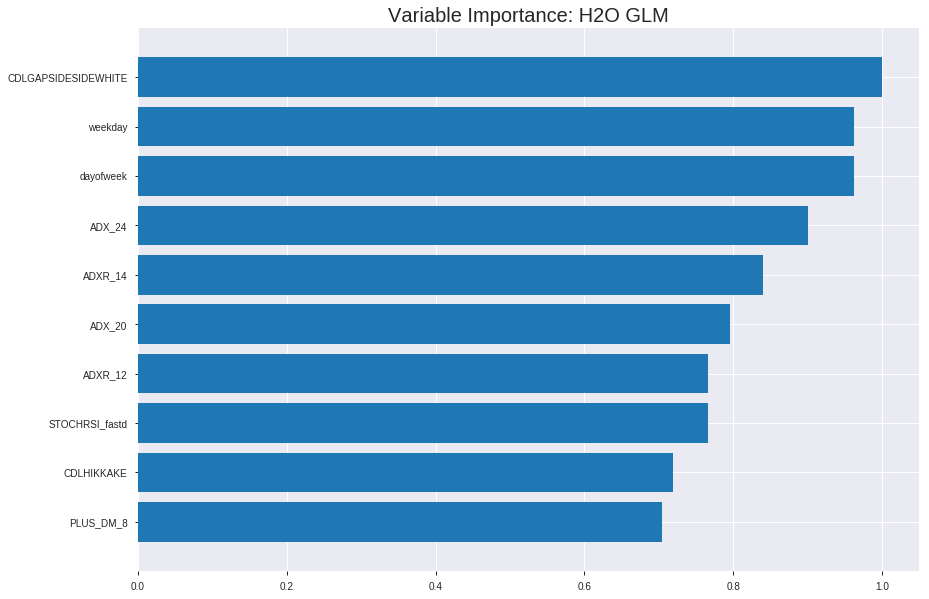

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_014824_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24068392184046514
RMSE: 0.49059547678353616
LogLoss: 0.6742913730914234
Null degrees of freedom: 1465
Residual degrees of freedom: 437
Null deviance: 2006.0242636899413
Residual deviance: 1977.0223059040534
AIC: 4035.0223059040536
AUC: 0.6039019490794697
pr_auc: 0.6591409344487275
Gini: 0.2078038981589394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48528813789835545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   623   0.9811   (623.0/635.0)
1      2    829   0.0024   (2.0/831.0)
Total  14   1452  0.4263   (625.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485288     0.726237  387
max f2                       0.422504     0.867976  396
max f0point5                 0.548072     0.639727  261
max accuracy                 0.548072     0.595498  261
max precision                0.641863     1         0
max recall                   0.422504     1         396
max specificity              0.641863     1         0
max absolute_mcc             0.586949     0.164515  117
max min_per_class_accuracy   0.568737     0.562205  188
max mean_per_class_accuracy  0.586113     0.576747  120

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.626471           1.64653   1.64653            0.933333         0.634157  0.933333                    0.634157            0.0168472       0.0168472                  64.653     64.653
    2        0.0204638                   0.622103           1.17609   1.41131            0.666667         0.623775  0.8                         0.628966            0.0120337       0.0288809                  17.6093    41.1312
    3        0.0300136                   0.618345           1.2601    1.3632             0.714286         0.619799  0.772727                    0.626049            0.0120337       0.0409146                  26.01      36.3199
    4        0.0402456                   0.615895           1.41131   1.37543            0.8              0.617355  0.779661                    0.623839            0.0144404       0.055355                   41.1312    37.5431
    5        0.0504775                   0.613553           1.17609   1.33502            0.666667         0.614537  0.756757                    0.621953            0.0120337       0.0673887                  17.6093    33.5025
    6        0.100273                    0.606059           1.23248   1.2841             0.69863          0.609603  0.727891                    0.61582             0.0613718       0.128761                   23.2481    28.4102
    7        0.150068                    0.599336           1.11165   1.22688            0.630137         0.602724  0.695455                    0.611475            0.055355        0.184116                   11.165     22.6879
    8        0.200546                    0.595509           1.14431   1.2061             0.648649         0.597573  0.683673                    0.607976            0.0577617       0.241877                   14.4307    20.6095
    9        0.300136                    0.587298           1.24456   1.21886            0.705479         0.591493  0.690909                    0.602506            0.123947        0.365824                   24.4564    21.886
    10       0.400409                    0.57713            0.996079  1.16307            0.564626         0.58247   0.659284                    0.597489            0.0998797       0.465704                   -0.392118  16.307
    11       0.5                         0.569217           0.869987  1.10469            0.493151         0.573193  0.626194                    0.59265             0.0866426       0.552347                   -13.0013   10.4693
    12       0.600273                    0.560523           1.09209   1.10259            0.619048         0.564876  0.625                       0.58801             0.109507        0.661853                   9.20864    10.2587
    13       0.699864                    0.551764           0.918319  1.07637            0.520548         0.556081  0.610136                    0.583467            0.0914561       0.753309                   -8.16808   7.63659
    14       0.800136                    0.540931           0.876069  1.05126            0.496599         0.546457  0.595908                    0.578829            0.087846        0.841155                   -12.3931   5.12648
    15       0.899727                    0.525933           0.84582   1.02852            0.479452         0.533848  0.583017                    0.57385             0.0842359       0.925391                   -15.418    2.85241
    16       1                           0.405254           0.744059  1                  0.421769         0.504028  0.566849                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.374579158355589
RMSE: 0.6120287234726725
LogLoss: 7.305051362471108
Null degrees of freedom: 418
Residual degrees of freedom: -610
Null deviance: 580.0755282349307
Residual deviance: 70114.40889507499
AIC: 72172.40889507499
AUC: 0.5547193585337915
pr_auc: 0.5676896716356725
Gini: 0.10943871706758301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.9882660449208993e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.98827e-50  0.698758  289
max f2                       3.98827e-50  0.852919  289
max f0point5                 5.03163e-43  0.608255  288
max accuracy                 5.03163e-43  0.575179  288
max precision                0.584138     1         0
max recall                   3.98827e-50  1         289
max specificity              0.584138     1         0
max absolute_mcc             5.03163e-43  0.132531  288
max min_per_class_accuracy   0.156253     0.541237  210
max mean_per_class_accuracy  5.03163e-43  0.561478  288

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 24.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.552982           1.11733   1.11733            0.6              0.567306     0.6                         0.567306            0.0133333       0.0133333                  11.7333   11.7333
    2        0.0214797                   0.549983           0.931111  1.03457            0.5              0.551313     0.555556                    0.560198            0.00888889      0.0222222                  -6.88889  3.45679
    3        0.0310263                   0.544863           1.39667   1.14598            0.75             0.546832     0.615385                    0.556085            0.0133333       0.0355556                  39.6667   14.5983
    4        0.0405728                   0.540477           1.86222   1.31451            1                0.542971     0.705882                    0.553               0.0177778       0.0533333                  86.2222   31.451
    5        0.0501193                   0.539484           0.931111  1.24148            0.5              0.539958     0.666667                    0.550516            0.00888889      0.0622222                  -6.88889  24.1481
    6        0.100239                    0.530956           0.886772  1.06413            0.47619          0.535696     0.571429                    0.543106            0.0444444       0.106667                   -11.3228  6.4127
    7        0.150358                    0.524243           0.798095  0.97545            0.428571         0.527099     0.52381                     0.53777             0.04            0.146667                   -20.1905  -2.45503
    8        0.200477                    0.510642           1.33016   1.06413            0.714286         0.517534     0.571429                    0.532711            0.0666667       0.213333                   33.0159   6.4127
    9        0.300716                    0.487752           1.06413   1.06413            0.571429         0.500151     0.571429                    0.521858            0.106667        0.32                       6.4127    6.4127
    10       0.400955                    0.455207           1.1528    1.0863             0.619048         0.473478     0.583333                    0.509763            0.115556        0.435556                   15.2804   8.62963
    11       0.501193                    0.181039           1.01979   1.07299            0.547619         0.344742     0.57619                     0.476759            0.102222        0.537778                   1.97884   7.29947
    12       0.599045                    2.06128e-09        1.04466   1.06837            0.560976         0.0228018    0.573705                    0.402606            0.102222        0.64                       4.46612   6.83665
    13       0.699284                    1.65506e-55        1.10847   1.07411            0.595238         7.69461e-11  0.576792                    0.344895            0.111111        0.751111                   10.8466   7.41145
    14       1                           0                  0.827654  1                  0.444444         1.06046e-65  0.536993                    0.241179            0.248889        1                          -17.2346  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:48:27  0.000 sec   2            4.3       1029          1.34858           167.337
    2019-09-06 01:48:29  1.717 sec   4            3.1       1036          1.34432           173.944
    2019-09-06 01:48:30  3.413 sec   6            2.3       1039          1.33931           181.278
    2019-09-06 01:48:32  5.110 sec   8            1.6       1041          1.33348           189.257
    2019-09-06 01:48:34  6.825 sec   10           1.2       1044          1.32681           197.046

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5380952380952381)

('F1', 0.6996904024767803)

('auc', 0.5)

('logloss', 18.58515110773764)

('mean_per_class_error', 0.5)

('rmse', 0.733549751615552)

('mse', 0.5380952380952381)

glm prediction progress: |████████████████████████████████████████████████| 100%


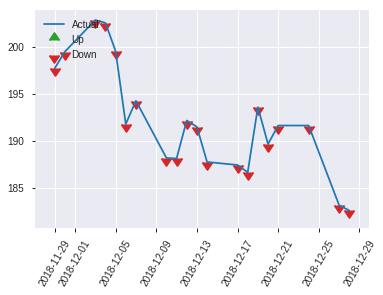


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5380952380952381
RMSE: 0.733549751615552
LogLoss: 18.58515110773764
Null degrees of freedom: 209
Residual degrees of freedom: -819
Null deviance: 290.6054272050573
Residual deviance: 156793.3205765168
AIC: 158851.3205765168
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1291000370691055e-51: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    97   1        (97.0/97.0)
1      0    113  0        (0.0/113.0)
Total  0    210  0.4619   (97.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.1291e-51   0.69969   0
max f2                       1.1291e-51   0.853474  0
max f0point5                 1.1291e-51   0.592865  0
max accuracy                 1.1291e-51   0.538095  0
max precision                1.1291e-51   0.538095  0
max recall                   1.1291e-51   1         0
max specificity              1.1291e-51   0         0
max absolute_mcc             1.1291e-51   0         0
max min_per_class_accuracy   1.1291e-51   0         0
max mean_per_class_accuracy  1.1291e-51   0.5       0

Gains/Lift Table: Avg response rate: 53.81 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   5.41038e-81        1.23894   1.23894            0.666667         7.9037e-50    0.666667                    7.9037e-50          0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   5.29782e-219       1.85841   1.48673            1                5.79274e-171  0.8                         4.74222e-50         0.0176991       0.0353982                  85.8407   48.6726
    3        1                           0                  0.988129  1                  0.531707         6.75233e-228  0.538095                    1.1291e-51          0.964602        1                          -1.18714  0

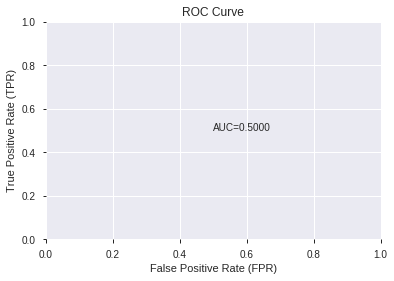

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


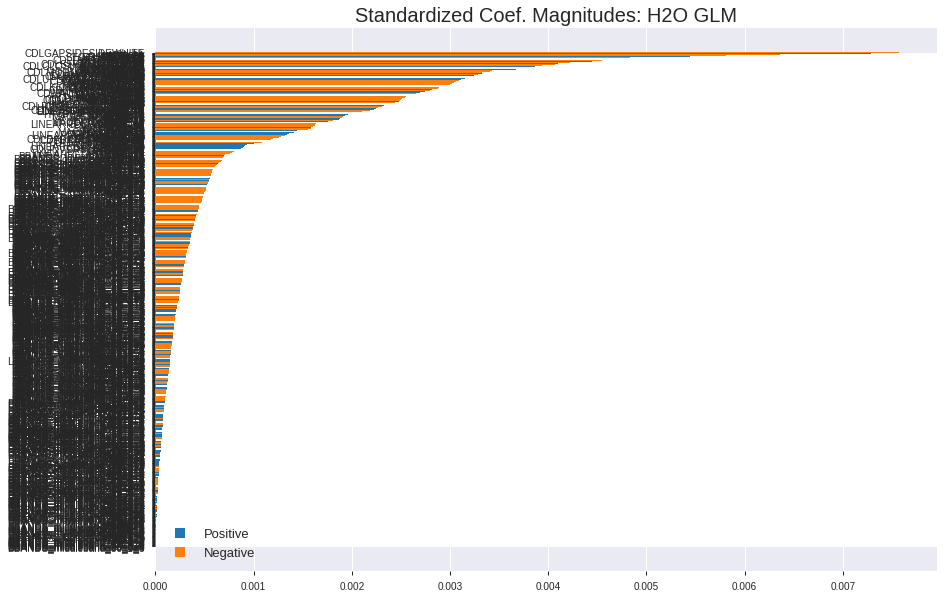

'log_likelihood'
--2019-09-06 01:48:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_014824_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_014824_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLGAPSIDESIDEWHITE',
 'weekday',
 'dayofweek',
 'ADX_24',
 'ADXR_14',
 'ADX_20',
 'ADXR_12',
 'STOCHRSI_fastd',
 'CDLHIKKAKE',
 'PLUS_DM_8',
 'CORREL_8',
 'EXP',
 'SINH',
 'COSH',
 'CDLEVENINGSTAR',
 'STOCHF_fastk',
 'DX_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLDOJI',
 'PLUS_DM_12',
 'aroondown_14',
 'CDLSTICKSANDWICH',
 'day',
 'ADX_14',
 'DX_24',
 'NATR_8',
 'CDLCLOSINGMARUBOZU',
 'aroondown_12',
 'is_quarter_end',
 'STOCHRSI_fastk',
 'VAR_12',
 'PLUS_DM_14',
 'DX_20',
 'MINUS_DI_30',
 'CDL2CROWS',
 'is_month_end',
 'is_quarter_start',
 'NATR_12',
 'CDLMORNINGDOJISTAR',
 'TRANGE',
 'VAR_8',
 'MINUS_DM_30',
 'MINUS_DI_24',
 'CDLHARAMICROSS',
 'NATR_30',
 'NATR_14',
 'MACDFIX_hist_24',
 'VAR_14',
 'CDLSHOOTINGSTAR',
 'NATR_24',
 'MACDFIX_hist_20',
 'dayofyear',
 'NATR_20',
 'CDLBREAKAWAY',
 'CDLUPSIDEGAP2CROWS',
 'CDLHIGHWAVE',
 'AD',
 'MFI_20',
 'CDLUNIQUE3RIVER',
 'aroondown_20',
 'MACDFIX_hist_8',
 'TAN',
 'MACDFIX_hist_14',
 'ADX_12',
 'MACD_hist',
 'MINUS_DM_8',
 'CDLLONGLINE

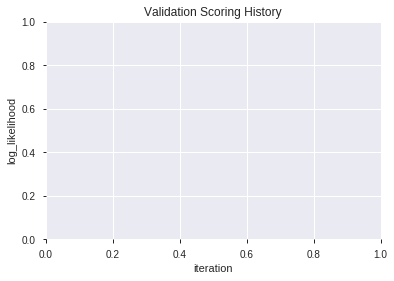

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_014911_model_7  0.523401  0.705374              0.489691  0.505669  0.255702
1  XGBoost_grid_1_AutoML_20190906_014911_model_4  0.518292  0.700495              0.494845  0.503385  0.253396
2               XGBoost_2_AutoML_20190906_014911  0.517653  0.706909              0.489691  0.505963  0.255999
3  XGBoost_grid_1_AutoML_20190906_014911_model_2  0.505884  0.698905              0.494845  0.502646  0.252653
4               XGBoost_1_AutoML_20190906_014911  0.505611  0.715964              0.477922  0.510422  0.260531
5  XGBoost_grid_1_AutoML_20190906_014911_model_1  0.504607  0.708269              0.489691  0.506916  0.256963
6  XGBoost_grid_1_AutoML_20190906_014911_model_6  0.504060  0.719880              0.500000  0.512459  0.262614
7  XGBoost_grid_1_AutoML_20190906_014911_model_3  0.491470  0.715779              0.494116  0.510354  0.260462
8  XGBoost_grid_1_AutoML_20190906_014911_model_5  0.479062  0.742741              0.500000  0.522281  0.272778
9               XGBoost_3_AutoML_20190906_014911  0.463096  0.717091              0.494845  0.511364  0.261494

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           171.634308           1.000000    0.020512
1                     BETA_8           134.027695           0.780891    0.016017
2                     TRANGE           131.405472           0.765613    0.015704
3                        DIV           122.453812           0.713458    0.014634
4       HT_PHASOR_quadrature           119.011971           0.693404    0.014223
..                       ...                  ...                ...         ...
273              MIDPOINT_24             3.943606           0.022977    0.000471
274  BBANDS_lowerband_30_5_3             3.942096           0.022968    0.000471
275  BBANDS_lowerband_12_4_2             3.623851           0.021114    0.000433
276  BBANDS_upperband_30_1_5             3.253995           0.018959    0.000389
277                  SAR_0.2             1.477132           0.008606    0.000177

[278 rows x 4 columns]

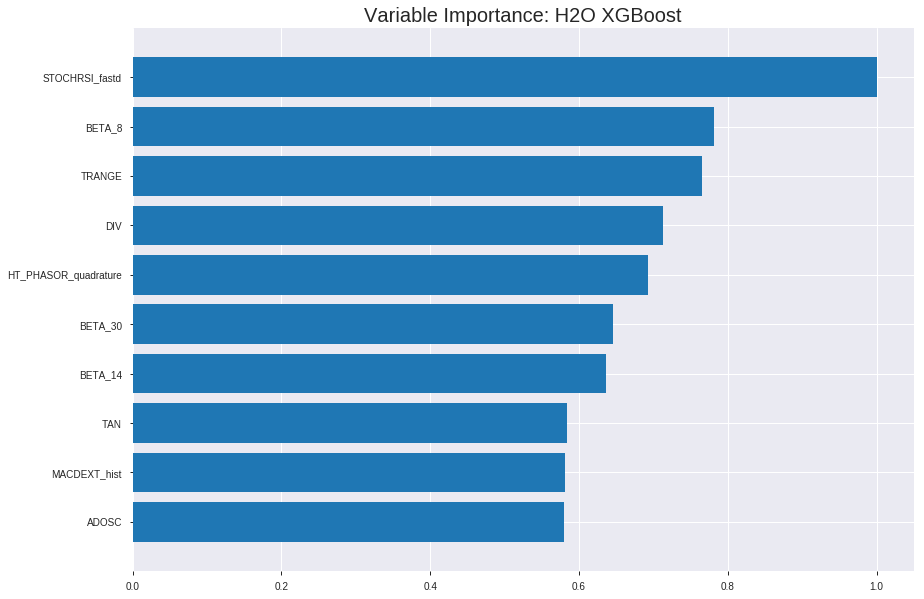

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_014911_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1275878153594942
RMSE: 0.3571943663602412
LogLoss: 0.4317009872989064
Mean Per-Class Error: 0.06611141116385721
AUC: 0.9817495286013437
pr_auc: 0.9850515457697316
Gini: 0.9634990572026874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5534726977348328: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      600  35   0.0551   (35.0/635.0)
1      65   766  0.0782   (65.0/831.0)
Total  665  801  0.0682   (100.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.553473     0.938725  206
max f2                       0.477598     0.957472  247
max f0point5                 0.585823     0.953818  188
max accuracy                 0.556274     0.931787  204
max precision                0.918158     1         0
max recall                   0.360272     1         315
max specificity              0.918158     1         0
max absolute_mcc             0.556274     0.863079  204
max min_per_class_accuracy   0.545381     0.925984  211
max mean_per_class_accuracy  0.556274     0.933889  204

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.868848           1.76414    1.76414            1                0.890183  1                           0.890183            0.0180505       0.0180505                  76.414     76.414
    2        0.0204638                   0.846267           1.76414    1.76414            1                0.855755  1                           0.872969            0.0180505       0.0361011                  76.414     76.414
    3        0.0300136                   0.83425            1.76414    1.76414            1                0.838216  1                           0.861911            0.0168472       0.0529483                  76.414     76.414
    4        0.0402456                   0.820474           1.76414    1.76414            1                0.828405  1                           0.853393            0.0180505       0.0709988                  76.414     76.414
    5        0.0504775                   0.81286            1.76414    1.76414            1                0.815988  1                           0.845811            0.0180505       0.0890493                  76.414     76.414
    6        0.100273                    0.777145           1.76414    1.76414            1                0.794483  1                           0.820321            0.087846        0.176895                   76.414     76.414
    7        0.150068                    0.755731           1.76414    1.76414            1                0.765359  1                           0.802084            0.087846        0.264741                   76.414     76.414
    8        0.200546                    0.736912           1.76414    1.76414            1                0.746104  1                           0.787994            0.0890493       0.353791                   76.414     76.414
    9        0.300136                    0.696024           1.73997    1.75612            0.986301         0.717579  0.995455                    0.764629            0.173285        0.527076                   73.9973    75.6121
    10       0.400409                    0.650366           1.74014    1.75212            0.986395         0.67225   0.993186                    0.741495            0.174489        0.701564                   74.0138    75.2118
    11       0.5                         0.590428           1.63122    1.72804            0.924658         0.621781  0.979536                    0.71765             0.162455        0.864019                   63.1225    72.8039
    12       0.600273                    0.512521           0.996079   1.60577            0.564626         0.550807  0.910227                    0.68978             0.0998797       0.963899                   -0.392118  60.5768
    13       0.699864                    0.429994           0.265829   1.41509            0.150685         0.466649  0.802144                    0.658028            0.0264741       0.990373                   -73.4171   41.5094
    14       0.800136                    0.36641            0.0840066  1.24828            0.047619         0.3986    0.707587                    0.625517            0.00842359      0.998797                   -91.5993   24.8283
    15       0.899727                    0.312178           0.0120831  1.11145            0.00684932       0.339792  0.630023                    0.59389             0.00120337      1                          -98.7917   11.1448
    16       1                           0.161967           0          1                  0                0.267374  0.566849          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2562515586856451
RMSE: 0.506212957840517
LogLoss: 0.7070690297187331
Mean Per-Class Error: 0.46054982817869417
AUC: 0.5234822451317297
pr_auc: 0.5432633969792926
Gini: 0.04696449026345939
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.356406033039093: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   178  0.9175   (178.0/194.0)
1      6    219  0.0267   (6.0/225.0)
Total  22   397  0.4391   (184.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356406     0.70418   378
max f2                       0.265457     0.854863  397
max f0point5                 0.373978     0.607609  365
max accuracy                 0.378015     0.568019  363
max precision                0.824122     1         0
max recall                   0.265457     1         397
max specificity              0.824122     1         0
max absolute_mcc             0.373978     0.134842  365
max min_per_class_accuracy   0.531694     0.515464  199
max mean_per_class_accuracy  0.412084     0.53945   342

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 53.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.786415           0.744889  0.744889           0.4              0.805426  0.4                         0.805426            0.00888889      0.00888889                 -25.5111  -25.5111
    2        0.0214797                   0.74416            0.931111  0.827654           0.5              0.753408  0.444444                    0.782307            0.00888889      0.0177778                  -6.88889  -17.2346
    3        0.0310263                   0.727864           1.39667   1.00274            0.75             0.735259  0.538462                    0.767831            0.0133333       0.0311111                  39.6667   0.273504
    4        0.0405728                   0.724227           0.931111  0.985882           0.5              0.726059  0.529412                    0.758002            0.00888889      0.04                       -6.88889  -1.41176
    5        0.0501193                   0.718585           0.465556  0.886772           0.25             0.72281   0.47619                     0.751299            0.00444444      0.0444444                  -53.4444  -11.3228
    6        0.100239                    0.689824           1.24148   1.06413            0.666667         0.704971  0.571429                    0.728135            0.0622222       0.106667                   24.1481   6.4127
    7        0.150358                    0.662552           0.886772  1.00501            0.47619          0.678048  0.539683                    0.711439            0.0444444       0.151111                   -11.3228  0.500882
    8        0.200477                    0.64028            0.97545   0.997619           0.52381          0.648428  0.535714                    0.695687            0.0488889       0.2                        -2.45503  -0.238095
    9        0.300716                    0.601973           1.06413   1.01979            0.571429         0.620403  0.547619                    0.670592            0.106667        0.306667                   6.4127    1.97884
    10       0.400955                    0.565734           1.01979   1.01979            0.547619         0.583119  0.547619                    0.648724            0.102222        0.408889                   1.97884   1.97884
    11       0.501193                    0.531694           1.06413   1.02866            0.571429         0.544642  0.552381                    0.627907            0.106667        0.515556                   6.4127    2.86561
    12       0.599045                    0.497511           0.908401  1.00901            0.487805         0.515392  0.541833                    0.609528            0.0888889       0.604444                   -9.15989  0.901284
    13       0.699284                    0.462874           1.10847   1.02327            0.595238         0.480418  0.549488                    0.591021            0.111111        0.715556                   10.8466   2.32689
    14       0.799523                    0.432301           1.10847   1.03395            0.595238         0.446685  0.555224                    0.572925            0.111111        0.826667                   10.8466   3.39502
    15       0.899761                    0.383615           1.06413   1.03731            0.571429         0.412393  0.557029                    0.555041            0.106667        0.933333                   6.4127    3.73121
    16       1                           0.180356           0.665079  1                  0.357143         0.340098  0.536993                    0.533495 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:49:45  21.917 sec  0                  0.5              0.693147            0.5             0                  1                0.433151                         0.5                0.693147              0.5               0                    1                  0.463007
    2019-09-06 01:49:46  22.558 sec  5                  0.478375         0.650634            0.839516        0.875496           1.76414          0.265348                         0.499757           0.69266               0.509668          0.544715             1.11733            0.458234
    2019-09-06 01:49:46  22.756 sec  10                 0.460488         0.61638             0.889125        0.912417           1.76414          0.186221                         0.501485           0.696149              0.497308          0.544921             0.744889           0.463007
    2019-09-06 01:49:46  22.973 sec  15                 0.44247          0.5826              0.919008        0.935672           1.76414          0.146658                         0.503322           0.69998               0.499702          0.537725             0.744889           0.455847
    2019-09-06 01:49:46  23.175 sec  20                 0.426618         0.553479            0.940571        0.953344           1.76414          0.126876                         0.502545           0.698582              0.51583           0.539192             0.372444           0.458234
    2019-09-06 01:49:47  23.370 sec  25                 0.413566         0.529689            0.94892         0.959443           1.76414          0.114598                         0.504441           0.702696              0.514433          0.539343             0.744889           0.458234
    2019-09-06 01:49:47  23.570 sec  30                 0.400279         0.506028            0.960923        0.969451           1.76414          0.10573                          0.504046           0.701875              0.517663          0.543434             1.11733            0.453461
    2019-09-06 01:49:47  23.768 sec  35                 0.387386         0.483549            0.971052        0.977357           1.76414          0.0914052                        0.504124           0.702144              0.516564          0.543944             0.744889           0.434368
    2019-09-06 01:49:47  23.958 sec  40                 0.376673         0.464979            0.974185        0.979341           1.76414          0.0825375                        0.503705           0.701285              0.524479          0.545344             1.11733            0.424821
    2019-09-06 01:49:47  24.150 sec  45                 0.366891         0.448116            0.978001        0.982334           1.76414          0.0777626                        0.50583            0.706134              0.520767          0.542407             0.744889           0.436754
    2019-09-06 01:49:48  24.347 sec  50                 0.357194         0.431701            0.98175         0.985052           1.76414          0.0682128                        0.506213           0.707069              0.523482          0.543263             0.744889           0.439141

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           171.63430786132812     1.0                   0.02051151198085661
BETA_8                   134.02769470214844     0.7808910489529638    0.0160172561063424
TRANGE                   131.4054718017578      0.7656130842321269    0.01570388194992785
DIV                      122.45381164550781     0.7134576599012147    0.014634095338897684
HT_PHASOR_quadrature     119.01197052001953     0.693404319934539     0.014222771015915027
---                      ---                    ---                   ---
MIDPOINT_24              3.943606376647949      0.022976795407560268  0.0004712888142838636
BBANDS_lowerband_30_5_3  3.9420957565307617     0.02296799401967919   0.0004711082845108927
BBANDS_lowerband_12_4_2  3.6238512992858887     0.021113793299494515  0.0004330758242239118
BBANDS_upperband_30_1_5  3.253994941711426      0.018958884049804833  0.0003888753773312431
SAR_0.2                  1.477131724357605      0.008606273085862606  0.00017652767351119462


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5571428571428572)

('F1', 0.7040498442367601)

('auc', 0.5234011495301524)

('logloss', 0.7053738233588325)

('mean_per_class_error', 0.4567557704588997)

('rmse', 0.5056693598647716)

('mse', 0.2557015015060478)

xgboost prediction progress: |████████████████████████████████████████████| 100%


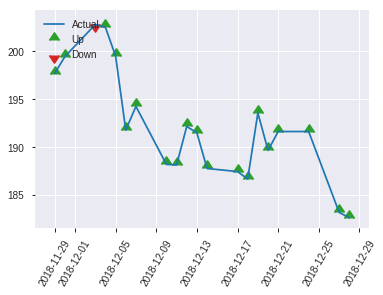


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2557015015060478
RMSE: 0.5056693598647716
LogLoss: 0.7053738233588325
Mean Per-Class Error: 0.4567557704588997
AUC: 0.5234011495301524
pr_auc: 0.5625105309639225
Gini: 0.04680229906030475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31561195850372314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    95   0.9794   (95.0/97.0)
1      0    113  0        (0.0/113.0)
Total  2    208  0.4524   (95.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.315612     0.70405   207
max f2                       0.315612     0.856061  207
max f0point5                 0.315612     0.597884  207
max accuracy                 0.472839     0.557143  143
max precision                0.746854     1         0
max recall                   0.315612     1         207
max specificity              0.746854     1         0
max absolute_mcc             0.315612     0.105837  207
max min_per_class_accuracy   0.530296     0.484536  104
max mean_per_class_accuracy  0.472839     0.543244  143

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 52.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.737078           1.23894   1.23894            0.666667         0.742052  0.666667                    0.742052            0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   0.710866           0.929204  1.11504            0.5              0.718017  0.6                         0.732438            0.00884956      0.0265487                  -7.07965  11.5044
    3        0.0333333                   0.694042           0         0.79646            0                0.698886  0.428571                    0.722852            0               0.0265487                  -100      -20.354
    4        0.0428571                   0.685031           1.85841   1.03245            1                0.689054  0.555556                    0.715341            0.0176991       0.0442478                  85.8407   3.24484
    5        0.052381                    0.670337           0.929204  1.01368            0.5              0.675501  0.545455                    0.708097            0.00884956      0.0530973                  -7.07965  1.36766
    6        0.1                         0.65062            1.30088   1.15044            0.7              0.659159  0.619048                    0.684793            0.0619469       0.115044                   30.0885   15.0442
    7        0.152381                    0.634466           1.35157   1.21958            0.727273         0.641215  0.65625                     0.669813            0.0707965       0.185841                   35.1569   21.958
    8        0.2                         0.619015           0.743363  1.10619            0.4              0.626669  0.595238                    0.659541            0.0353982       0.221239                   -25.6637  10.6195
    9        0.3                         0.586646           1.06195   1.09145            0.571429         0.600786  0.587302                    0.639956            0.106195        0.327434                   6.19469   9.14454
    10       0.4                         0.563205           0.884956  1.03982            0.47619          0.575585  0.559524                    0.623863            0.0884956       0.415929                   -11.5044  3.9823
    11       0.5                         0.530108           0.707965  0.973451           0.380952         0.547676  0.52381                     0.608626            0.0707965       0.486726                   -29.2035  -2.65487
    12       0.6                         0.510312           1.32743   1.03245            0.714286         0.520182  0.555556                    0.593885            0.132743        0.619469                   32.7434   3.24484
    13       0.7                         0.468955           1.15044   1.0493             0.619048         0.48738   0.564626                    0.57867             0.115044        0.734513                   15.0442   4.93047
    14       0.8                         0.427692           0.79646   1.0177             0.428571         0.450253  0.547619                    0.562618            0.079646        0.814159                   -20.354   1.76991
    15       0.9                         0.3722             0.79646   0.993117           0.428571         0.40479   0.534392                    0.545082            0.079646        0.893805                   -20.354   -0.688299
    16       1                           0.287234           1.06195   1                  0.571429         0.330929  0.538095                    0.523666        

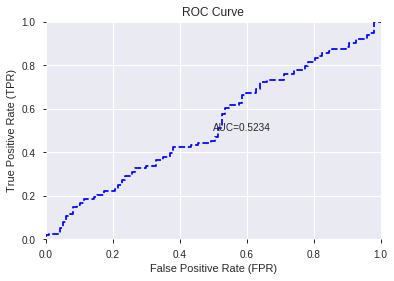

This function is available for GLM models only


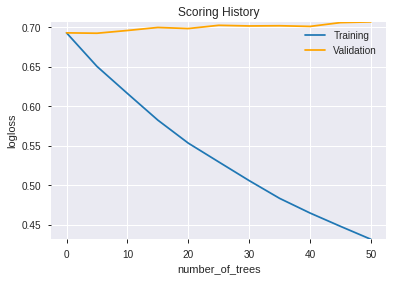

--2019-09-06 01:49:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_014911_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_014911_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHRSI_fastd',
 'BETA_8',
 'TRANGE',
 'DIV',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'BETA_14',
 'TAN',
 'MACDEXT_hist',
 'ADOSC',
 'day',
 'dayofweek',
 'BETA_20',
 'STOCHF_fastk',
 'CCI_24',
 'COS',
 'BETA_12',
 'STDDEV_14',
 'STDDEV_12',
 'MINUS_DM_8',
 'ROC_30',
 'PLUS_DM_8',
 'MFI_30',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'SIN',
 'STOCH_slowd',
 'MOM_24',
 'MFI_14',
 'CORREL_12',
 'STDDEV_30',
 'Volume',
 'LINEARREG_ANGLE_12',
 'MFI_24',
 'MFI_8',
 'MINUS_DI_14',
 'ADXR_12',
 'MFI_12',
 'CCI_14',
 'dayofyear',
 'MACDFIX_hist_8',
 'WILLR_30',
 'OBV',
 'MACDFIX_hist_24',
 'CORREL_30',
 'DX_14',
 'CORREL_14',
 'ATR_8',
 'MOM_30',
 'TRIX_8',
 'WILLR_12',
 'DX_30',
 'CORREL_8',
 'MINUS_DI_30',
 'HT_DCPERIOD',
 'MINUS_DM_12',
 'ADX_24',
 'NATR_12',
 'CCI_12',
 'week',
 'CCI_20',
 'STDDEV_24',
 'STOCH_slowk',
 'aroondown_12',
 'ROC_12',
 'ADX_14',
 'NATR_8',
 'MACDEXT_signal',
 'ADX_8',
 'PLUS_DM_30',
 'aroondown_20',
 'CORREL_24',
 'LINEARREG_ANGLE_8',
 'MFI_20',
 'MOM_12',
 'ROC_20',


In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

155

['BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_middleband_14_6_4',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'SAR_0.2',
 'TRIMA_20',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_0_3',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_0_4',
 'MAVP_20_1',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_lowerband_20_1_4',
 'MA_20_2',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_middleband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_20_3_3',
 'BBANDS_middleband_20_3_3',
 'BBANDS_upperband_20_3_4',
 'BBANDS_middleband_20_3_4',
 'BBANDS_middleband_20_3_5',
 'MAVP_20_5',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_upperband_20_6_4',
 'MA_20_7',
 'BBANDS_middleband_20_7_2',
 'BBANDS_upperband_24_0_3',
 'MAVP_24_1',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_24_3_2',
 'BBANDS_lowerband_24_3_2',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_middleband_30_1_5',
 'M

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_015056_model_1  0.547851  12.694048              0.494845  0.733547  0.538091
1               DeepLearning_1_AutoML_20190906_015056  0.540370   1.042376              0.477192  0.607667  0.369259
2  DeepLearning_grid_1_AutoML_20190906_015056_model_9  0.535626   0.689964              0.447769  0.498406  0.248408
3  DeepLearning_grid_1_AutoML_20190906_015056_model_3  0.512636   1.695063              0.500000  0.663006  0.439578
4  DeepLearning_grid_1_AutoML_20190906_015056_model_2  0.505520   1.785707              0.484536  0.674675  0.455186
5  DeepLearning_grid_1_AutoML_20190906_015056_model_6  0.502235   0.693247              0.483076  0.500049  0.250049
6  DeepLearning_grid_1_AutoML_20190906_015056_model_8  0.500000   0.690349              0.500000  0.498600  0.248602
7  DeepLearning_grid_1_AutoML_20190906_015056_model_5  0.484262   0.696601              0.494845  0.501722  0.251725
8  DeepLearning_grid_1_AutoML_20190906_015056_model_7  0.455068   0.913089              0.500000  0.563072  0.317050
9  DeepLearning_grid_1_AutoML_20190906_015056_model_4  0.454429   1.173598              0.482347  0.621319  0.386037

variable  relative_importance  scaled_importance  percentage
0                     BETA_12             1.000000           1.000000    0.009738
1                      BETA_8             0.917902           0.917902    0.008938
2                     CDLDOJI             0.839963           0.839963    0.008179
3                   CORREL_12             0.809396           0.809396    0.007882
4                      ADX_24             0.788492           0.788492    0.007678
..                        ...                  ...                ...         ...
150                    MOM_12             0.592596           0.592596    0.005771
151   BBANDS_lowerband_14_6_2             0.589577           0.589577    0.005741
152   BBANDS_lowerband_14_7_4             0.585074           0.585074    0.005697
153                     RSI_8             0.577044           0.577044    0.005619
154  BBANDS_middleband_20_3_4             0.573746           0.573746    0.005587

[155 rows x 4 columns]

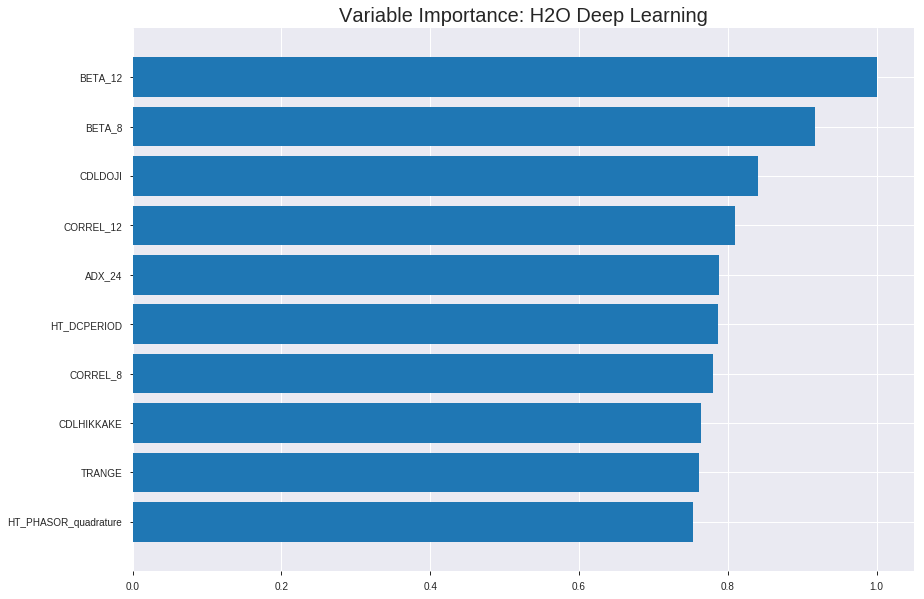

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_015056_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.34259093755621495
RMSE: 0.5853126835770902
LogLoss: 2.2468548747397463
Mean Per-Class Error: 0.37643385732018153
AUC: 0.6392156305371576
pr_auc: 0.5927779549761925
Gini: 0.27843126107431515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.7597879499908052e-05: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    635   1        (635.0/635.0)
1      0    831   0        (0.0/831.0)
Total  0    1466  0.4332   (635.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.75979e-05  0.723552  399
max f2                       2.75979e-05  0.867432  399
max f0point5                 0.497553     0.665965  213
max accuracy                 0.317532     0.618008  250
max precision                0.995316     0.737013  12
max recall                   2.75979e-05  1         399
max specificity              0.999973     0.937008  0
max absolute_mcc             0.911642     0.248644  82
max min_per_class_accuracy   0.450724     0.614922  223
max mean_per_class_accuracy  0.846732     0.623566  114

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 50.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.999999           1.41131   1.41131            0.8              1            0.8                         1                   0.0144404       0.0144404                  41.1312   41.1312
    2        0.0204638                   0.999998           1.41131   1.41131            0.8              0.999999     0.8                         0.999999            0.0144404       0.0288809                  41.1312   41.1312
    3        0.0300136                   0.999996           1.51212   1.44339            0.857143         0.999997     0.818182                    0.999999            0.0144404       0.0433213                  51.212    44.3387
    4        0.0402456                   0.999994           1.41131   1.43523            0.8              0.999995     0.813559                    0.999998            0.0144404       0.0577617                  41.1312   43.5232
    5        0.0504775                   0.999986           1.17609   1.3827             0.666667         0.999991     0.783784                    0.999996            0.0120337       0.0697954                  17.6093   38.2704
    6        0.100273                    0.999812           1.15998   1.2721             0.657534         0.999932     0.721088                    0.999964            0.0577617       0.127557                   15.9982   27.2101
    7        0.150068                    0.998759           1.20831   1.25094            0.684932         0.999383     0.709091                    0.999771            0.0601685       0.187726                   20.8315   25.0935
    8        0.200546                    0.995703           1.40654   1.2901             0.797297         0.99735      0.731293                    0.999162            0.0709988       0.258724                   40.6544   29.0102
    9        0.300136                    0.975899           1.26873   1.28301            0.719178         0.988831     0.727273                    0.995734            0.126354        0.385078                   26.8731   28.3011
    10       0.400409                    0.877783           1.18809   1.25924            0.673469         0.939196     0.713799                    0.981575            0.119134        0.504212                   18.8094   25.9241
    11       0.5                         0.512841           0.966652  1.20096            0.547945         0.728285     0.680764                    0.931125            0.0962696       0.600481                   -3.33482  20.0963
    12       0.600273                    0.128938           0.852067  1.14268            0.482993         0.288076     0.647727                    0.823706            0.0854392       0.685921                   -14.7933  14.2681
    13       0.699864                    0.0156435          0.761238  1.0884             0.431507         0.053092     0.616959                    0.714048            0.0758123       0.761733                   -23.8762  8.84019
    14       0.800136                    0.00090182         0.948075  1.07082            0.537415         0.00538517   0.606991                    0.625238            0.0950662       0.856799                   -5.1925   7.08162
    15       0.899727                    1.68635e-05        0.688739  1.02852            0.390411         0.000267424  0.583017                    0.55606             0.0685921       0.925391                   -31.1261  2.85241
    16       1                           1.17107e-11        0.744059  1                  0.421769         2.60



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.5326153878602659
RMSE: 0.7298050341428632
LogLoss: 7.507235064258402
Mean Per-Class Error: 0.45620847651775487
AUC: 0.5147766323024054
pr_auc: 0.552324126710031
Gini: 0.02955326460481089
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6948609241525872e-12: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    194  1        (194.0/194.0)
1      0    225  0        (0.0/225.0)
Total  0    419  0.463    (194.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.69486e-12  0.698758  399
max f2                       1.69486e-12  0.852919  399
max f0point5                 5.40279e-09  0.598975  333
max accuracy                 2.45379e-08  0.558473  293
max precision                0.0150922    0.833333  11
max recall                   1.69486e-12  1         399
max specificity              0.99933      0.994845  0
max absolute_mcc             0.0150922    0.102048  11
max min_per_class_accuracy   7.90092e-07  0.502222  208
max mean_per_class_accuracy  2.45379e-08  0.543792  293

Gains/Lift Table: Avg response rate: 53.70 %, avg score:  0.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.107624           1.48978   1.48978            0.8              0.557102     0.8                         0.557102            0.0177778       0.0177778                  48.9778   48.9778
    2        0.0214797                   0.030304           1.39667   1.4484             0.75             0.0437957    0.777778                    0.328966            0.0133333       0.0311111                  39.6667   44.8395
    3        0.0310263                   0.0138455          1.39667   1.43248            0.75             0.0192892    0.769231                    0.233681            0.0133333       0.0444444                  39.6667   43.2479
    4        0.0405728                   0.00849709         0.931111  1.31451            0.5              0.0120588    0.705882                    0.181534            0.00888889      0.0533333                  -6.88889  31.451
    5        0.0501193                   0.00586955         1.39667   1.33016            0.75             0.00704336   0.714286                    0.148298            0.0133333       0.0666667                  39.6667   33.0159
    6        0.100239                    0.00129243         0.709418  1.01979            0.380952         0.00279542   0.547619                    0.0755467           0.0355556       0.102222                   -29.0582  1.97884
    7        0.150358                    0.000302763        1.1528    1.06413            0.619048         0.000673548  0.571429                    0.050589            0.0577778       0.16                       15.2804   6.4127
    8        0.200477                    0.00012309         0.620741  0.95328            0.333333         0.000201445  0.511905                    0.0379921           0.0311111       0.191111                   -37.9259  -4.67196
    9        0.300716                    2.06561e-05        0.886772  0.931111           0.47619          5.51438e-05  0.5                         0.0253465           0.0888889       0.28                       -11.3228  -6.88889
    10       0.400955                    3.19352e-06        1.06413   0.964365           0.571429         9.77163e-06  0.517857                    0.0190123           0.106667        0.386667                   6.4127    -3.56349
    11       0.501193                    7.84087e-07        1.1528    1.00205            0.619048         1.64145e-06  0.538095                    0.0152102           0.115556        0.502222                   15.2804   0.205291
    12       0.599045                    1.39802e-07        1.1355    1.02385            0.609756         3.87899e-07  0.549801                    0.0127257           0.111111        0.613333                   13.5501   2.38513
    13       0.699284                    2.53447e-08        1.24148   1.05505            0.666667         7.28113e-08  0.566553                    0.0109015           0.124444        0.737778                   24.1481   5.50474
    14       0.799523                    5.24659e-09        0.931111  1.03951            0.5              1.14828e-08  0.558209                    0.00953478          0.0933333       0.831111                   -6.88889  3.95091
    15       0.899761                    7.49986e-10        0.709418  1.00274            0.380952         2.34885e-09  0.538462                    0.00847255          0.0711111       0.902222                   -29.0582  0.273504
    16       1                           2.4761e-13         0.97545   1                  0.52381          1


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:50:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:51:02  4.725 sec         976 obs/sec       3         1             4398       0.656785         5.01804             -0.756871      0.548953        0.481255           0.940874         0.433151                         0.732798           15.5715               -1.15979         0.528648          0.562566             1.11733            0.463007
    2019-09-06 01:51:10  13.421 sec        1011 obs/sec      9         3             13194      0.649682         4.22825             -0.719075      0.565603        0.509303           1.17609          0.433151                         0.732798           13.1492               -1.15979         0.543414          0.576584             1.48978            0.460621
    2019-09-06 01:51:19  22.328 sec        1018 obs/sec      15        5             21990      0.635529         3.59362             -0.644991      0.584163        0.541371           1.17609          0.433151                         0.732798           11.4627               -1.15979         0.5189            0.546348             1.11733            0.463007
    2019-09-06 01:51:24  27.299 sec        999 obs/sec       18        6             26388      0.623197         3.01653             -0.58177       0.59586         0.544199           1.2937           0.433151                         0.732958           8.99516               -1.16074         0.508339          0.545655             1.48978            0.463007
    2019-09-06 01:51:32  35.442 sec        1024 obs/sec      24        8             35184      0.628603         3.47565             -0.609334      0.595544        0.561853           1.2937           0.433151                         0.732798           11.9769               -1.15979         0.510263          0.546742             1.48978            0.458234
    2019-09-06 01:51:40  43.346 sec        1044 obs/sec      30        10            43980      0.617863         3.35322             -0.554812      0.60036         0.563999           1.52892          0.433151                         0.732802           11.6937               -1.15982         0.51449           0.543124             0.744889           0.455847
    2019-09-06 01:51:48  51.091 sec        1062 obs/sec      36        12            52776      0.597188         2.44673             -0.452497      0.624595        0.574269           1.41131          0.433151                         0.733918           8.37474               -1.1664          0.530619          0.555798             1.11733            0.458234
    2019-09-06 01:51:56  58.681 sec        1078 obs/sec      42        14            61572      0.585313         2.24685             -0.395305      0.639216        0.592778           1.41131          0.433151                         0.729805           7.50724               -1.14219         0.514777          0.552324             1.48978            0.463007
    2019-09-06 01:52:03

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BETA_12                   1.0                    1.0                  0.00973781820126349
BETA_8                    0.9179015755653381     0.9179015755653381   0.008938358669508586
CDLDOJI                   0.8399631381034851     0.8399631381034851   0.008179408334614518
CORREL_12                 0.8093963861465454     0.8093963861465454   0.007881754861054724
ADX_24                    0.7884924411773682     0.7884924411773682   0.007678196045255659
---                       ---                    ---                  ---
MOM_12                    0.5925963521003723     0.5925963521003723   0.005770595543485354
BBANDS_lowerband_14_6_2   0.5895772576332092     0.5895772576332092   0.00574119615043168
BBANDS_lowerband_14_7_4   0.5850737690925598     0.5850737690925598   0.005697341997751362
RSI_8                     0.5770442485809326     0.5770442485809326   0.00561915198676582
BBANDS_middleband_20_3_4  0.5737462639808655     0.5737462639808655   0.0055870368122997996


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5714285714285714)

('F1', 0.7018633540372671)

('auc', 0.5478514734057112)

('logloss', 12.694048461970143)

('mean_per_class_error', 0.4274245050634067)

('rmse', 0.7335469123016828)

('mse', 0.5380910725473327)

deeplearning prediction progress: |███████████████████████████████████████| 100%


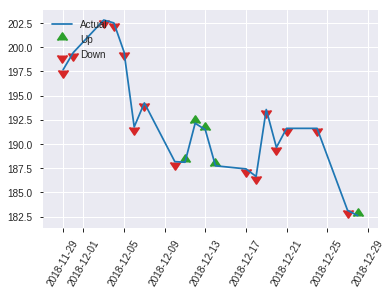


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5380910725473327
RMSE: 0.7335469123016828
LogLoss: 12.694048461970143
Mean Per-Class Error: 0.4274245050634067
AUC: 0.5478514734057112
pr_auc: 0.5556903462297307
Gini: 0.09570294681142233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.547705434522674e-22: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      1    96   0.9897   (96.0/97.0)
1      0    113  0        (0.0/113.0)
Total  1    209  0.4571   (96.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.54771e-22  0.701863  208
max f2                       2.54771e-22  0.854766  208
max f0point5                 2.29503e-12  0.605144  136
max accuracy                 4.28646e-11  0.571429  102
max precision                3.80385e-10  0.616438  72
max recall                   2.54771e-22  1         208
max specificity              0.00039633   0.989691  0
max absolute_mcc             4.28646e-11  0.144755  102
max min_per_class_accuracy   2.98375e-11  0.56701   106
max mean_per_class_accuracy  4.28646e-11  0.572575  102

Gains/Lift Table: Avg response rate: 53.81 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.000264169        0.619469  0.619469           0.333333         0.000352289  0.333333                    0.000352289         0.00884956      0.00884956                 -38.0531  -38.0531
    2        0.0238095                   2.34981e-05        0.929204  0.743363           0.5              9.19504e-05  0.4                         0.000248154         0.00884956      0.0176991                  -7.07965  -25.6637
    3        0.0333333                   1.05841e-05        0.929204  0.79646            0.5              1.44417e-05  0.428571                    0.000181379         0.00884956      0.0265487                  -7.07965  -20.354
    4        0.0428571                   4.1874e-06         0.929204  0.825959           0.5              7.60689e-06  0.444444                    0.000142763         0.00884956      0.0353982                  -7.07965  -17.4041
    5        0.052381                    2.62126e-06        0.929204  0.84473            0.5              2.93474e-06  0.454545                    0.00011734          0.00884956      0.0442478                  -7.07965  -15.527
    6        0.1                         3.79475e-07        1.30088   1.06195            0.7              1.13219e-06  0.571429                    6.20027e-05         0.0619469       0.106195                   30.0885   6.19469
    7        0.152381                    1.03774e-07        1.01368   1.04535            0.545455         2.11529e-07  0.5625                      4.0762e-05          0.0530973       0.159292                   1.36766   4.5354
    8        0.2                         1.81148e-08        1.11504   1.06195            0.6              5.71371e-08  0.571429                    3.10704e-05         0.0530973       0.212389                   11.5044   6.19469
    9        0.3                         9.91526e-10        0.973451  1.03245            0.52381          4.18746e-09  0.555556                    2.0715e-05          0.0973451       0.309735                   -2.65487  3.24484
    10       0.4                         1.35905e-10        1.32743   1.10619            0.714286         4.58396e-10  0.595238                    1.55363e-05         0.132743        0.442478                   32.7434   10.6195
    11       0.5                         3.5678e-11         1.15044   1.11504            0.619048         7.14924e-11  0.6                         1.24291e-05         0.115044        0.557522                   15.0442   11.5044
    12       0.6                         6.42016e-12        0.973451  1.09145            0.52381          1.58732e-11  0.587302                    1.03576e-05         0.0973451       0.654867                   -2.65487  9.14454
    13       0.7                         8.52216e-13        0.884956  1.06195            0.47619          2.69927e-12  0.571429                    8.87792e-06         0.0884956       0.743363                   -11.5044  6.19469
    14       0.8                         7.05687e-14        0.619469  1.00664            0.333333         3.03174e-13  0.541667                    7.76818e-06         0.0619469       0.80531                    -38.0531  0.663717
    15       0.9                         1.48579e-15        1.06195   1.01278            0.571429         2.35481e-14  0.544974                    6.90505e-06         0.106195        0.911504                   6.19469   1.27827
    16       1                           3.51705e-24        0.884956  1                  0.47619          1

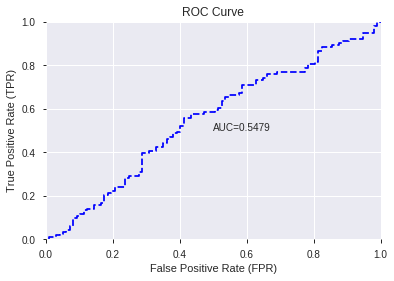

This function is available for GLM models only


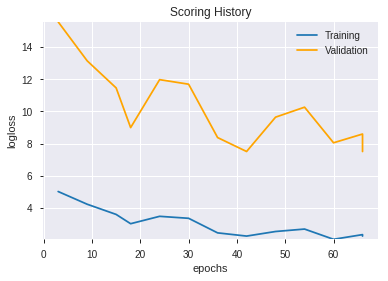

--2019-09-06 02:01:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_015056_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_015056_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BETA_12',
 'BETA_8',
 'CDLDOJI',
 'CORREL_12',
 'ADX_24',
 'HT_DCPERIOD',
 'CORREL_8',
 'CDLHIKKAKE',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'MFI_24',
 'CDLLONGLINE',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'MFI_20',
 'CDLGAPSIDESIDEWHITE',
 'CDLTAKURI',
 'ADX_20',
 'STOCHF_fastk',
 'ADX_14',
 'MFI_14',
 'aroondown_12',
 'NATR_24',
 'NATR_20',
 'CDLSHORTLINE',
 'aroonup_12',
 'PLUS_DM_30',
 'CDLENGULFING',
 'AD',
 'STDDEV_8',
 'MACDFIX_signal_14',
 'PLUS_DI_20',
 'aroondown_30',
 'ROCR_12',
 'PLUS_DI_30',
 'MINUS_DM_12',
 'aroondown_20',
 'MINUS_DI_24',
 'LINEARREG_ANGLE_8',
 'WILLR_30',
 'WILLR_8',
 'AROONOSC_30',
 'NATR_8',
 'ROCP_8',
 'PLUS_DM_20',
 'MACDEXT_hist',
 'ROCR_20',
 'STOCHF_fastd',
 'TRIX_8',
 'STOCH_slowd',
 'ROCP_24',
 'NATR_14',
 'AROONOSC_14',
 'MINUS_DI_20',
 'aroonup_24',
 'VAR_8',
 'BBANDS_upperband_20_6_4',
 'ROCR100_20',
 'PLUS_DM_14',
 'aroonup_20',
 'MINUS_DM_24',
 'BBANDS_upperband_20_0_2',
 'ATR_12',
 'PLUS_DM_24',
 'PLUS_DM_12',
 'ROCR_24',
 'ROCR100_8',


In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_020156_model_1  0.571207  0.688718              0.494116  0.497778  0.247783

variable  relative_importance  scaled_importance  percentage
0    CDLGAPSIDESIDEWHITE             0.008600           1.000000    0.025844
1                 ADX_24             0.008580           0.997685    0.025784
2                 ADX_20             0.007929           0.922013    0.023828
3         STOCHRSI_fastd             0.007029           0.817393    0.021125
4             CDLHIKKAKE             0.006111           0.710594    0.018364
..                   ...                  ...                ...         ...
150         MACDEXT_hist             0.000313           0.036340    0.000939
151          AROONOSC_30             0.000290           0.033664    0.000870
152           aroonup_24             0.000279           0.032396    0.000837
153           ROCR100_14             0.000158           0.018428    0.000476
154              ROCR_14             0.000156           0.018161    0.000469

[155 rows x 4 columns]

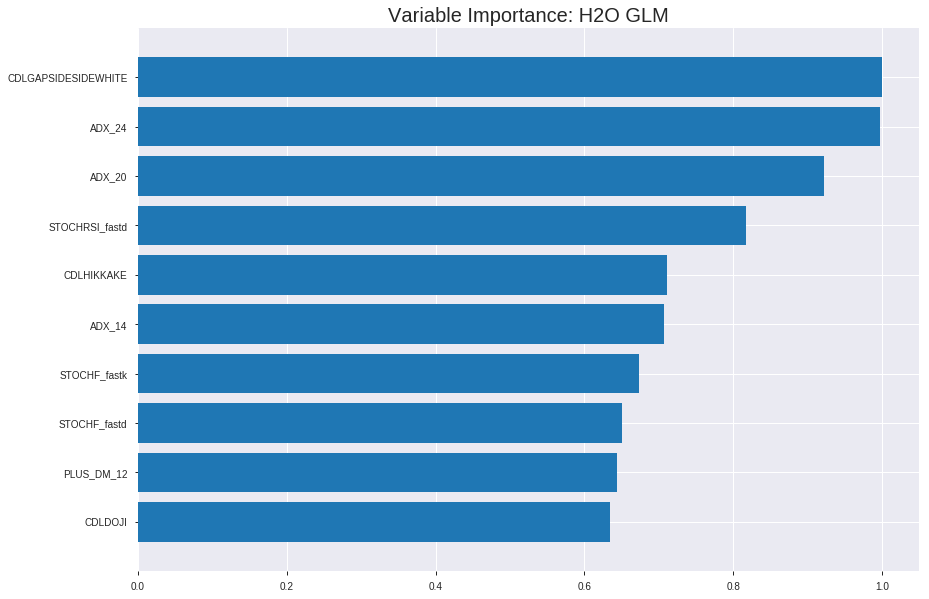

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_020156_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24274487377653528
RMSE: 0.49269145900506056
LogLoss: 0.6785012022230784
Null degrees of freedom: 1465
Residual degrees of freedom: 1310
Null deviance: 2006.0242636899413
Residual deviance: 1989.3655249180656
AIC: 2301.3655249180656
AUC: 0.5812293318930801
pr_auc: 0.6380668271297525
Gini: 0.16245866378616025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5084551990551712: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    626   0.9858   (626.0/635.0)
1      4    827   0.0048   (4.0/831.0)
Total  13   1453  0.4297   (630.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508455     0.724168  387
max f2                       0.456984     0.867432  399
max f0point5                 0.548608     0.630236  276
max accuracy                 0.548608     0.582538  276
max precision                0.623101     1         0
max recall                   0.456984     1         399
max specificity              0.623101     1         0
max absolute_mcc             0.577058     0.128376  145
max min_per_class_accuracy   0.567828     0.559567  189
max mean_per_class_accuracy  0.573365     0.563234  163

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.611472           1.52892   1.52892            0.866667         0.617235  0.866667                    0.617235            0.0156438       0.0156438                  52.8921   52.8921
    2        0.0204638                   0.608124           1.05848   1.2937             0.6              0.60983   0.733333                    0.613533            0.0108303       0.0264741                  5.84838   29.3702
    3        0.0300136                   0.606123           1.51212   1.3632             0.857143         0.607338  0.772727                    0.611562            0.0144404       0.0409146                  51.212    36.3199
    4        0.0402456                   0.60479            1.2937    1.34553            0.733333         0.605554  0.762712                    0.610034            0.0132371       0.0541516                  29.3702   34.553
    5        0.0504775                   0.602722           0.823265  1.23967            0.466667         0.603718  0.702703                    0.608754            0.00842359      0.0625752                  -17.6735  23.9666
    6        0.100273                    0.596582           1.20831   1.2241             0.684932         0.599199  0.693878                    0.604009            0.0601685       0.122744                   20.8315   22.4097
    7        0.150068                    0.592485           1.11165   1.18678            0.630137         0.594729  0.672727                    0.60093             0.055355        0.178099                   11.165    18.6785
    8        0.200546                    0.588149           1.14431   1.17609            0.648649         0.590068  0.666667                    0.598196            0.0577617       0.23586                    14.4307   17.6093
    9        0.300136                    0.581405           1.09957   1.1507             0.623288         0.585042  0.652273                    0.593831            0.109507        0.345367                   9.95665   15.07
    10       0.400409                    0.574788           1.06808   1.13001            0.605442         0.578137  0.640545                    0.589901            0.1071          0.452467                   6.80845   13.0011
    11       0.5                         0.568017           1.01498   1.1071             0.575342         0.571228  0.627558                    0.586182            0.101083        0.55355                    1.49844   10.71
    12       0.600273                    0.56137            0.936074  1.07853            0.530612         0.564878  0.611364                    0.582623            0.0938628       0.647413                   -6.39259  7.85308
    13       0.699864                    0.554748           0.918319  1.05573            0.520548         0.55814   0.598441                    0.579139            0.0914561       0.738869                   -8.16808  5.57327
    14       0.800136                    0.546437           0.960076  1.04374            0.544218         0.55069   0.591645                    0.575574            0.0962696       0.835138                   -3.9924   4.3745
    15       0.899727                    0.535892           0.857903  1.02317            0.486301         0.541133  0.579985                    0.571761            0.0854392       0.920578                   -14.2097  2.31742
    16       1                           0.456984           0.792063  1                  0.44898          0.522766  0.566849                    0.566849            0.0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24892491615548365
RMSE: 0.49892375785833615
LogLoss: 0.69098763764822
Null degrees of freedom: 418
Residual degrees of freedom: 263
Null deviance: 580.0755282349307
Residual deviance: 579.0476403492082
AIC: 891.0476403492082
AUC: 0.5048339060710195
pr_auc: 0.5645897133335561
Gini: 0.009667812142039045
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4695589137515211: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    192  0.9897   (192.0/194.0)
1      0    225  0        (0.0/225.0)
Total  2    417  0.4582   (192.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469559     0.700935  397
max f2                       0.469559     0.854214  397
max f0point5                 0.480434     0.596454  389
max accuracy                 0.482085     0.546539  387
max precision                0.564397     1         0
max recall                   0.469559     1         397
max specificity              0.564397     1         0
max absolute_mcc             0.545849     0.106317  57
max min_per_class_accuracy   0.526993     0.515556  196
max mean_per_class_accuracy  0.545849     0.537342  57

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.560758           1.11733   1.11733            0.6              0.562176  0.6                         0.562176            0.0133333       0.0133333                  11.7333   11.7333
    2        0.0214797                   0.557044           1.86222   1.4484             1                0.558131  0.777778                    0.560378            0.0177778       0.0311111                  86.2222   44.8395
    3        0.0310263                   0.554827           1.39667   1.43248            0.75             0.556247  0.769231                    0.559107            0.0133333       0.0444444                  39.6667   43.2479
    4        0.0405728                   0.552203           0.465556  1.20497            0.25             0.553898  0.647059                    0.557881            0.00444444      0.0488889                  -53.4444  20.4967
    5        0.0501193                   0.551902           1.39667   1.24148            0.75             0.552043  0.666667                    0.556769            0.0133333       0.0622222                  39.6667   24.1481
    6        0.100239                    0.548472           1.24148   1.24148            0.666667         0.55032   0.666667                    0.553544            0.0622222       0.124444                   24.1481   24.1481
    7        0.150358                    0.545098           1.06413   1.18236            0.571429         0.546742  0.634921                    0.551277            0.0533333       0.177778                   6.4127    18.2363
    8        0.200477                    0.542099           0.798095  1.0863             0.428571         0.543931  0.583333                    0.54944             0.04            0.217778                   -20.1905  8.62963
    9        0.300716                    0.536253           1.06413   1.07891            0.571429         0.538811  0.579365                    0.545897            0.106667        0.324444                   6.4127    7.89065
    10       0.400955                    0.531032           1.01979   1.06413            0.547619         0.533522  0.571429                    0.542803            0.102222        0.426667                   1.97884   6.4127
    11       0.501193                    0.526981           0.886772  1.02866            0.47619          0.528745  0.552381                    0.539992            0.0888889       0.515556                   -11.3228  2.86561
    12       0.599045                    0.521564           0.590461  0.957078           0.317073         0.523819  0.513944                    0.53735             0.0577778       0.573333                   -40.9539  -4.29216
    13       0.699284                    0.515932           0.97545   0.959712           0.52381          0.518803  0.515358                    0.534691            0.0977778       0.671111                   -2.45503  -4.02882
    14       0.799523                    0.5084             1.10847   0.978362           0.595238         0.511947  0.525373                    0.53184             0.111111        0.782222                   10.8466   -2.16385
    15       0.899761                    0.497859           1.19714   1.00274            0.642857         0.504123  0.538462                    0.528752            0.12            0.902222                   19.7143   0.273504
    16       1                           0.466934           0.97545   1                  0.52381          0.486284  0.536993                    0.524495      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:01:57  0.000 sec   2            3.8       156           1.357             1.38198
    2019-09-06 02:01:57  0.068 sec   4            2.8       156           1.3547            1.38306
    2019-09-06 02:01:57  0.164 sec   6            2         156           1.35211           1.38443
    2019-09-06 02:01:57  0.213 sec   8            1.5       156           1.3492            1.38604
    2019-09-06 02:01:57  0.260 sec   10           1.1       156           1.34595           1.38791
    2019-09-06 02:01:57  0.311 sec   12           0.78      156           1.34235           1.39003

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5904761904761905)

('F1', 0.7)

('auc', 0.5712070066599763)

('logloss', 0.6887184666226436)

('mean_per_class_error', 0.40826566919076734)

('rmse', 0.49777817173209954)

('mse', 0.2477831082529516)

glm prediction progress: |████████████████████████████████████████████████| 100%


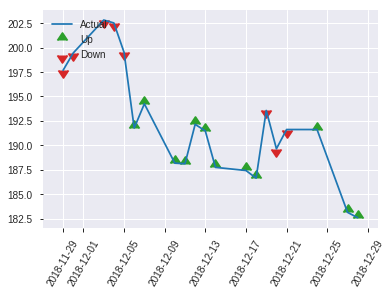


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2477831082529516
RMSE: 0.49777817173209954
LogLoss: 0.6887184666226436
Null degrees of freedom: 209
Residual degrees of freedom: 54
Null deviance: 290.6054272050573
Residual deviance: 289.2617559815103
AIC: 601.2617559815103
AUC: 0.5712070066599763
pr_auc: 0.5780820007307828
Gini: 0.14241401331995251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4383606739335715: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    95   0.9794   (95.0/97.0)
1      1    112  0.0088   (1.0/113.0)
Total  3    207  0.4571   (96.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438361     0.7       206
max f2                       0.403148     0.853474  209
max f0point5                 0.488779     0.62069   152
max accuracy                 0.505732     0.590476  102
max precision                0.548191     1         0
max recall                   0.403148     1         209
max specificity              0.548191     1         0
max absolute_mcc             0.505732     0.182969  102
max min_per_class_accuracy   0.505177     0.584071  105
max mean_per_class_accuracy  0.505732     0.591734  102

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 50.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.541484           1.85841   1.85841            1                0.543986  1                           0.543986            0.0265487       0.0265487                  85.8407   85.8407
    2        0.0238095                   0.53842            0.929204  1.48673            0.5              0.539408  0.8                         0.542155            0.00884956      0.0353982                  -7.07965  48.6726
    3        0.0333333                   0.53457            1.85841   1.59292            1                0.535057  0.857143                    0.540127            0.0176991       0.0530973                  85.8407   59.292
    4        0.0428571                   0.533218           0         1.23894            0                0.533819  0.666667                    0.538725            0               0.0530973                  -100      23.8938
    5        0.052381                    0.532068           0         1.01368            0                0.532724  0.545455                    0.537634            0               0.0530973                  -100      1.36766
    6        0.1                         0.528583           0.743363  0.884956           0.4              0.530666  0.47619                     0.534316            0.0353982       0.0884956                  -25.6637  -11.5044
    7        0.152381                    0.525901           1.18262   0.987279           0.636364         0.527347  0.53125                     0.53192             0.0619469       0.150442                   18.2623   -1.27212
    8        0.2                         0.521289           0.557522  0.884956           0.3              0.52318   0.47619                     0.529839            0.0265487       0.176991                   -44.2478  -11.5044
    9        0.3                         0.514414           1.50442   1.09145            0.809524         0.517844  0.587302                    0.525841            0.150442        0.327434                   50.4425   9.14454
    10       0.4                         0.510318           1.32743   1.15044            0.714286         0.512474  0.619048                    0.522499            0.132743        0.460177                   32.7434   15.0442
    11       0.5                         0.50534            1.15044   1.15044            0.619048         0.507383  0.619048                    0.519476            0.115044        0.575221                   15.0442   15.0442
    12       0.6                         0.49795            0.973451  1.12094            0.52381          0.502517  0.603175                    0.516649            0.0973451       0.672566                   -2.65487  12.0944
    13       0.7                         0.49019            0.79646   1.07459            0.428571         0.494441  0.578231                    0.513477            0.079646        0.752212                   -20.354   7.45891
    14       0.8                         0.480845           1.06195   1.07301            0.571429         0.486457  0.577381                    0.510099            0.106195        0.858407                   6.19469   7.30088
    15       0.9                         0.46671            0.442478  1.00295            0.238095         0.473793  0.539683                    0.506065            0.0442478       0.902655                   -55.7522  0.294985
    16       1                           0.403148           0.973451  1                  0.52381          0.448557  0.538095                    0.500314      

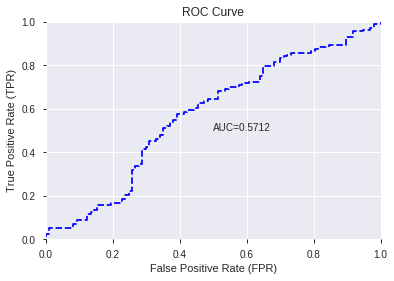

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


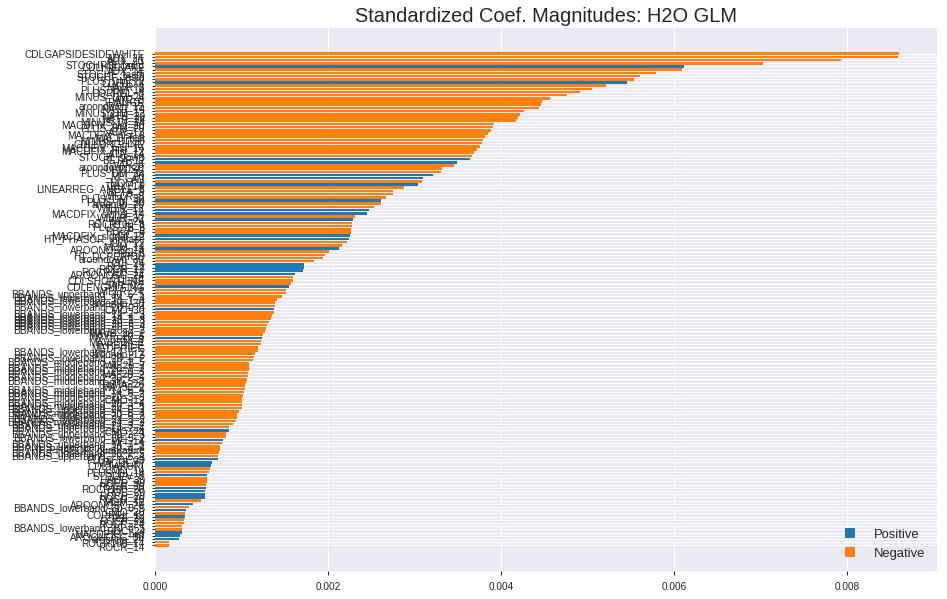

'log_likelihood'
--2019-09-06 02:02:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_020156_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_020156_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLGAPSIDESIDEWHITE',
 'ADX_24',
 'ADX_20',
 'STOCHRSI_fastd',
 'CDLHIKKAKE',
 'ADX_14',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'PLUS_DM_12',
 'CDLDOJI',
 'NATR_8',
 'PLUS_DM_14',
 'CORREL_8',
 'MINUS_DM_24',
 'ATR_8',
 'TRANGE',
 'aroondown_12',
 'NATR_14',
 'MINUS_DM_12',
 'NATR_20',
 'NATR_24',
 'MINUS_DI_24',
 'MACDFIX_hist_20',
 'PLUS_DM_20',
 'ATR_12',
 'MACDFIX_hist_8',
 'MACD_hist',
 'MINUS_DI_20',
 'CDLLONGLINE',
 'MACDFIX_hist_14',
 'MACDFIX_hist_12',
 'ATR_14',
 'STOCH_slowd',
 'BETA_12',
 'VAR_8',
 'aroondown_20',
 'ULTOSC',
 'PLUS_DM_24',
 'MFI_20',
 'AD',
 'MOM_8',
 'TRIX_14',
 'LINEARREG_ANGLE_8',
 'BETA_8',
 'WILLR_8',
 'PLUS_DM_30',
 'PLUS_DI_30',
 'aroonup_20',
 'WILLR_12',
 'TRIX_12',
 'MACDFIX_signal_14',
 'WILLR_30',
 'MFI_24',
 'ROCR100_8',
 'PLUS_DI_8',
 'ROCP_8',
 'ROC_8',
 'MACDFIX_signal_12',
 'HT_PHASOR_inphase',
 'CCI_12',
 'MOM_14',
 'AROONOSC_14',
 'RSI_8',
 'HT_DCPERIOD',
 'aroondown_30',
 'CCI_24',
 'ROC_12',
 'ROCR_12',
 'ROCR100_12',
 'AROONOSC_24',
 'CC

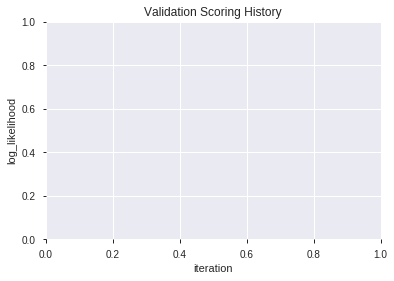

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_020219_model_7  0.519113  0.715991              0.494845  0.510173  0.260277
1               XGBoost_1_AutoML_20190906_020219  0.483533  0.722669              0.459538  0.513455  0.263636
2               XGBoost_2_AutoML_20190906_020219  0.479792  0.718998              0.500000  0.512068  0.262213
3  XGBoost_grid_1_AutoML_20190906_020219_model_4  0.479518  0.706569              0.500000  0.506481  0.256523
4               XGBoost_3_AutoML_20190906_020219  0.469483  0.717219              0.494845  0.511540  0.261673
5  XGBoost_grid_1_AutoML_20190906_020219_model_2  0.468205  0.707099              0.489691  0.506807  0.256853
6  XGBoost_grid_1_AutoML_20190906_020219_model_1  0.462367  0.719064              0.483806  0.512138  0.262285
7  XGBoost_grid_1_AutoML_20190906_020219_model_6  0.461728  0.720612              0.482347  0.512868  0.263033
8  XGBoost_grid_1_AutoML_20190906_020219_model_3  0.451692  0.731665              0.494845  0.518213  0.268545
9  XGBoost_grid_1_AutoML_20190906_020219_model_5  0.419852  0.779413              0.483076  0.538410  0.289886

variable  relative_importance  scaled_importance  percentage
0                      BETA_8           294.370483           1.000000    0.038799
1                      TRANGE           226.817841           0.770518    0.029895
2        HT_PHASOR_quadrature           190.893234           0.648480    0.025160
3              STOCHRSI_fastd           184.800003           0.627780    0.024357
4           LINEARREG_ANGLE_8           147.668121           0.501640    0.019463
..                        ...                  ...                ...         ...
127   BBANDS_upperband_24_0_3             5.916568           0.020099    0.000780
128   BBANDS_upperband_14_7_5             4.483715           0.015232    0.000591
129   BBANDS_upperband_20_3_3             3.968178           0.013480    0.000523
130   BBANDS_upperband_20_3_4             3.511668           0.011929    0.000463
131  BBANDS_middleband_20_0_3             3.229762           0.010972    0.000426

[132 rows x 4 columns]

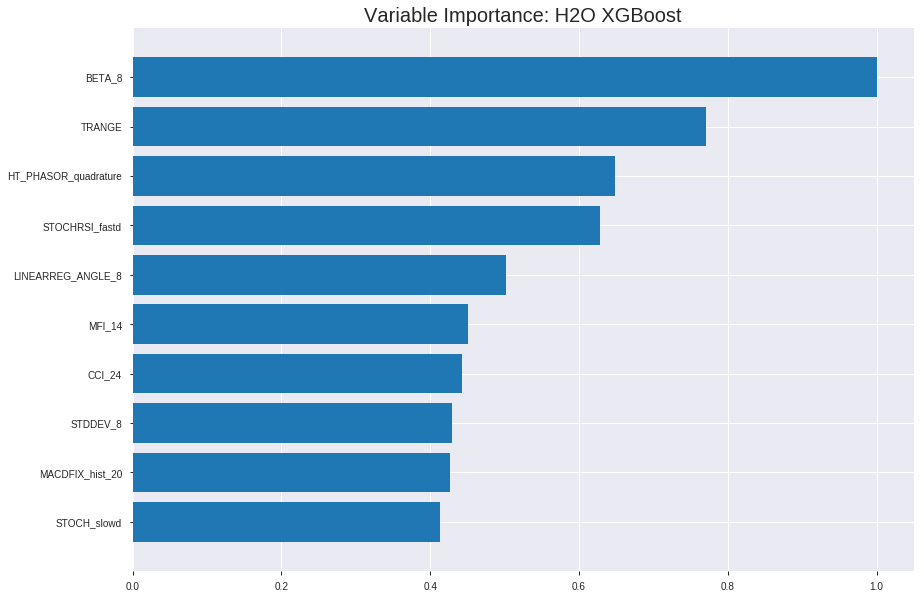

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_020219_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13834240270906242
RMSE: 0.37194408546051977
LogLoss: 0.4555389911642541
Mean Per-Class Error: 0.08403593052673464
AUC: 0.9732577200413126
pr_auc: 0.9788149027915675
Gini: 0.9465154400826252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5324558615684509: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      570  65   0.1024   (65.0/635.0)
1      59   772  0.071    (59.0/831.0)
Total  629  837  0.0846   (124.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532456     0.925659  215
max f2                       0.492895     0.950812  239
max f0point5                 0.583049     0.941445  182
max accuracy                 0.545727     0.916098  206
max precision                0.907277     1         0
max recall                   0.372958     1         314
max specificity              0.907277     1         0
max absolute_mcc             0.545727     0.829796  206
max min_per_class_accuracy   0.545727     0.914961  206
max mean_per_class_accuracy  0.545727     0.915964  206

Gains/Lift Table: Avg response rate: 56.68 %, avg score: 56.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.856265           1.76414    1.76414            1                0.882524  1                           0.882524            0.0180505       0.0180505                  76.414    76.414
    2        0.0204638                   0.836184           1.76414    1.76414            1                0.844193  1                           0.863359            0.0180505       0.0361011                  76.414    76.414
    3        0.0300136                   0.823116           1.76414    1.76414            1                0.829276  1                           0.852514            0.0168472       0.0529483                  76.414    76.414
    4        0.0402456                   0.813778           1.76414    1.76414            1                0.818034  1                           0.843748            0.0180505       0.0709988                  76.414    76.414
    5        0.0504775                   0.80707            1.76414    1.76414            1                0.810322  1                           0.836972            0.0180505       0.0890493                  76.414    76.414
    6        0.100273                    0.76772            1.76414    1.76414            1                0.788292  1                           0.812798            0.087846        0.176895                   76.414    76.414
    7        0.150068                    0.745808           1.76414    1.76414            1                0.756158  1                           0.794004            0.087846        0.264741                   76.414    76.414
    8        0.200546                    0.726626           1.76414    1.76414            1                0.735454  1                           0.779267            0.0890493       0.353791                   76.414    76.414
    9        0.300136                    0.679015           1.73997    1.75612            0.986301         0.702211  0.995455                    0.753698            0.173285        0.527076                   73.9973   75.6121
    10       0.400409                    0.63215            1.68013    1.73709            0.952381         0.6561    0.984668                    0.729257            0.168472        0.695548                   68.0133   73.7091
    11       0.5                         0.579344           1.55873    1.70156            0.883562         0.60645   0.964529                    0.704796            0.155235        0.850782                   55.8726   70.1564
    12       0.600273                    0.511422           0.984078   1.58171            0.557823         0.546887  0.896591                    0.678418            0.0986763       0.949458                   -1.59221  58.1712
    13       0.699864                    0.446132           0.326245   1.40306            0.184932         0.480324  0.795322                    0.650229            0.032491        0.981949                   -67.3755  40.3058
    14       0.800136                    0.388723           0.156012   1.24678            0.0884354        0.417305  0.706735                    0.621039            0.0156438       0.997593                   -84.3988  24.6779
    15       0.899727                    0.331585           0.0241663  1.11145            0.0136986        0.359705  0.630023                    0.592112            0.00240674      1                          -97.5834  11.1448
    16       1                           0.169782           0          1                  0                0.281884  0.566849                    0.56100



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24734672543403952
RMSE: 0.49733964796106844
LogLoss: 0.6875487588322814
Mean Per-Class Error: 0.4433104238258878
AUC: 0.555360824742268
pr_auc: 0.5958207128308961
Gini: 0.110721649484536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26035258173942566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    190  0.9794   (190.0/194.0)
1      0    225  0        (0.0/225.0)
Total  4    415  0.4535   (190.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260353     0.703125  395
max f2                       0.260353     0.855513  395
max f0point5                 0.426619     0.613651  324
max accuracy                 0.426619     0.579952  324
max precision                0.77033      1         0
max recall                   0.260353     1         395
max specificity              0.77033      1         0
max absolute_mcc             0.426619     0.146714  324
max min_per_class_accuracy   0.528701     0.537778  198
max mean_per_class_accuracy  0.426619     0.55669   324

Gains/Lift Table: Avg response rate: 53.70 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.721838           1.48978   1.48978            0.8              0.741202  0.8                         0.741202            0.0177778       0.0177778                  48.9778   48.9778
    2        0.0214797                   0.712055           1.86222   1.65531            1                0.717594  0.888889                    0.73071             0.0177778       0.0355556                  86.2222   65.5309
    3        0.0310263                   0.704636           1.86222   1.71897            1                0.708353  0.923077                    0.723831            0.0177778       0.0533333                  86.2222   71.8974
    4        0.0405728                   0.695906           0.465556  1.42405            0.25             0.700186  0.764706                    0.718267            0.00444444      0.0577778                  -53.4444  42.4052
    5        0.0501193                   0.683186           1.86222   1.50751            1                0.692534  0.809524                    0.713366            0.0177778       0.0755556                  86.2222   50.7513
    6        0.100239                    0.649587           1.06413   1.28582            0.571429         0.664057  0.690476                    0.688711            0.0533333       0.128889                   6.4127    28.582
    7        0.150358                    0.619381           0.709418  1.09369            0.380952         0.636326  0.587302                    0.671249            0.0355556       0.164444                   -29.0582  9.36861
    8        0.200477                    0.597829           0.798095  1.01979            0.428571         0.608896  0.547619                    0.655661            0.04            0.204444                   -20.1905  1.97884
    9        0.300716                    0.57104            1.33016   1.12325            0.714286         0.585435  0.603175                    0.632252            0.133333        0.337778                   33.0159   12.3245
    10       0.400955                    0.549178           0.842434  1.05304            0.452381         0.560284  0.565476                    0.61426             0.0844444       0.422222                   -15.7566  5.30423
    11       0.501193                    0.528614           1.1528    1.07299            0.619048         0.53751   0.57619                     0.59891             0.115556        0.537778                   15.2804   7.29947
    12       0.599045                    0.506025           0.908401  1.04611            0.487805         0.518549  0.561753                    0.585784            0.0888889       0.626667                   -9.15989  4.61089
    13       0.699284                    0.469438           1.10847   1.05505            0.595238         0.487893  0.566553                    0.571751            0.111111        0.737778                   10.8466   5.50474
    14       0.799523                    0.435414           1.06413   1.05619            0.571429         0.45346   0.567164                    0.556921            0.106667        0.844444                   6.4127    5.61857
    15       0.899761                    0.394559           0.842434  1.03237            0.452381         0.41603   0.554377                    0.541225            0.0844444       0.928889                   -15.7566  3.23725
    16       1                           0.193664           0.709418  1                  0.380952         0.323581  0.536993                    0.519409          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:02:31  6.639 sec   0                  0.5              0.693147            0.5             0                  1                0.433151                         0.5                0.693147              0.5               0                    1                  0.463007
    2019-09-06 02:02:31  6.742 sec   5                  0.480268         0.654283            0.814271        0.854781           1.76414          0.264666                         0.500593           0.694342              0.524009          0.561811             1.48978            0.463007
    2019-09-06 02:02:31  6.812 sec   10                 0.463456         0.621913            0.865462        0.89382            1.76414          0.216917                         0.498786           0.6907                0.533505          0.575061             1.11733            0.443914
    2019-09-06 02:02:31  6.878 sec   15                 0.448321         0.593264            0.898515        0.92069            1.76414          0.180082                         0.497213           0.687522              0.544089          0.575592             1.11733            0.443914
    2019-09-06 02:02:31  6.948 sec   20                 0.434442         0.567264            0.916214        0.935608           1.76414          0.158254                         0.493386           0.679707              0.573918          0.622167             1.86222            0.429594
    2019-09-06 02:02:31  7.020 sec   25                 0.421424         0.543477            0.935036        0.950847           1.76414          0.135061                         0.493146           0.679147              0.576953          0.628309             1.86222            0.429594
    2019-09-06 02:02:31  7.092 sec   30                 0.410406         0.523276            0.942981        0.955969           1.76414          0.126876                         0.494095           0.68107               0.571489          0.610266             1.48978            0.446301
    2019-09-06 02:02:31  7.158 sec   35                 0.399769         0.504317            0.954524        0.965105           1.76414          0.109141                         0.494976           0.682734              0.560458          0.605894             1.86222            0.436754
    2019-09-06 02:02:31  7.231 sec   40                 0.390228         0.487456            0.961545        0.969927           1.76414          0.100955                         0.496432           0.685691              0.551031          0.594636             1.86222            0.446301
    2019-09-06 02:02:31  7.303 sec   45                 0.381202         0.471414            0.966544        0.973565           1.76414          0.0879945                        0.496831           0.686572              0.554948          0.595302             1.48978            0.448687
    2019-09-06 02:02:31  7.376 sec   50                 0.371944         0.455539            0.973258        0.978815           1.76414          0.0845839                        0.49734            0.687549              0.555361          0.595821             1.48978            0.453461

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ----------------------
BETA_8                    294.3704833984375      1.0                   0.03879901547632524
TRANGE                    226.81784057617188     0.7705182868798992    0.02989535093744482
HT_PHASOR_quadrature      190.8932342529297      0.6484795352071734    0.025160367522583316
STOCHRSI_fastd            184.8000030517578      0.6277803430503138    0.024357259245741895
LINEARREG_ANGLE_8         147.66812133789062     0.5016403806288495    0.019463152891568417
---                       ---                    ---                   ---
BBANDS_upperband_24_0_3   5.916567802429199      0.02009905250731604   0.0007798234492908285
BBANDS_upperband_14_7_5   4.483715057373047      0.01523153750202676   0.0005909686592693646
BBANDS_upperband_20_3_3   3.9681777954101562     0.0134802163233164    0.0005230191217525651
BBANDS_upperband_20_3_4   3.5116679668426514     0.011929416041653622  0.0004628495976236414
BBANDS_middleband_20_0_3  3.229762077331543      0.010971759260795121  0.00042569345736210467


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5619047619047619)

('F1', 0.7018633540372671)

('auc', 0.5191132195967522)

('logloss', 0.7159907782859981)

('mean_per_class_error', 0.4574400145972083)

('rmse', 0.5101734687822672)

('mse', 0.26027696824933094)

xgboost prediction progress: |████████████████████████████████████████████| 100%


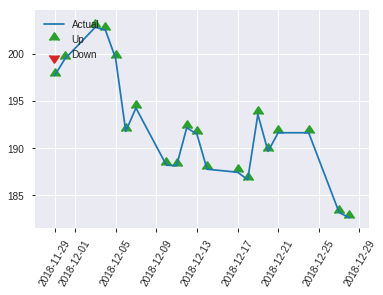


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26027696824933094
RMSE: 0.5101734687822672
LogLoss: 0.7159907782859981
Mean Per-Class Error: 0.4574400145972083
AUC: 0.5191132195967522
pr_auc: 0.5334868770631677
Gini: 0.038226439193504325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21750587224960327: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      1    96   0.9897   (96.0/97.0)
1      0    113  0        (0.0/113.0)
Total  1    209  0.4571   (96.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217506     0.701863  208
max f2                       0.217506     0.854766  208
max f0point5                 0.318316     0.60221   197
max accuracy                 0.42286      0.561905  158
max precision                0.792632     1         0
max recall                   0.217506     1         208
max specificity              0.792632     1         0
max absolute_mcc             0.68724      0.142262  11
max min_per_class_accuracy   0.52566      0.522124  101
max mean_per_class_accuracy  0.42286      0.54256   158

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 50.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.759843           1.23894   1.23894            0.666667         0.774424  0.666667                    0.774424            0.0176991       0.0176991                  23.8938   23.8938
    2        0.0238095                   0.747451           0         0.743363           0                0.751876  0.4                         0.765405            0               0.0176991                  -100      -25.6637
    3        0.0333333                   0.724727           0         0.530973           0                0.737204  0.285714                    0.757348            0               0.0176991                  -100      -46.9027
    4        0.0428571                   0.709645           0         0.412979           0                0.711174  0.222222                    0.747087            0               0.0176991                  -100      -58.7021
    5        0.052381                    0.691436           0.929204  0.506838           0.5              0.701341  0.272727                    0.738769            0.00884956      0.0265487                  -7.07965  -49.3162
    6        0.1                         0.645865           1.30088   0.884956           0.7              0.671896  0.47619                     0.706925            0.0619469       0.0884956                  30.0885   -11.5044
    7        0.152381                    0.619006           1.18262   0.987279           0.636364         0.630766  0.53125                     0.680745            0.0619469       0.150442                   18.2623   -1.27212
    8        0.2                         0.604585           0.929204  0.973451           0.5              0.611025  0.52381                     0.664145            0.0442478       0.19469                    -7.07965  -2.65487
    9        0.3                         0.568866           0.973451  0.973451           0.52381          0.590581  0.52381                     0.639624            0.0973451       0.292035                   -2.65487  -2.65487
    10       0.4                         0.547072           1.41593   1.08407            0.761905         0.55921   0.583333                    0.61952             0.141593        0.433628                   41.5929   8.40708
    11       0.5                         0.520853           0.884956  1.04425            0.47619          0.536878  0.561905                    0.602992            0.0884956       0.522124                   -11.5044  4.42478
    12       0.6                         0.484105           0.79646   1.00295            0.428571         0.502288  0.539683                    0.586208            0.079646        0.60177                    -20.354   0.294985
    13       0.7                         0.441983           1.32743   1.0493             0.714286         0.465247  0.564626                    0.568928            0.132743        0.734513                   32.7434   4.93047
    14       0.8                         0.395761           0.79646   1.0177             0.428571         0.422311  0.547619                    0.550601            0.079646        0.814159                   -20.354   1.76991
    15       0.9                         0.341468           0.973451  1.01278            0.52381          0.36892   0.544974                    0.530414            0.0973451       0.911504                   -2.65487  1.27827
    16       1                           0.204699           0.884956  1                  0.47619          0.297686  0.538095                    0.507141

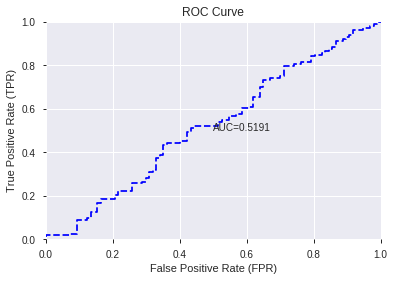

This function is available for GLM models only


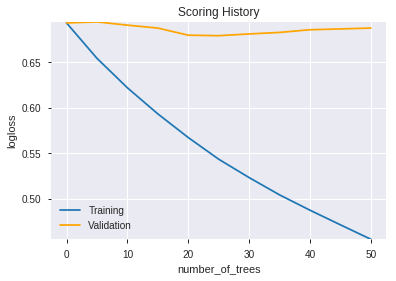

--2019-09-06 02:02:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_020219_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_020219_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_abf2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BETA_8',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_8',
 'MFI_14',
 'CCI_24',
 'STDDEV_8',
 'MACDFIX_hist_20',
 'STOCH_slowd',
 'MFI_24',
 'STOCHF_fastk',
 'CORREL_8',
 'BETA_12',
 'HT_DCPERIOD',
 'MACDEXT_hist',
 'ADX_20',
 'STOCHF_fastd',
 'ADX_24',
 'WILLR_24',
 'ROC_30',
 'ADX_14',
 'WILLR_8',
 'MACDFIX_signal_12',
 'ULTOSC',
 'ROC_12',
 'WILLR_12',
 'MOM_12',
 'NATR_8',
 'MACDFIX_signal_14',
 'HT_PHASOR_inphase',
 'MINUS_DM_24',
 'AROONOSC_24',
 'ATR_8',
 'MFI_20',
 'TRIX_8',
 'ROC_8',
 'TRIX_14',
 'PLUS_DM_12',
 'PLUS_DM_24',
 'MOM_8',
 'NATR_20',
 'PLUS_DI_14',
 'CORREL_12',
 'TRIX_12',
 'AD',
 'CCI_14',
 'aroondown_30',
 'ATR_14',
 'MINUS_DI_20',
 'WILLR_30',
 'RSI_8',
 'NATR_14',
 'ROC_20',
 'CMO_30',
 'MINUS_DI_24',
 'MACDFIX_hist_14',
 'MINUS_DM_12',
 'CMO_12',
 'CCI_12',
 'PLUS_DM_14',
 'ROCR_14',
 'MACDFIX_hist_8',
 'ROCP_24',
 'SAR_0.2',
 'PLUS_DM_30',
 'ROC_24',
 'NATR_24',
 'PLUS_DI_8',
 'aroonup_24',
 'ATR_12',
 'VAR_8',
 'MOM_14',
 'CMO

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.571
GLM             0.590
XGBoost         0.562
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.538    0.557
DLF          0.557  0.552    0.557
Fwe          0.538  0.538    0.557
RFE          0.571  0.590    0.562
XGBF         0.552  0.552    0.557





F1


DeepLearning    0.706
GLM             0.700
XGBoost         0.704
dtype: float64

DeepLearning  GLM  XGBoost
All          0.700  0.7    0.704
DLF          0.706  0.7    0.700
Fwe          0.700  0.7    0.704
RFE          0.702  0.7    0.702
XGBF         0.700  0.7    0.700





auc


DeepLearning    0.548
GLM             0.571
XGBoost         0.530
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.523
DLF          0.527  0.539    0.530
Fwe          0.504  0.500    0.523
RFE          0.548  0.571    0.519
XGBF         0.503  0.539    0.530





logloss


DeepLearning    18.585
GLM             18.585
XGBoost          0.716
dtype: float64

DeepLearning     GLM  XGBoost
All          0.690  18.585    0.705
DLF          0.693   0.690    0.711
Fwe         18.585  18.585    0.705
RFE         12.694   0.689    0.716
XGBF         0.692   0.690    0.711





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.457
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.457
DLF          0.434  0.436    0.445
Fwe          0.496  0.500    0.457
RFE          0.427  0.408    0.457
XGBF         0.472  0.436    0.445





rmse


DeepLearning    0.734
GLM             0.734
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.499  0.734    0.506
DLF          0.500  0.499    0.507
Fwe          0.734  0.734    0.506
RFE          0.734  0.498    0.510
XGBF         0.500  0.499    0.507





mse


DeepLearning    0.538
GLM             0.538
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.249  0.538    0.256
DLF          0.250  0.249    0.258
Fwe          0.538  0.538    0.256
RFE          0.538  0.248    0.260
XGBF         0.250  0.249    0.258

{'F1':       DeepLearning  GLM  XGBoost
 All          0.700  NaN      NaN
 DLF          0.706  NaN      NaN
 DLF            NaN  0.7      NaN
 DLF            NaN  NaN    0.700
 All            NaN  0.7      NaN
 All            NaN  NaN    0.704
 XGBF         0.700  NaN      NaN
 XGBF           NaN  0.7      NaN
 XGBF           NaN  NaN    0.700
 Fwe          0.700  NaN      NaN
 Fwe            NaN  0.7      NaN
 Fwe            NaN  NaN    0.704
 RFE          0.702  NaN      NaN
 RFE            NaN  0.7      NaN
 RFE            NaN  NaN    0.702,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.538    NaN      NaN
 DLF          0.557    NaN      NaN
 DLF            NaN  0.552      NaN
 DLF            NaN    NaN    0.557
 All            NaN  0.538      NaN
 All            NaN    NaN    0.557
 XGBF         0.552    NaN      NaN
 XGBF           NaN  0.552      NaN
 XGBF           NaN    NaN    0.557
 Fwe          0.538    NaN      NaN
 Fwe            NaN  0.538      NaN
 Fwe 